Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 63

In [1]:
num_days_R_prediction=63

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=27 # =(6/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=51
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
238                           NaN                Thailand  15.870032   
239                           NaN             Timor-Leste  -8.874217   
240                           NaN                    Togo   8.619500   
241                           NaN     Trinidad and Tobago  10.691800   
242                           NaN                 Tunisia  33.886917   
243                           NaN                  Turkey  38.963700   
244                           NaN           United States  40.000000   
245                           NaN                  Uganda   1.373333   
246                           NaN                 Ukraine  48.379400   
247                           NaN    United Arab Emirates  23.424076   
248                      Anguilla          United Kingdom  18.220600   
249                       Bermuda          United Kingdom  32.307800   
250        British Virgin Islands          United Kingdom  18.420700   
251                Cayman Islands          United Kingdom  19.313300   
252               Channel Islands          United Kingdom  49.372300   
253   Falkland Islands (Malvinas)          United Kingdom -51.796300   
254                     Gibraltar          United Kingdom  36.140800   
255                   Isle of Man          United Kingdom  54.236100   
256                    Montserrat          United Kingdom  16.742498   
257      Turks and Caicos Islands          United Kingdom  21.694000   
258                           NaN          United Kingdom  55.378100   
259                           NaN                 Uruguay -32.522800   
260                           NaN              Uzbekistan  41.377491   
261                           NaN               Venezuela  

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
244                           NaN                Thailand  15.870032   
245                           NaN             Timor-Leste  -8.874217   
246                           NaN                    Togo   8.619500   
247                           NaN     Trinidad and Tobago  10.691800   
248                           NaN                 Tunisia  33.886917   
249                           NaN                  Turkey  38.963700   
250                           NaN           United States  40.000000   
251                           NaN                  Uganda   1.373333   
252                           NaN                 Ukraine  48.379400   
253                           NaN    United Arab Emirates  23.424076   
254                      Anguilla          United Kingdom  18.220600   
255                       Bermuda          United Kingdom  32.307800   
256        British Virgin Islands          United Kingdom  18.420700   
257                Cayman Islands          United Kingdom  19.313300   
258               Channel Islands          United Kingdom  49.372300   
259   Falkland Islands (Malvinas)          United Kingdom -51.796300   
260                     Gibraltar          United Kingdom  36.140800   
261                   Isle of Man          United Kingdom  54.236100   
262                    Montserrat          United Kingdom  16.742498   
263      Turks and Caicos Islands          United Kingdom  21.694000   
264                           NaN          United Kingdom  55.378100   
265                           NaN                 Uruguay -32.522800   
266                           NaN              Uzbekistan  41.377491   
267                           NaN               Venezuela  

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN        Moldova  47.411600   28.369900   
186                               NaN         Monaco  43.733300    7.416700   
187                               NaN       Mongolia  46.862500  103.846700   
188                               NaN     Montenegro  42.708678   19.374390   
189                               NaN        Morocco  31.791700   -7.092600   
190                               NaN     Mozambique -18.665695   35.529562   
191                               NaN        Namibia -22.957600   18.490400   
192                               NaN          Nepal  28.166700   84.250000   
193                             Aruba    Netherlands  12.521100  -69.968300   
194  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/2/20  \
185        0        0        0        0        0        0  ...     1818   
186        0        0        0        0        0        0  ...        2   
187        0        0        0        0        0        0  ...        0   
188        0        0        0        0        0        0  ...      320   
189        0        0        0        0        0        0  ...     3826   
190        0        0        0        0        0        0  ...       94   
191        0        0        0        0        0        0  ...      133   
192        0        0        0        0        0        0  ...      984   
193        0        0        0        0        0        0  ...       38   
194        0        0        0        0        0        0  ...        3   

     11/3/20  11/4/20  11/5/20  11/6/20  11/7/20  11/8/20  11/9/20  \
185     1838     1851     1866     1882     1891     1893     1912   
186        2        2        2        2        2        2        2   
187        0        0        0        0        0        0        0   
188      322      326      328      328      333      337      342   
189     3900     3982     4059     4127     4197     4272     4356   
190       95       95       97       99       99       99       99   
191      133      133      133      133      134      134      134   
192     1004     1034     1052     1070     1087     1108     1126   
193       38       39       39       39       40       40       41   
194        3        3        3        3        3        3        3   

      Population                                         region  
185     4,035,942                                   Moldova_nan  
186        39,183                                    Monaco_nan  
187           NaN                                  Mongolia_nan  
188       622 500                                Montenegro_nan  
189    36,817,128                                   Morocco_nan  
190    31,542,919                                Mozambique_nan  
191           NaN                                   Namibia_nan  
192    29,300,000                                     Nepal_nan  
193           NaN                             Netherlands_Aruba  
194           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 299 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/2/20  \
175        0        0        0        0        0        0  ...    10439   
176        0        0        0        0        0        0  ...    11201   
177        0        0        0        0        0        0  ...   137992   
178        0        0        0        0        0        0  ...     4331   
179        0        0        0        0        0        0  ...      145   
180        0        0        0        0        0        0  ...      698   
181        0        0        0        0        0        0  ...      760   
182        0        0        0        0        0        0  ...        0   
183        0        0        0        0        0        0  ...     1868   
184        0        0        0        0        0        0  ...     4225   

     11/3/20  11/4/20  11/5/20  11/6/20  11/7/20  11/8/20  11/9/20  \
175    10695    10983    11177    11275    11581    11605    11659   
176    11304    11344    11438    11578    11602    11605    11620   
177   141134   144978   148408   152908   155114   157926   159724   
178     4340     4348     4352     4367     4383     4389     4389   
179      145      145      145      145      145      145      145   
180      722      746      768      783      808      816      822   
181      768      768      780      780      787      787      801   
182        0        0        0        0        0        0        0   
183     1873     1881     1905     1908     1909     1910     1910   
184     4225     4225     4225     4225     4225     4225     4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176           NaN                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180           NaN                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 299 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN        Moldova  47.411600   28.369900   
186                               NaN         Monaco  43.733300    7.416700   
187                               NaN       Mongolia  46.862500  103.846700   
188                               NaN     Montenegro  42.708678   19.374390   
189                               NaN        Morocco  31.791700   -7.092600   
190                               NaN     Mozambique -18.665695   35.529562   
191                               NaN        Namibia -22.957600   18.490400   
192                               NaN          Nepal  28.166700   84.250000   
193                             Aruba    Netherlands  12.521100  -69.968300   
194  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/2/20  \
185        0        0        0        0        0        0  ...    76777   
186        0        0        0        0        0        0  ...      375   
187        0        0        0        0        0        0  ...      350   
188        0        0        0        0        0        0  ...    19210   
189        0        0        0        0        0        0  ...   225070   
190        0        0        0        0        0        0  ...    13130   
191        0        0        0        0        0        0  ...    13012   
192        0        0        0        1        1        1  ...   176500   
193        0        0        0        0        0        0  ...     4524   
194        0        0        0        0        0        0  ...      153   

     11/3/20  11/4/20  11/5/20  11/6/20  11/7/20  11/8/20  11/9/20  \
185    77487    78507    79566    80501    81675    82346    82677   
186      397      412      430      454      483      486      490   
187      352      353      356      357      357      362      368   
188    19977    20851    21533    22079    22379    22805    23608   
189   229565   235310   240951   246349   252185   256781   259951   
190    13202    13283    13391    13485    13577    13768    13823   
191    13030    13046    13090    13143    13170    13211    13240   
192   179614   182923   185974   188883   191636   194453   197024   
193     4538     4553     4564     4578     4589     4600     4606   
194      153      153      153      154      154      154      154   

      Population                                         region  
185     4,035,942                                   Moldova_nan  
186        39,183                                    Monaco_nan  
187           NaN                                  Mongolia_nan  
188       622 500                                Montenegro_nan  
189    36,817,128                                   Morocco_nan  
190    31,542,919                                Mozambique_nan  
191           NaN                                   Namibia_nan  
192    29,300,000                                     Nepal_nan  
193           NaN                             Netherlands_Aruba  
194           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 299 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State         Country/Region        Lat        Long  1/22/20  \
220            NaN             San Marino  43.942400   12.457800        0   
221            NaN  Sao Tome and Principe   0.186400    6.613100        0   
222            NaN           Saudi Arabia  23.885942   45.079162        0   
223            NaN                Senegal  14.497400  -14.452400        0   
224            NaN                 Serbia  44.016500   21.005900        0   
225            NaN             Seychelles  -4.679600   55.492000        0   
226            NaN           Sierra Leone   8.460555  -11.779889        0   
227            NaN              Singapore   1.283300  103.833300        0   
228            NaN               Slovakia  48.669000   19.699000        0   
229            NaN               Slovenia  46.151200   14.995500        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/2/20  11/3/20  \
220        0        0        0        0        0  ...      928      994   
221        0        0        0        0        0  ...      949      954   
222        0        0        0        0        0  ...   348037   348510   
223        0        0        0        0        0  ...    15637    15640   
224        0        0        0        0        0  ...    49205    51083   
225        0        0        0        0        0  ...      153      157   
226        0        0        0        0        0  ...     2366     2368   
227        1        3        3        4        5  ...    58020    58029   
228        0        0        0        0        0  ...    61829    63556   
229        0        0        0        0        0  ...    36206    37382   

     11/4/20  11/5/20  11/6/20  11/7/20  11/8/20  11/9/20   Population   \
220      994     1043     1043     1043     1043     1114        33,916   
221      958      958      960      962      962      962           NaN   
222   348936   349386   349822   350229   350592   350984    34,695,447   
223    15650    15668    15676    15693    15708    15711           NaN   
224    53495    55676    57958    60635    62747    64065     8,744,671   
225      157      157      158      158      158      158           NaN   
226     2369     2371     2373     2381     2381     2385           NaN   
227    58036    58043    58047    58054    58056    58064     5,612,000   
228    66772    68734    71088    73667    75495    76072     5,459,087   
229    39408    41094    42658    44270    45161    45625     2,078,878   

                        region  
220             San Marino_nan  
221  Sao Tome and Principe_nan  
222           Saudi Arabia_nan  
223                Senegal_nan  
224                 Serbia_nan  
225             Seychelles_nan  
226           Sierra Leone_nan  
227              Singapore_nan  
228               Slovakia_nan  
229               Slovenia_nan  

[10 rows x 299 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

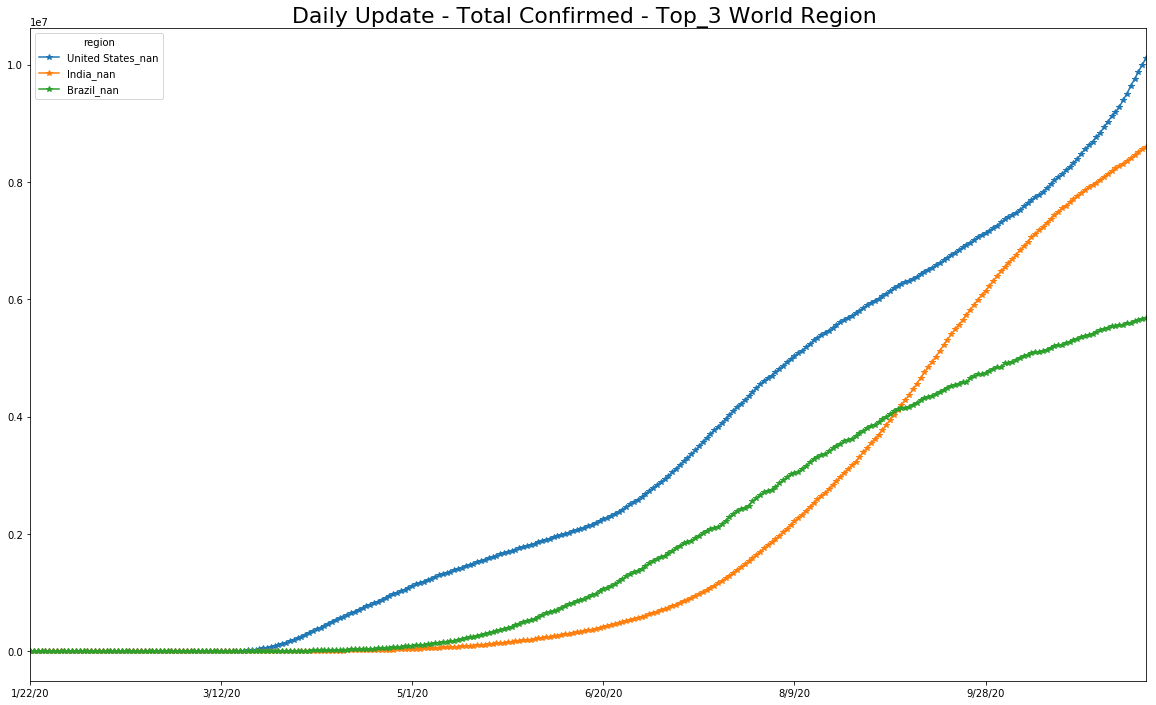

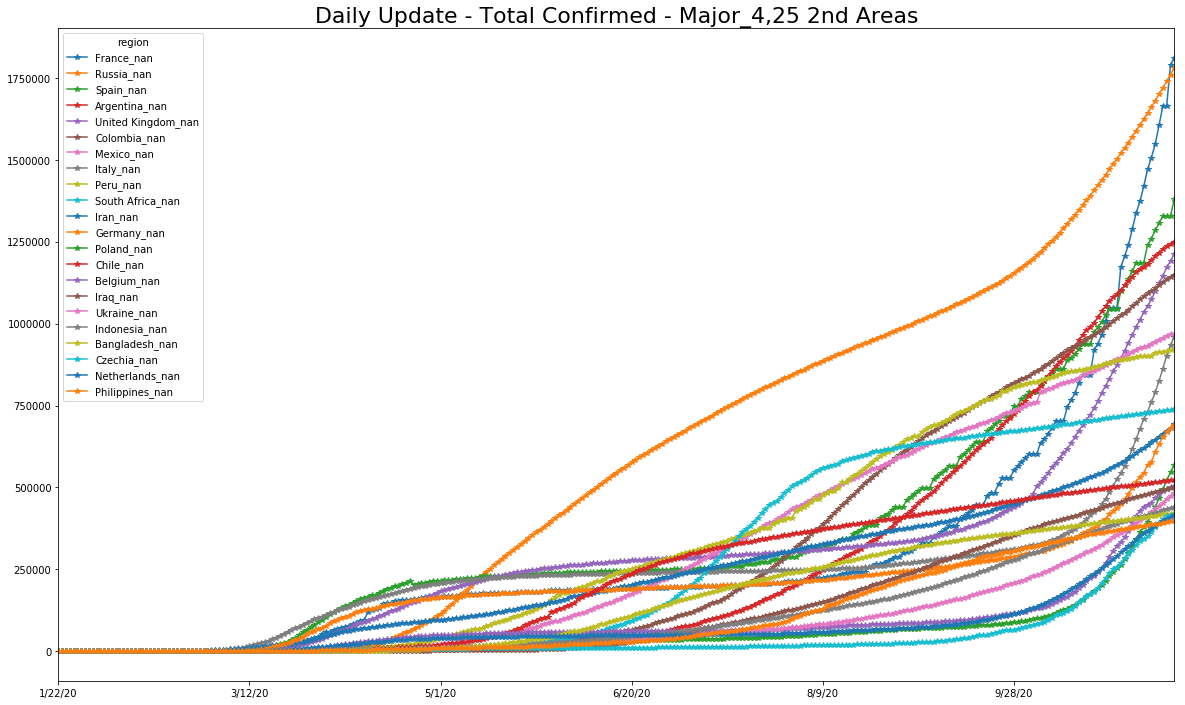

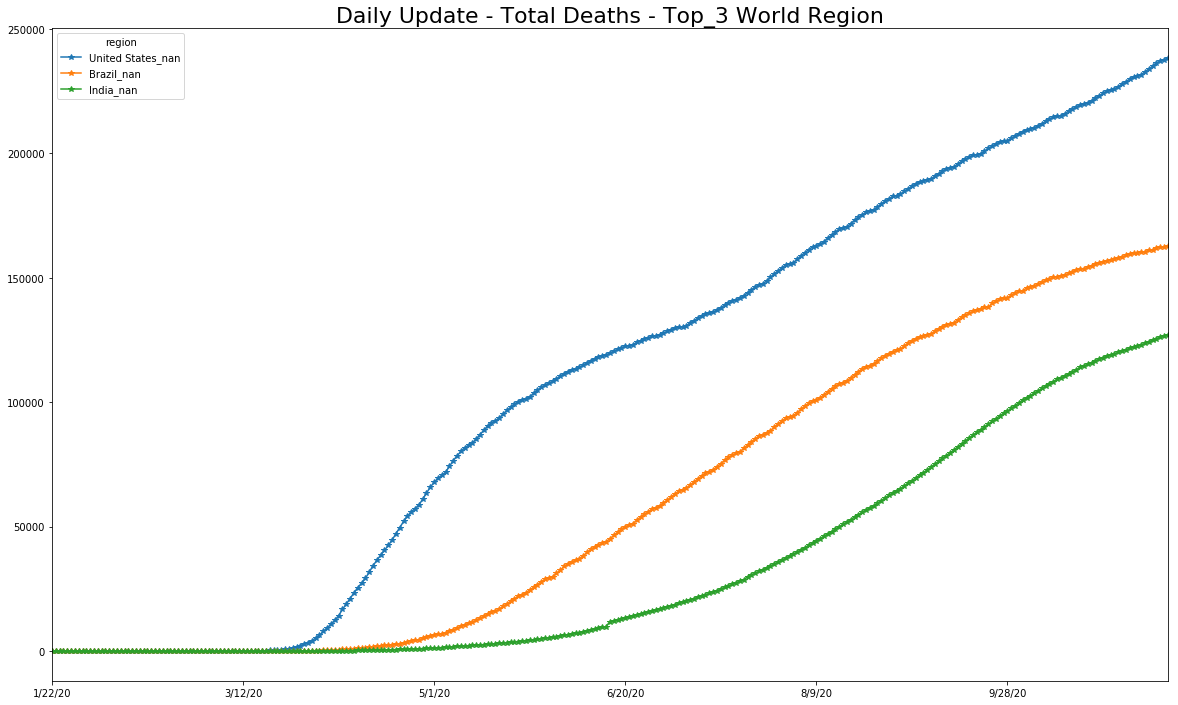

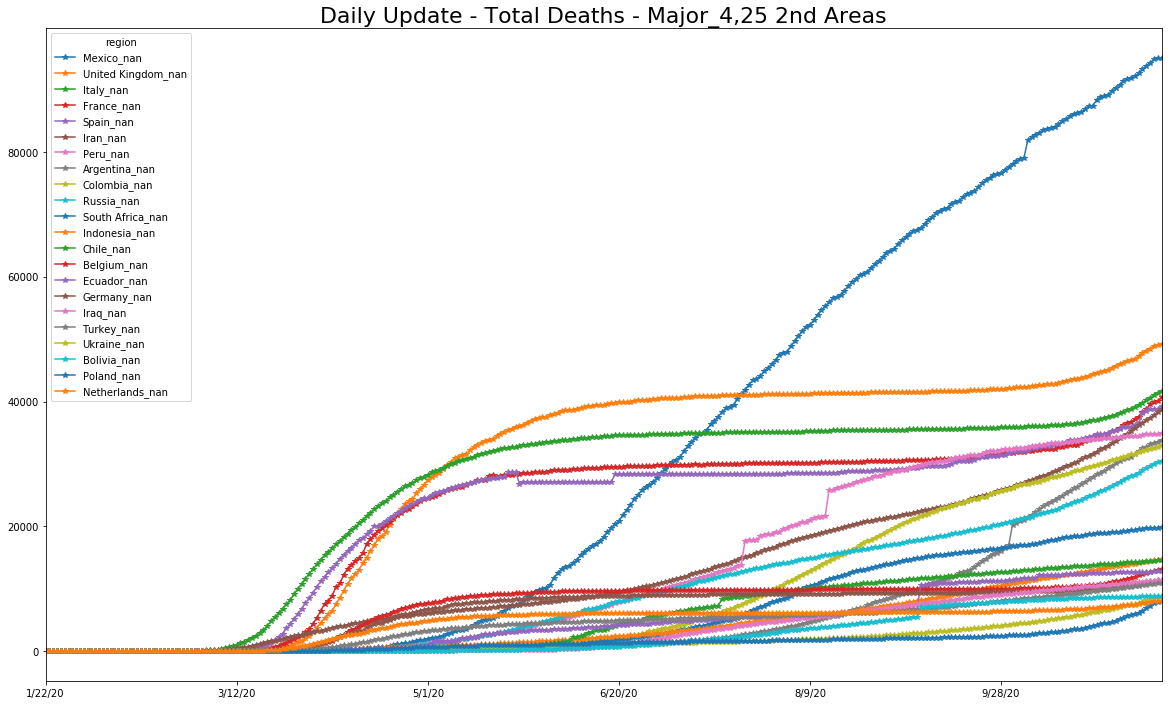

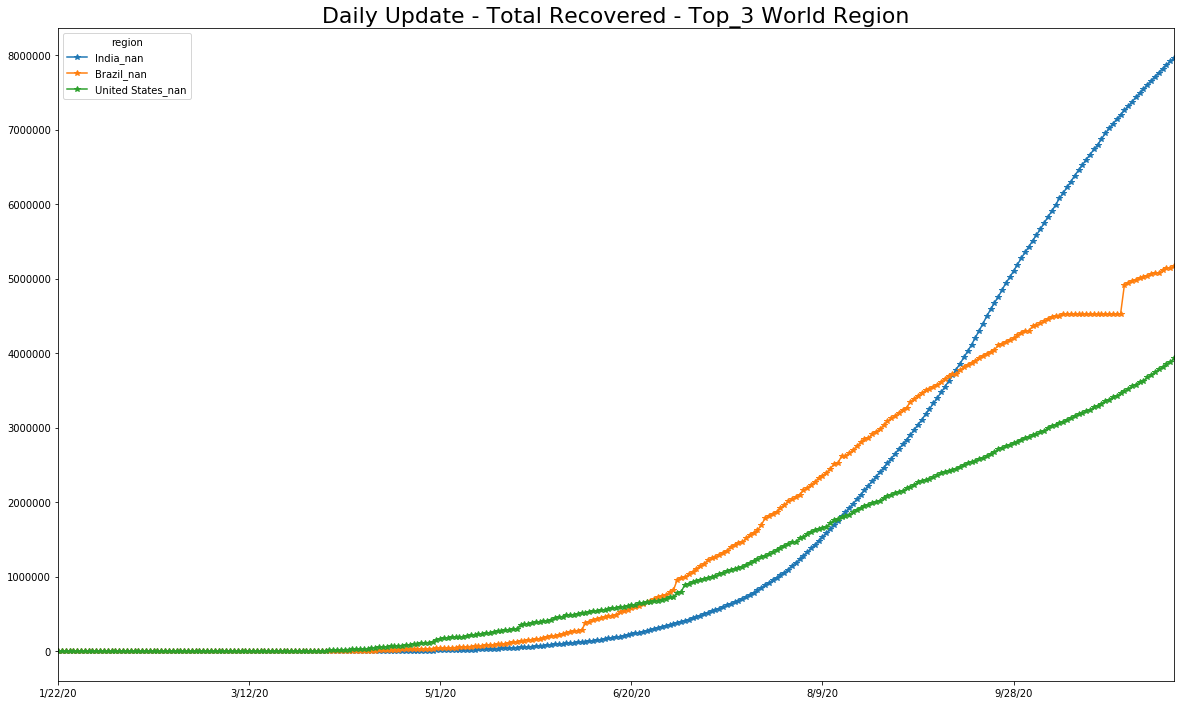

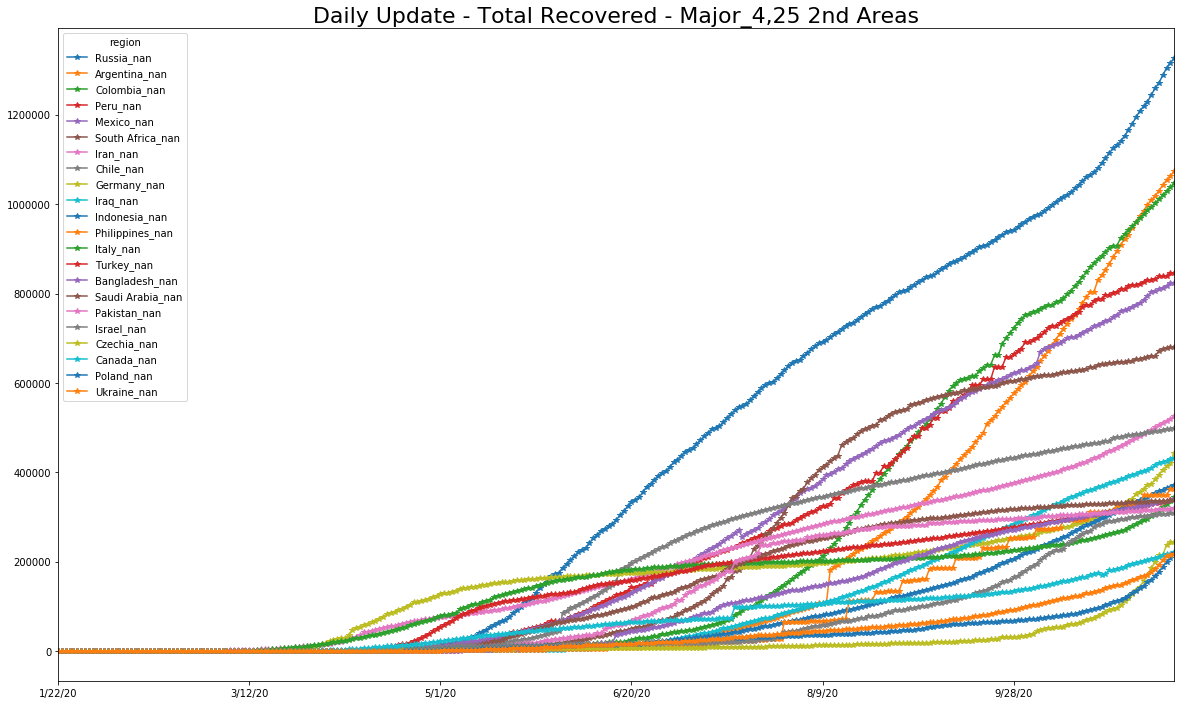

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/11/10


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34994         3752        20770          862         576   
7/16/20            35070         3851        21355          877         607   
7/17/20            35229         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Venezuela_nan  \
7/15/20  ...            3489638         1009           14581          10428   
7/16/20  ...            3566897         1026           15066          10854   
7/17/20  ...            3638525         1037           15607          11191   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
7/15/20          381                    7064                  10       1526   
7/16/20          381                    7412                  10       1552   
7/17/20          382                    7764                  10       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 268 columns]

In [24]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/6/20            41975        23210        60800         5135       12223   
11/7/20            42033        23705        61381         5319       12335   
11/8/20            42092        24206        62051         5383       12433   
11/9/20            42297        24731        62693         5437       12680   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/6/20                      130        1228814       101773   
11/7/20                      131        1236851       104249   
11/8/20                      131        1242182       106424   
11/9/20                      131        1250499       107466   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
11/6/20                                     114                       4459   
11/7/20                                     114                       4462   
11/8/20                                     114                       4469   
11/9/20                                     114                       4469   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Venezuela_nan  \
11/6/20  ...            9752360         3370           68139          94305   
11/7/20  ...            9880828         3441           68367          94698   
11/8/20  ...            9999644         3514           68730          94883   
11/9/20  ...           10111077         3560           69027          95149   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
11/6/20         1212                   57226                  10       2067   
11/7/20         1213                   57657                  10       2070   
11/8/20         1213                   58158                  10       2070   
11/9/20         1215                   58838                  10       2071   

region   Zambia_nan  Zimbabwe_nan  
11/6/20       16819          8471  
11/7/20       16908          8498  
11/8/20       16954          8531  
11/9/20       16971          8561  

[4 rows x 268 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
7158 2020-05-10  Vietnam_nan  26.9  33.0
7159 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35070             0             0   
2     2020-07-17  Afghanistan_nan      35229            76             0   
3     2020-07-18  Afghanistan_nan      35301           159             0   
4     2020-07-19  Afghanistan_nan      35475            72           307   
5     2020-07-20  Afghanistan_nan      35526           174           405   
6     2020-07-21  Afghanistan_nan      35615            51           297   
7     2020-07-22  Afghanistan_nan      35727            89           314   
8     2020-07-23  Afghanistan_nan      35928           112           252   
9     2020-07-24  Afghanistan_nan      35981           201           402   
10    2020-07-25  Afghanistan_nan      36036            53           366   
11    2020-07-26  Afghanistan_nan      36157            55           309   
12    2020-07-27  Afghanistan_nan      36263           121           229   
13    2020-07-28  Afghanistan_nan      36368           106           282   
14    2020-07-29  Afghanistan_nan      36471           105           332   
15    2020-07-30  Afghanistan_nan      36542           103           314   
16    2020-07-31  Afghanistan_nan      36675            71           279   
17    2020-08-01  Afghanistan_nan      36710           133           307   
18    2020-08-02  Afghanistan_nan      36710            35           239   
19    2020-08-03  Afghanistan_nan      36747             0           168   
20    2020-08-04  Afghanistan_nan      36782            37            72   
21    2020-08-05  Afghanistan_nan      36829            35            72   
22    2020-08-06  Afghanistan_nan      36896            47           119   
23    2020-08-07  Afghanistan_nan      37015            67           149   
24    2020-08-08  Afghanistan_nan      37054           119           233   
25    2020-08-09  Afghanistan_nan      37054            39           225   
26    2020-08-10  Afghanistan_nan      37162             0           158   
27    2020-08-11  Afghanistan_nan      37269           108           147   
28    2020-08-12  Afghanistan_nan      37345           107           215   
29    2020-08-13  Afghanistan_nan      37424            76           291   
30    2020-08-14  Afghanistan_nan      37431            79           262   
...          ...              ...        ...           ...           ...   
32576 2020-10-12     Zimbabwe_nan       8021             1            60   
32577 2020-10-13     Zimbabwe_nan       8036            10            27   
32578 2020-10-14     Zimbabwe_nan       8055            15            26   
32579 2020-10-15     Zimbabwe_nan       8075            19            44   
32580 2020-10-16     Zimbabwe_nan       8099            20            54   
32581 2020-10-17     Zimbabwe_nan       8110            24            63   
32582 2020-10-18     Zimbabwe_nan       8147            11            55   
32583 2020-10-19     Zimbabwe_nan       8159            37            72   
32584 2020-10-20     Zimbabwe_nan       8187            12            60   
32585 2020-10-21     Zimbabwe_nan       8215            28            77   
32586 2020-10-22     Zimbabwe_nan       8242            28            68   
32587 2020-10-23     Zimbabwe_nan       8257            27            83   
32588 2020-10-24     Zimbabwe_nan       8269            15            70   
32589 2020-10-25     Zimbabwe_nan       8276            12            54   
32590 2020-10-26     Zimbabwe_nan       8303             7            34   
32591 2020-10-27     Zimbabwe_nan       8315            27            46   
32592 2020-10-28     Zimbabwe_nan       8320            12            46   
32593 2020-10-29     Zimbabwe_nan       8349             5            44   
32594 2020-10-30     Zimbabwe_nan       8362            29            46   
32595 2020-10-31     Zimbabwe_nan       8367            13            47   
32596 2020-11-01     Zimbabwe_nan       8374             5  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
32605 2020-11-10  Zimbabwe_nan          0            30            90   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
32605           172         100.351776         101.062566         102.050423   

       last_day  kalman_prediction  population  infected_rate  min  max  
32605      8561             8577.0    14862924       0.000006  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
32605 2020-11-10  Zimbabwe_nan          0            30            90   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
32605           172         100.351776         101.062566         102.050423   

       last_day  kalman_prediction  population  infected_rate  min  max  
32605      8561             8577.0    14862924       0.000006  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
31889  2020-11-08  Zimbabwe_nan       8531            27            71   
31890  2020-11-09  Zimbabwe_nan       8561            33            87   
31891  2020-11-10  Zimbabwe_nan          0            30            90   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
31889           131         100.318853         100.842649         101.565794   
31890           157         100.388444         101.030436         101.874970   
31891           172         100.351776         101.062566         102.050423   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
31889                 8498  ...    14862924       0.000006  NaN  NaN   
31890                 8531  ...    14862924       0.000006  NaN  NaN   
31891                 8561  ...    14862924       0.000006  NaN  NaN   

       population_percentage : infected_rate confirmed  \
31889                                         0.000572   
31890                                         0.000574   
31891                                         0.000576   

       population_percentage : factor 9/10 infected_rate confirmed  \
31889                                           0.005718             
31890                                           0.005740             
31891                                           0.005761             

       delta : new_cases  delta : new_cases per 1M hab  \
31889               10.0                      0.672815   
31890               11.0                      0.740097   
31891               16.0                      1.076504   

       delta : roling 7day AVG  \
31889                18.714286   
31890                22.428571   
31891                24.571429   

       delta : aprox 14-day case notification rate per 100k hab  
31889                                           1.762776         
31890                                           2.112639         
31891                                           2.314484         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse           rmse            mae
258  United States_nan  8.889512e+11  942842.078169  102763.864407


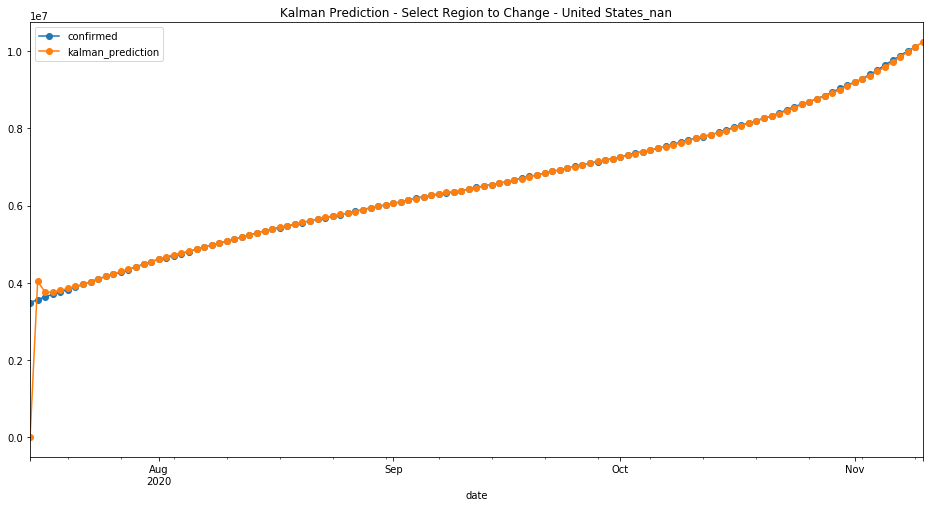

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
209  Russia_nan  2.759096e+10  166105.273475  17654.118644


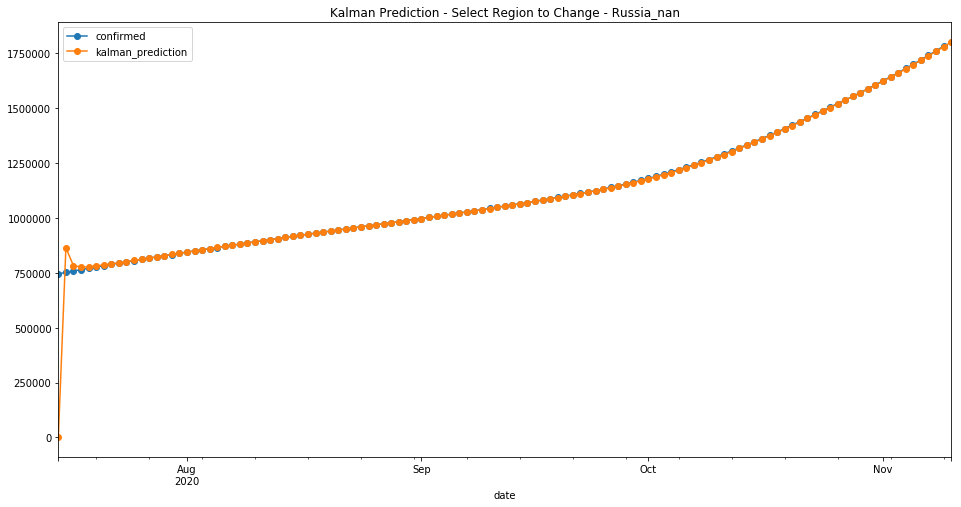

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  2.759670e+11  525325.636557  65940.322034


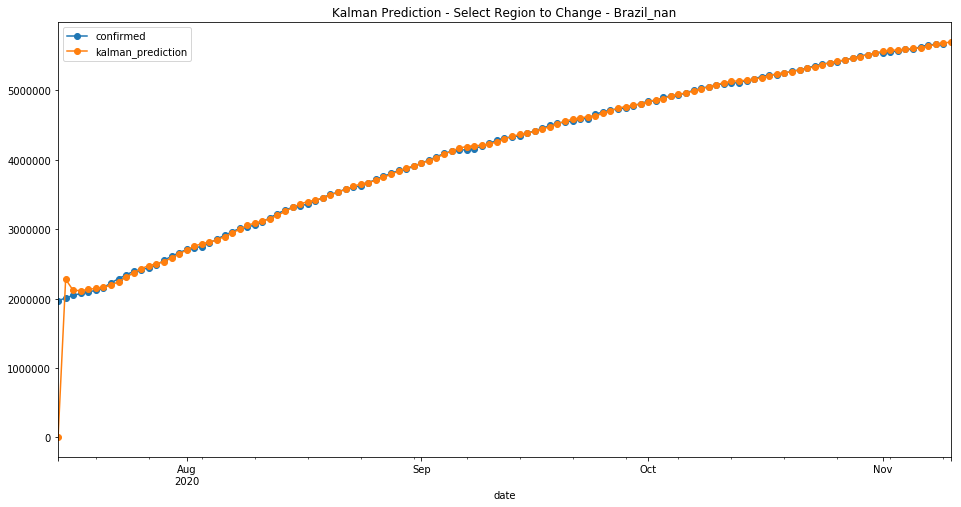

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
257  United Kingdom_nan  1.300288e+10  114030.176992  12687.033898


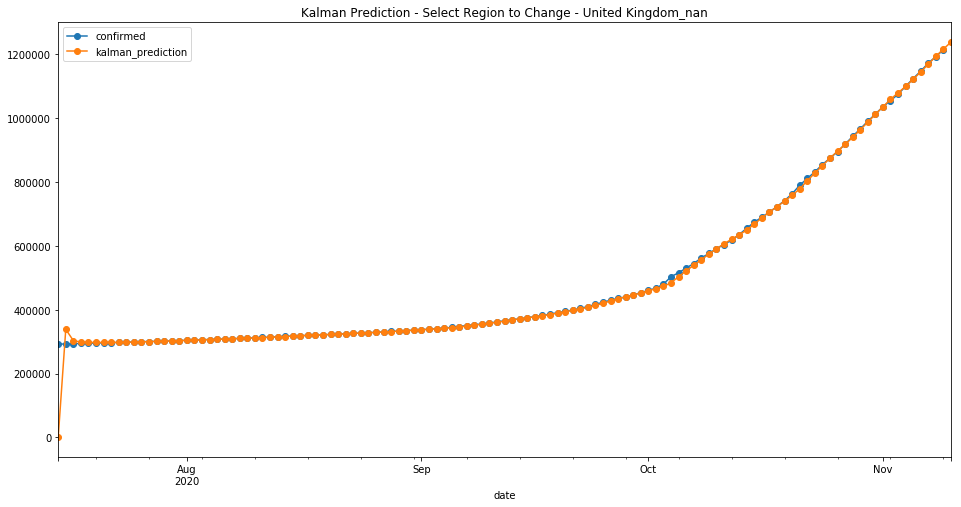

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9" 2020-10-20; OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5e8pq34n
  JVM stdout: /tmp/tmp5e8pq34n/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp5e8pq34n/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         01 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    1 month and 12 days
H2O_cluster_name:           H2O_from_python_unknownUser_1u47zg
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-10-14
last_train_date= 2020-11-09
first_bootstrap_date= 2020-11-01
boost_bootstrap_date= 2020-11-06
first_test_date= 2020-10-31
last_test_date= 2020-11-10
first_valid_date= 2020-11-08


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   41641.0      41501 2020-11-01  Afghanistan_nan
1   41722.0      41633 2020-11-02  Afghanistan_nan
2   41820.0      41728 2020-11-03  Afghanistan_nan
3   41934.0      41814 2020-11-04  Afghanistan_nan
4   42031.0      41935 2020-11-05  Afghanistan_nan
5   42131.0      41975 2020-11-06  Afghanistan_nan
6   42218.0      42033 2020-11-07  Afghanistan_nan
7   42266.0      42092 2020-11-08  Afghanistan_nan
8   42312.0      42297 2020-11-09  Afghanistan_nan
9   42424.0          0 2020-11-10  Afghanistan_nan
10  21211.0      21202 2020-11-01      Albania_nan
11  21456.0      21523 2020-11-02      Albania_nan
12  21778.0      21904 2020-11-03      Albania_nan
13  22114.0      22300 2020-11-04      Albania_nan
14  22512.0      22721 2020-11-05      Albania_nan
15  22942.0      23210 2020-11-06      Albania_nan
16  23405.0      23705 2020-11-07      Albania_nan
17  23942.0      24206 2020-11-08      Albania_nan
18  24492.0      24731 2020-11-09      Albania_nan
19  25047.0          0 2020-11-10      Albania_nan
20  58330.0      58272 2020-11-01      Algeria_nan
21  58653.0      58574 2020-11-02      Algeria_nan
22  58974.0      58979 2020-11-03      Algeria_nan
23  59339.0      59527 2020-11-04      Algeria_nan
24  59831.0      60169 2020-11-05      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  61782.0      62338 2020-11-06  Azerbaijan_nan
176  63274.0      63748 2020-11-07  Azerbaijan_nan
177  64816.0      65411 2020-11-08  Azerbaijan_nan
178  66483.0      66046 2020-11-09  Azerbaijan_nan
179  67686.0          0 2020-11-10  Azerbaijan_nan
180   6812.0       6714 2020-11-01     Bahamas_nan
181   6973.0       6735 2020-11-02     Bahamas_nan
182   6936.0       6790 2020-11-03     Bahamas_nan
183   6885.0       6843 2020-11-04     Bahamas_nan
184   6940.0       6882 2020-11-05     Bahamas_nan
185   7015.0       6882 2020-11-06     Bahamas_nan
186   7109.0       6947 2020-11-07     Bahamas_nan
187   7007.0       6947 2020-11-08     Bahamas_nan
188   7166.0       6964 2020-11-09     Bahamas_nan
189   7143.0          0 2020-11-10     Bahamas_nan
190  81742.0      81923 2020-11-01     Bahrain_nan
191  81952.0      82133 2020-11-02     Bahrain_nan
192  82165.0      82363 2020-11-03     Bahrain_nan
193  82383.0      82624 2020-11-04     Bahrain_nan
194  82622.0      82786 2020-11-05     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220   99414.0      99459 2020-11-01  Belarus_nan
221  100429.0     100400 2020-11-02  Belarus_nan
222  101411.0     101329 2020-11-03  Belarus_nan
223  102361.0     102313 2020-11-04  Belarus_nan
224  103329.0     103295 2020-11-05  Belarus_nan
225  104308.0     104286 2020-11-06  Belarus_nan
226  105298.0     105283 2020-11-07  Belarus_nan
227  106296.0     106279 2020-11-08  Belarus_nan
228  107298.0     107262 2020-11-09  Belarus_nan
229  108292.0          0 2020-11-10  Belarus_nan
230  448911.0     441018 2020-11-01  Belgium_nan
231  462981.0     447355 2020-11-02  Belgium_nan
232  470598.0     452541 2020-11-03  Belgium_nan
233  474412.0     468213 2020-11-04  Belgium_nan
234  484203.0     479341 2020-11-05  Belgium_nan
235  493797.0     488044 2020-11-06  Belgium_nan
236  501839.0     494168 2020-11-07  Belgium_nan
237  507646.0     500789 2020-11-08  Belgium_nan
238  513315.0     503182 2020-11-09  Belgium_nan
239  515687.0          0 2020-11-10  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2344219351.263455
# MSE on the validation data =  1980690732527.8774
# R^2 on the training data =  0.9990706931069486
# R^2 on the validation data =  0.43497883323891573


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1604990685881_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           15446370.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       21.0       23.0      22.908      2247.0      2532.0      2415.82



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2344219351.263455
RMSE: 48417.139023939184
MAE: 4197.074759989686
RMSLE: 0.21745060637718078
Mean Residual Deviance: 2344219351.263455

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 1980690732527.8774
RMSE: 1407370.147661189
MAE: 353502.12155770726
RMSLE: 7.0295279104700334
Mean Residual Deviance: 1980690732527.8774

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-11-10 06:44:54   0.084 sec              0.0            NaN   
1     2020-11-10 06:44:54   0.509 sec              1.0  104503.873837   
2     2020-11-10 06:44:54   0.721 sec              2.0   76510.942279   
3     2020-11-10 06:44:54   0.852 sec              3.0   57088.558478   
4     2020-11-10 06:44:55   1.280 sec              4.0   57015.980760   
5     2020-11-10 06:44:55   1.596 sec              5.0   49916.227924   
6     2020-11-10 06:44:55   1.679 sec              6.0   54892.364348   
7     2020-11-10 06:44:55   1.748 sec              7.0   47695.326739   
8     2020-11-10 06:44:55   1.841 sec              8.0   67434.866818   
9     2020-11-10 06:44:55   1.911 sec              9.0   66733.402145   
10    2020-11-10 06:44:55   1.978 sec             10.0   65908.513386   
11    2020-11-10 06:44:56   2.061 sec             11.0   65235.933225   
12    2020-11-10 06:44:56   2.154 sec             12.0   64145.485707   
13    2020-11-10 06:44:56   2.247 sec             13.0   63928.696872   
14    2020-11-10 06:44:56   2.358 sec             14.0   63671.796548   
15    2020-11-10 06:44:56   2.450 sec             15.0   43176.647165   
16    2020-11-10 06:44:56   2.528 sec             16.0   49868.154058   
17    2020-11-10 06:44:56   2.611 sec             17.0   49681.304864   
18    2020-11-10 06:44:56   2.699 sec             18.0   48044.395840   
19    2020-11-10 06:44:56   2.771 sec             19.0   50545.914824   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   15321.462850       1.092106e+10     1.398505e+06   349991.210269   
2   12087.874470       5.853924e+09     1.394377e+06   350665.136754   
3    9966.204156       3.259104e+09     1.395048e+06   350624.262880   
4    9995.219875       3.250822e+09     1.398357e+06   351166.110202   
5    8919.704370       2.491630e+09     1.399115e+06   350720.112458   
6    9105.264614       3.013172e+09     1.400638e+06   351220.711659   
7    8388.633839       2.274844e+09     1.400512e+06   351792.418487   
8    8675.177521       4.547461e+09     1.401266e+06   351629.058176   
9    8372.187309       4.453347e+09     1.400192e+06   352735.299589   
10   8114.770523       4.343932e+09     1.401159e+06   352937.465382   
11   7844.326171       4.255727e+09     1.399216e+06   352724.122188   
12   7475.784338       4.114643e+09     1.399501e+06   352712.668766   
13   7355.746317       4.086878e+09     1.399399e+06   352525.471850   
14   7265.918038       4.054098e+09     1.399671e+06   352548.661039   
15   6639.504771       1.864223e+09     1.371577e+06   351111.979162   
16   6808.267688       2.486833e+09     1.373798e+06   351383.430358   
17   6664.375000       2.468232e+09     1.375560e+06   351862.326982   
18   6444.298893       2.308264e+09     1.376448e+06   351160.886502   
19   6401.658010       2.554890e+09     1.377250e+06   351102.262397   

    validation_deviance  
0                   NaN  
1          1.955816e+12  
2          1.944287e+12  
3          1.946159e+12  
4          1.955402e+12  
5          1.957522e+12  
6          1.961788e+12  
7          1.961433e+12  
8          1.963545e+12  
9          1.960538e+12  
10         1.963245e+12  
11         1.957807e+12  
12         1.958603e+12  
13         1.958316e+12  
14         1.959080e+12  
15         1.881224e+12  
16         1.887322e+12  
17         1.892167e+12  
18         1.894609e+12  
19         1.896817e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.068838e+18           1.000000    0.367124
1            last_day         1.489314e+18           0.719879    0.264285
2              region         1.027261e+18           0.496540    0.182292
3        7_day_change         4.945095e+17           0.239028    0.087753
4        1_day_change         2.762199e+17           0.133515    0.049016
5        3_day_change         1.369027e+17           0.066174    0.024294
6       infected_rate         5.784927e+16           0.027962    0.010266
7   7_day_change_rate         3.354580e+16           0.016215    0.005953
8   3_day_change_rate         2.452180e+16           0.011853    0.004351
9   1_day_change_rate         2.148314e+16           0.010384    0.003812
10                min         2.691701e+15           0.001301    0.000478
11                max         2.127053e+15           0.001028    0.000377

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.068838e+18           1.000000    0.367124
1            last_day         1.489314e+18           0.719879    0.264285
2              region         1.027261e+18           0.496540    0.182292
3        7_day_change         4.945095e+17           0.239028    0.087753
4        1_day_change         2.762199e+17           0.133515    0.049016
5        3_day_change         1.369027e+17           0.066174    0.024294
6       infected_rate         5.784927e+16           0.027962    0.010266
7   7_day_change_rate         3.354580e+16           0.016215    0.005953
8   3_day_change_rate         2.452180e+16           0.011853    0.004351
9   1_day_change_rate         2.148314e+16           0.010384    0.003812
10                min         2.691701e+15           0.001301    0.000478
11                max         2.127053e+15           0.001028    0.000377

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


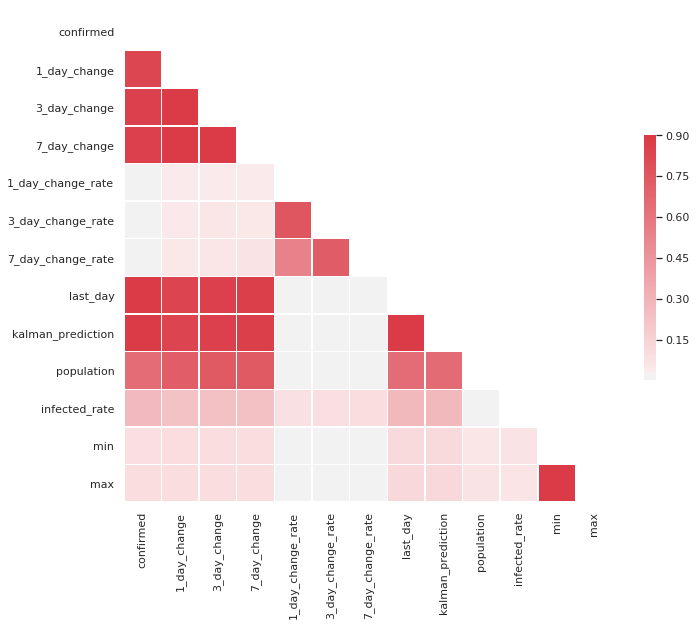

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.837274
3_day_change         0.857106
7_day_change         0.864357
1_day_change_rate    0.020961
3_day_change_rate    0.023299
7_day_change_rate    0.025428
last_day             0.988113
kalman_prediction    0.988982
population           0.650078
infected_rate        0.270263
min                  0.093553
max                  0.102598
Name: confirmed, dtype: float64


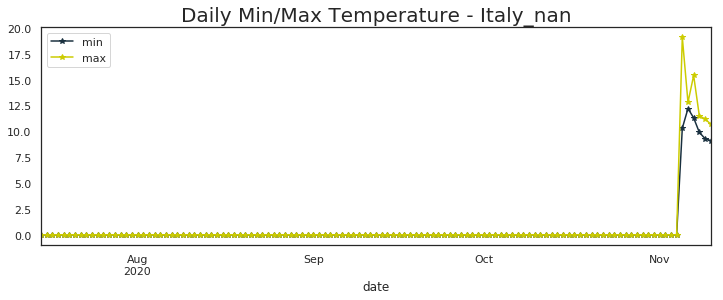

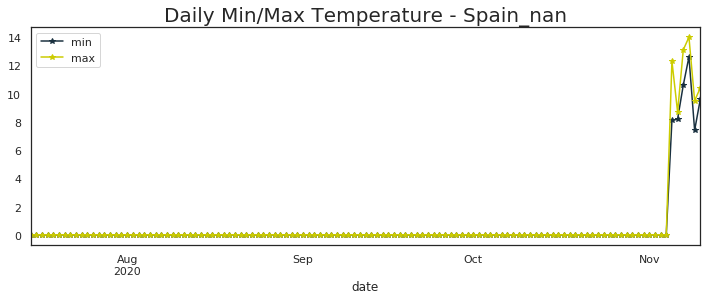

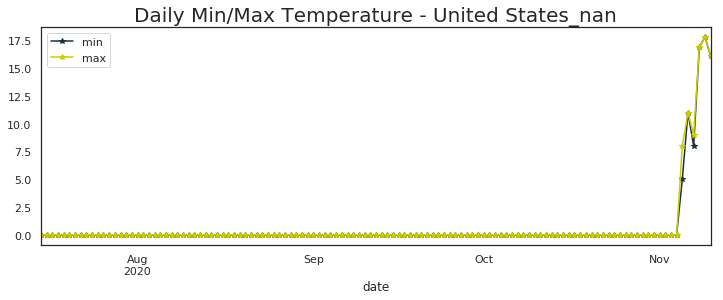

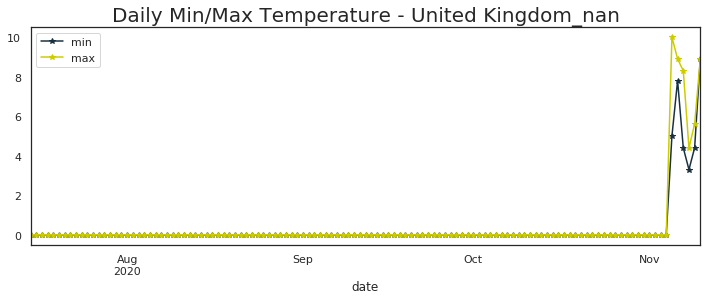

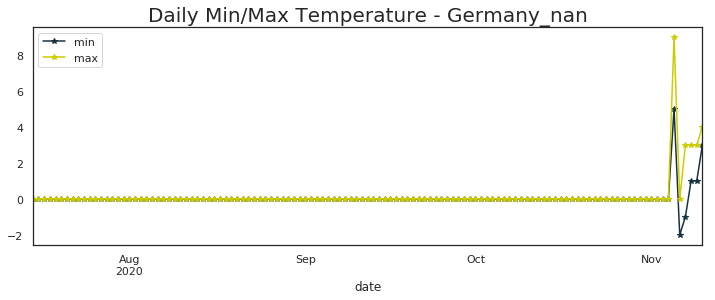

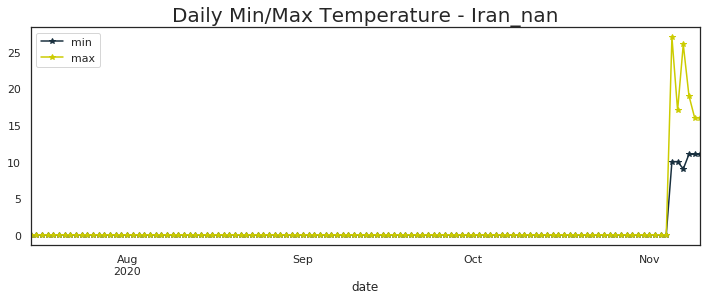

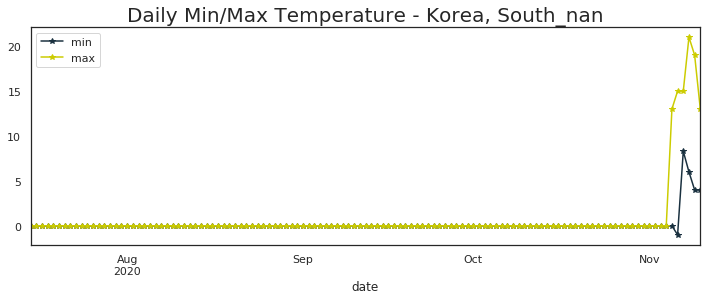

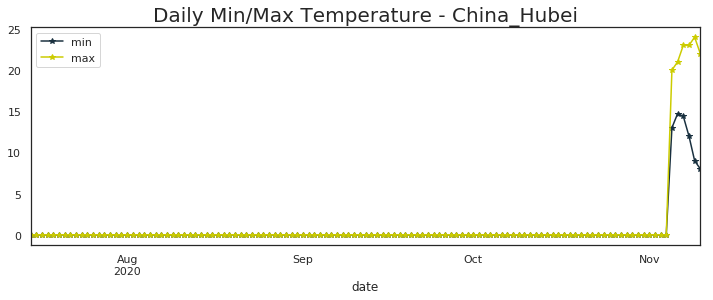

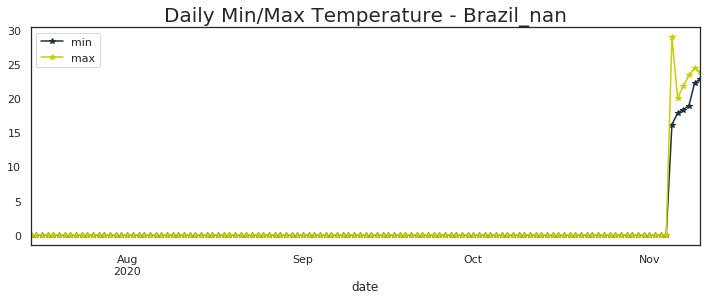

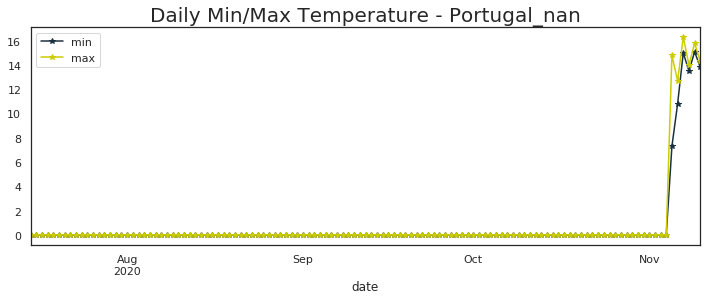

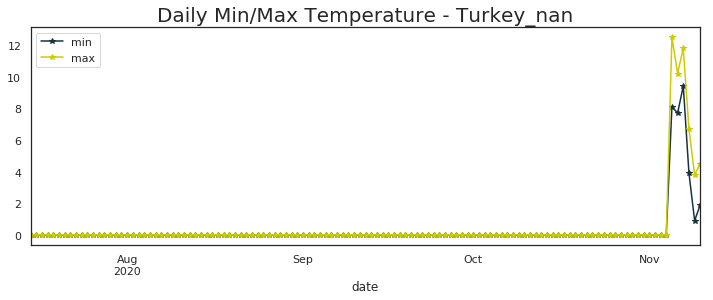

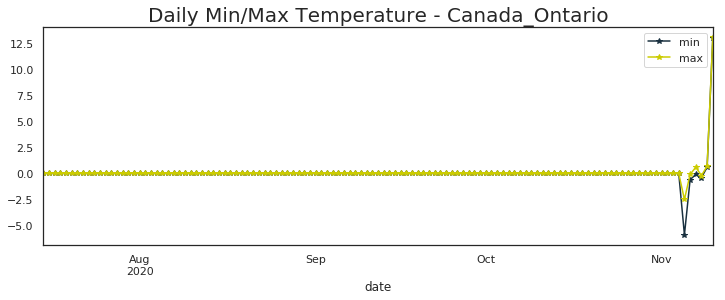

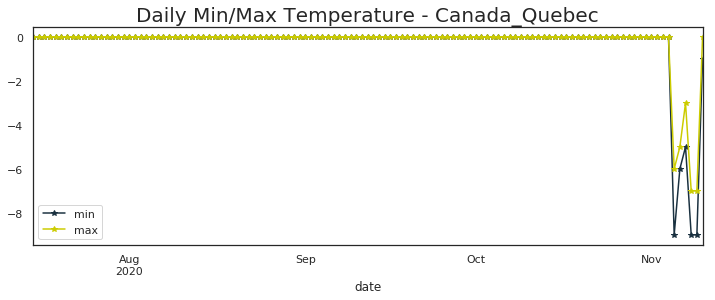

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.8  17.8
India_nan                   14.0  31.0
Brazil_nan                  22.8  28.9
France_nan                  12.1  13.3
Russia_nan                   0.0   4.0
Spain_nan                   12.6  14.0
Argentina_nan                0.0   0.0
United Kingdom_nan           8.9  10.0
Colombia_nan                 0.0   0.0
Mexico_nan                  14.3  14.3
Italy_nan                   12.2  19.1
Peru_nan                    24.6  29.9
South Africa_nan             0.0   0.0
Iran_nan                    11.0  27.0
Germany_nan                  5.0   9.0
Poland_nan                   8.9  10.6
Chile_nan                   16.0  21.0
Belgium_nan                 11.9  13.4
Iraq_nan                     0.0   0.0
Ukraine_nan                  0.0   0.0
Indonesia_nan                0.0   0.0
Bangladesh_nan               0.0   0.0
Czechia_nan                 

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

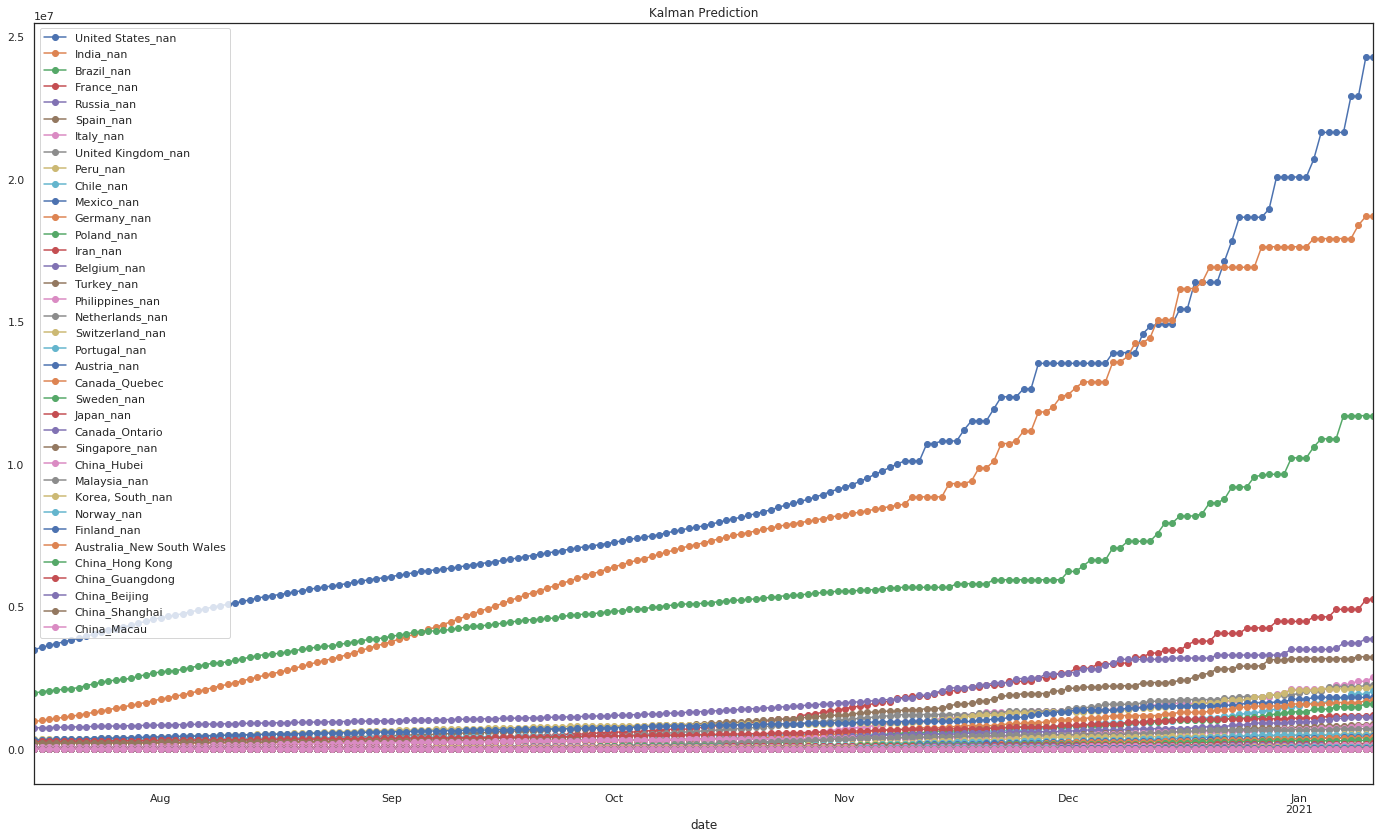

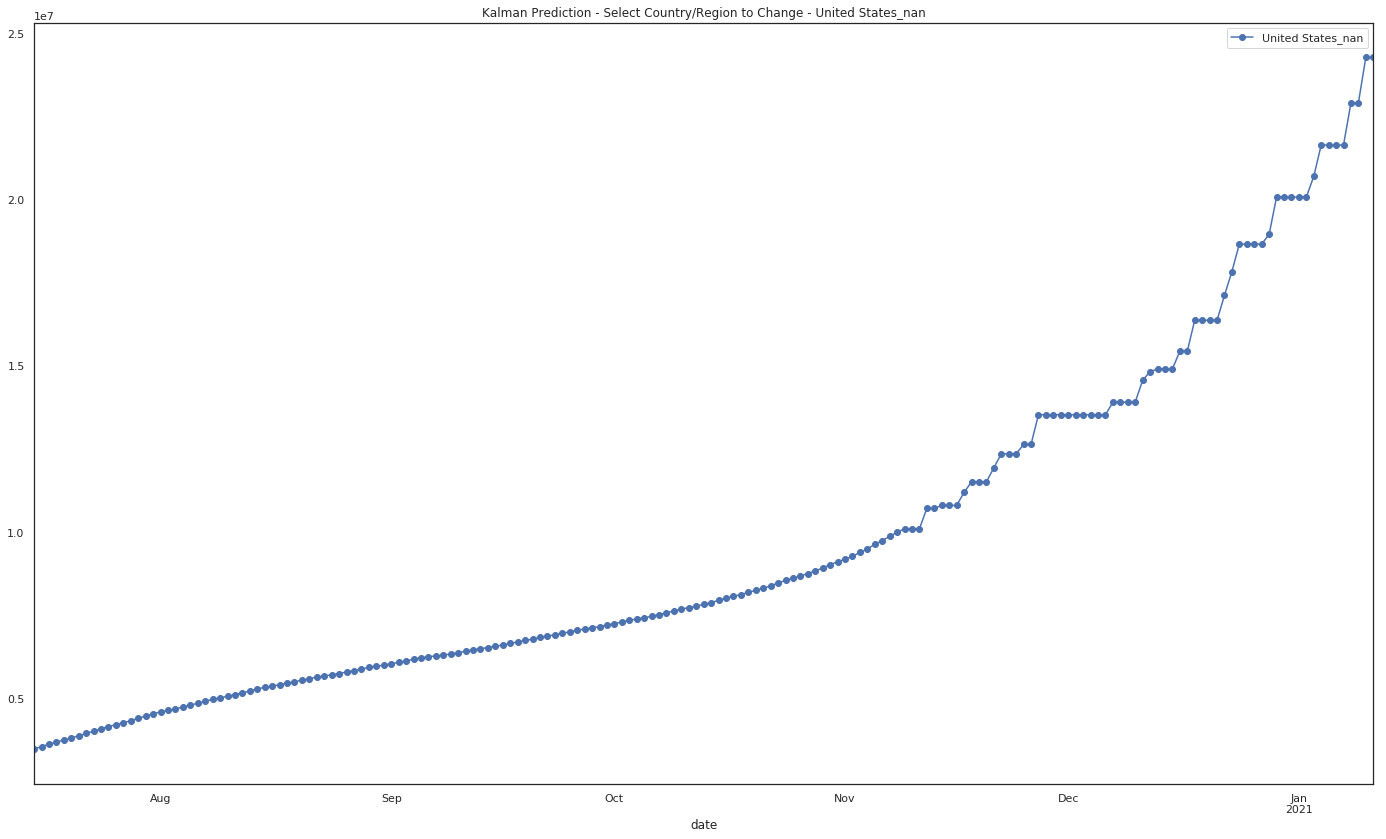

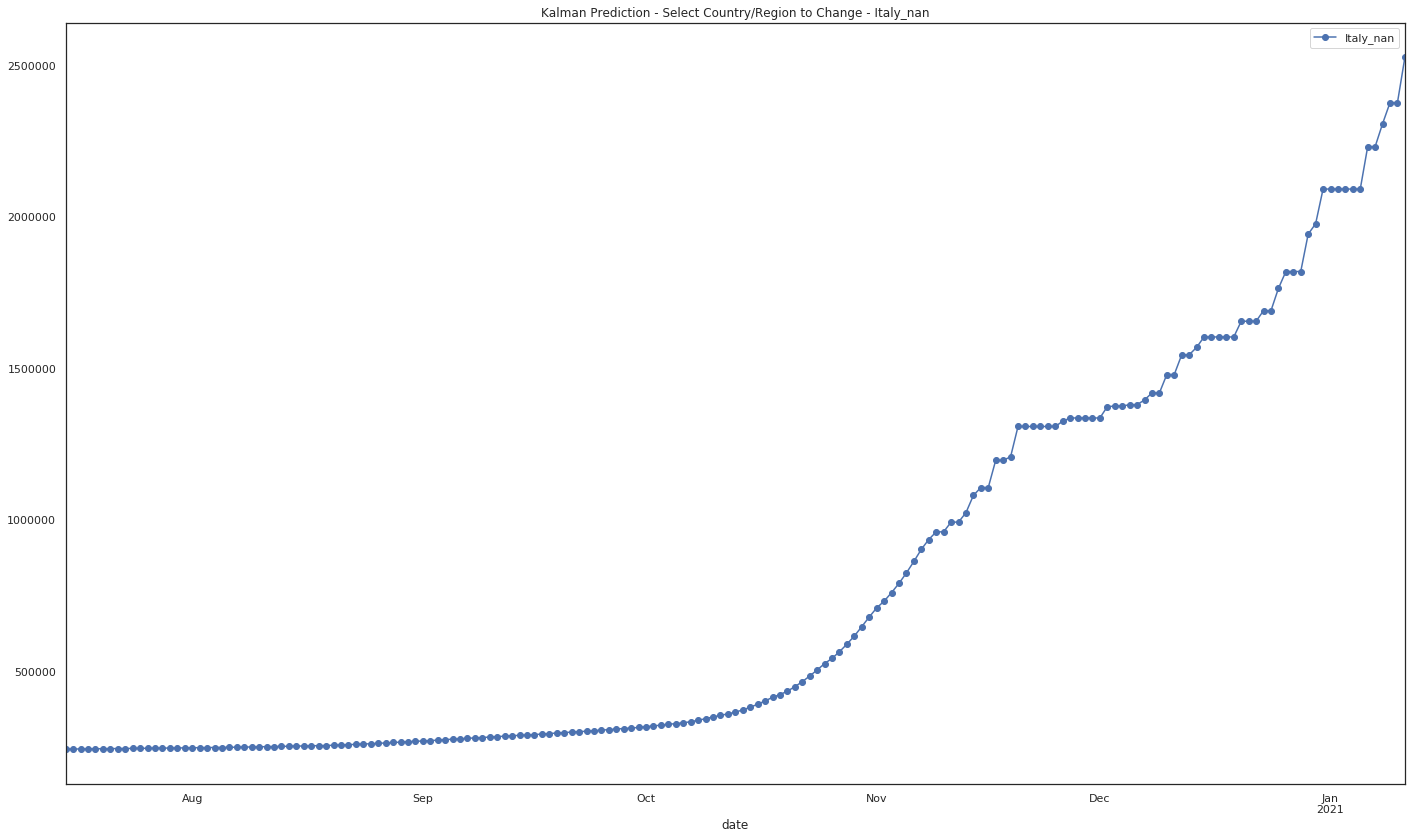

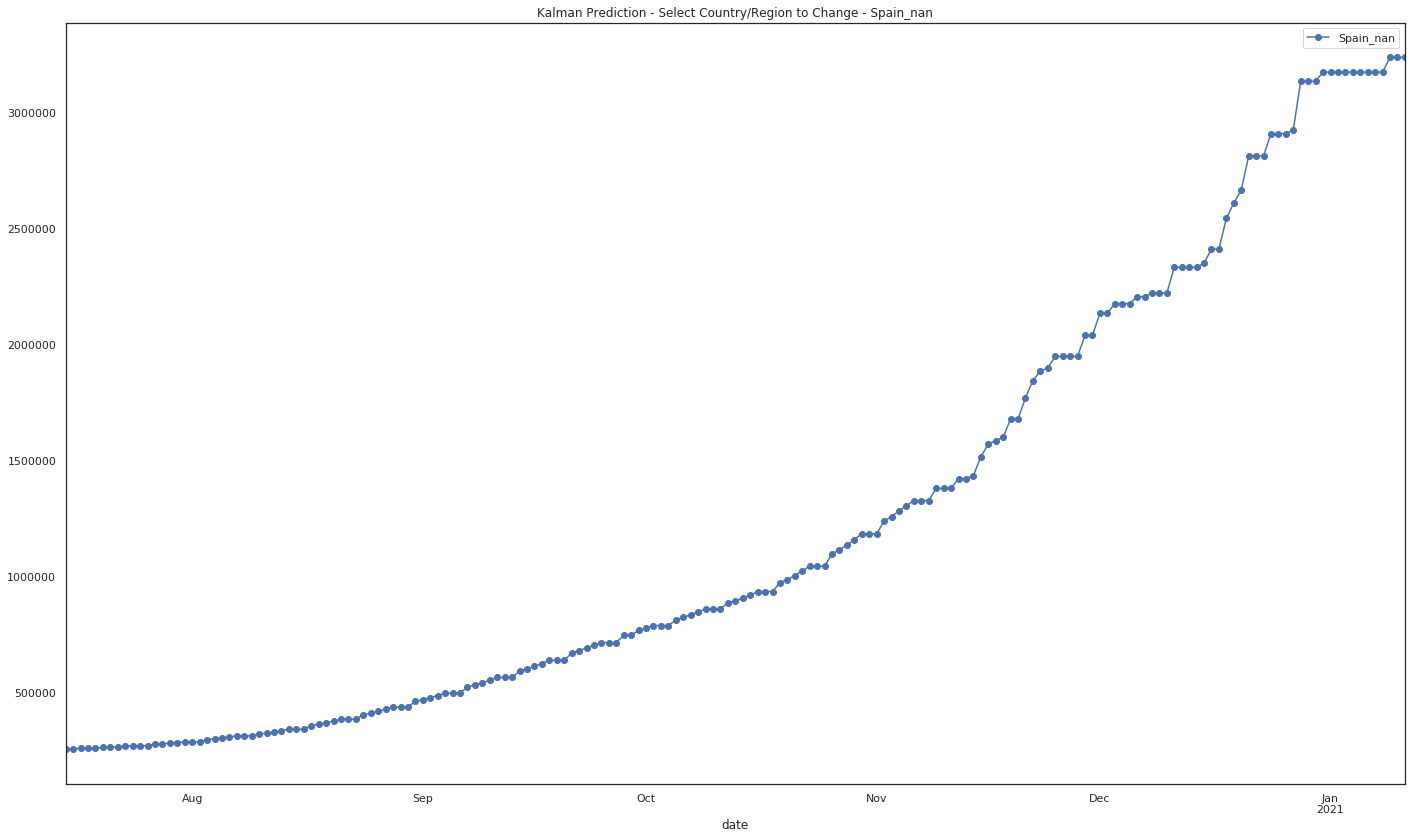

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


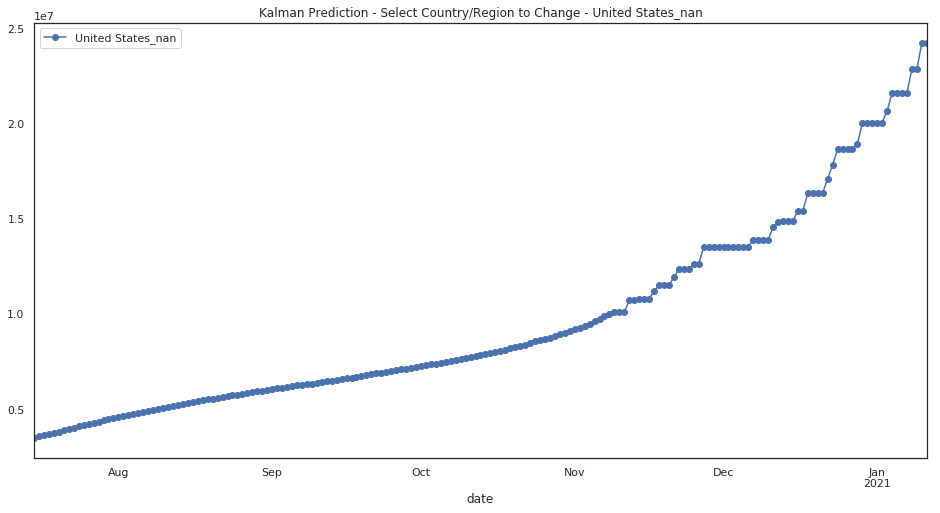

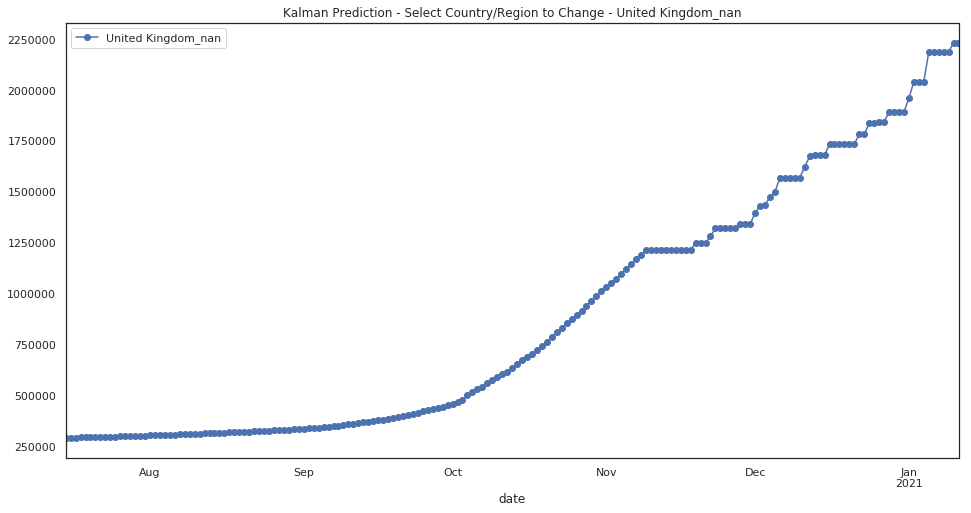

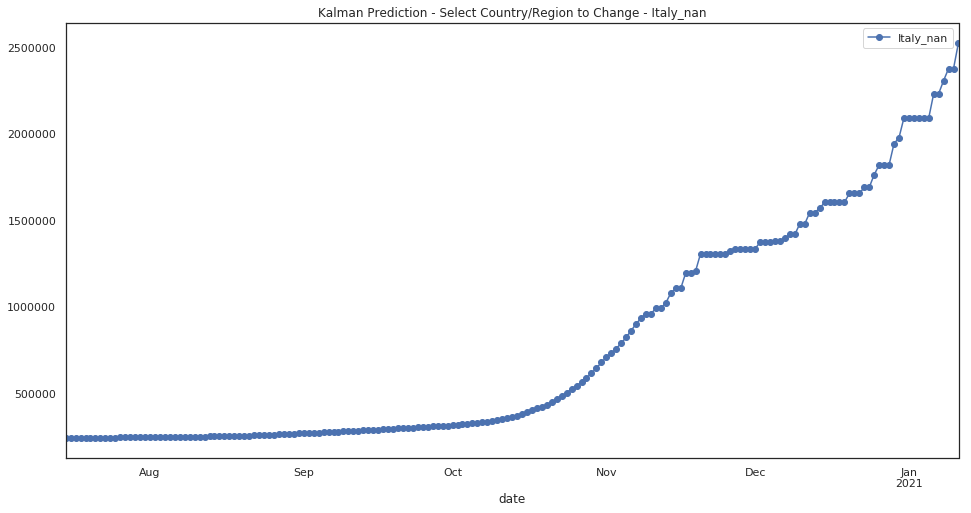

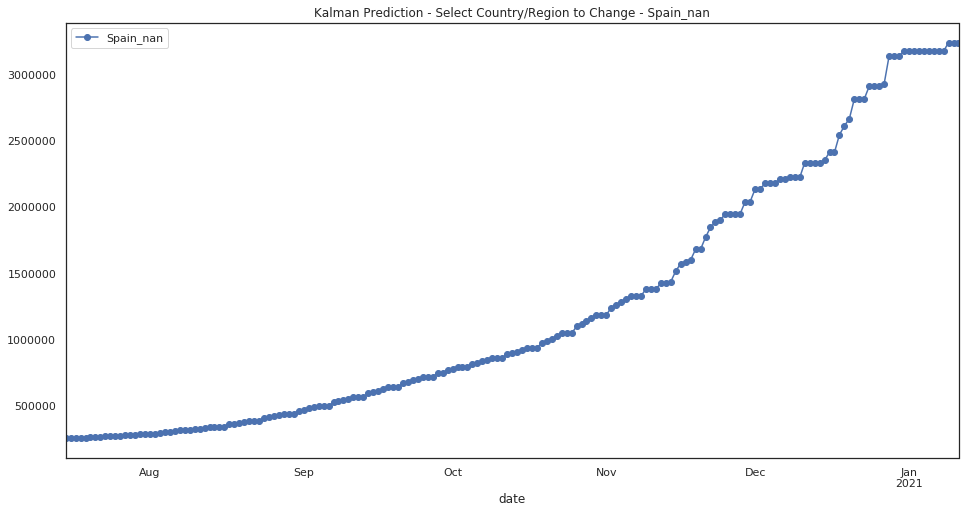

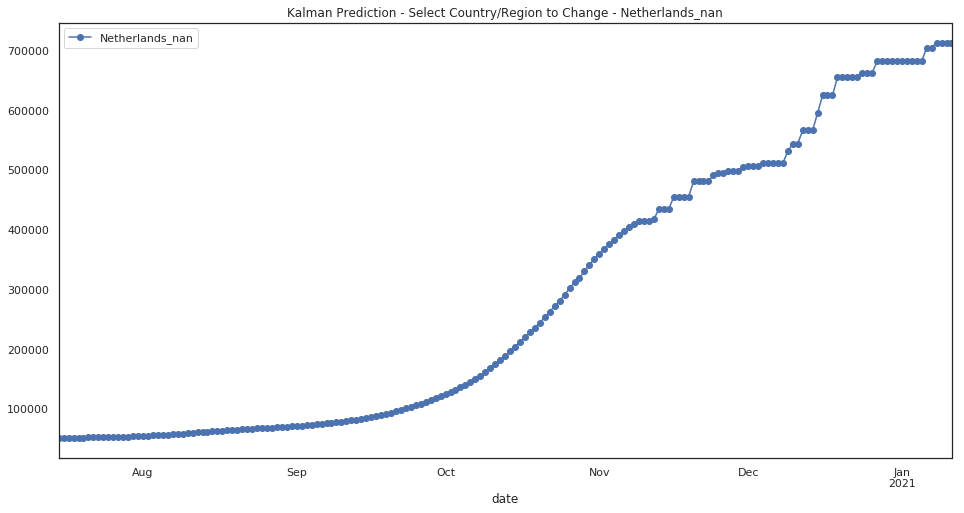

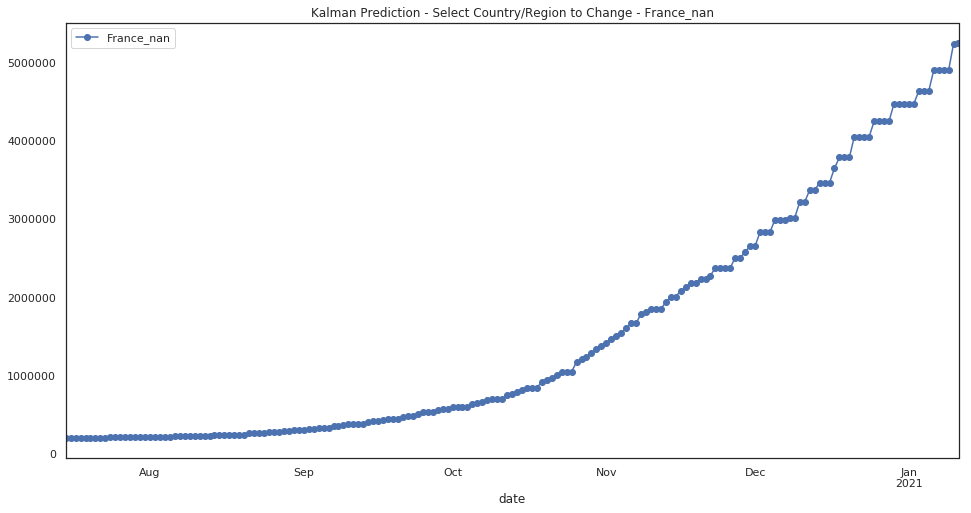

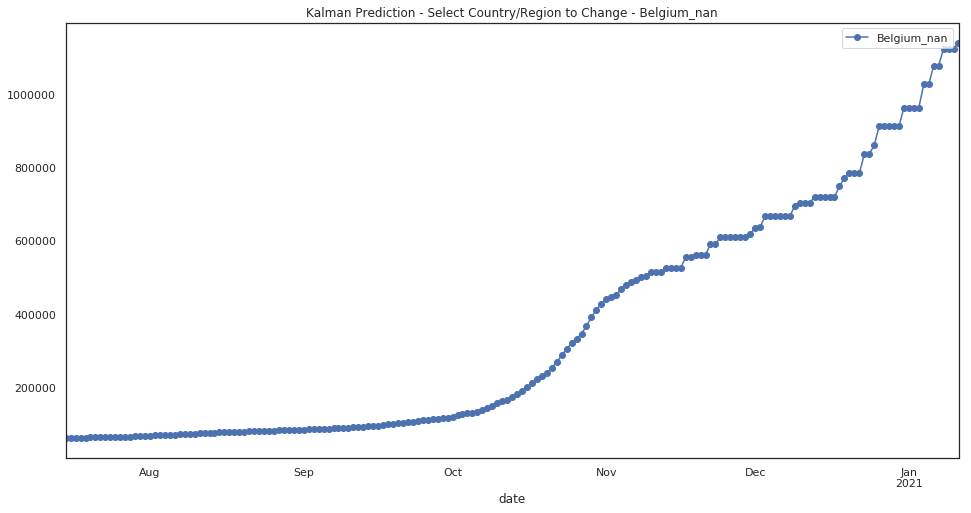

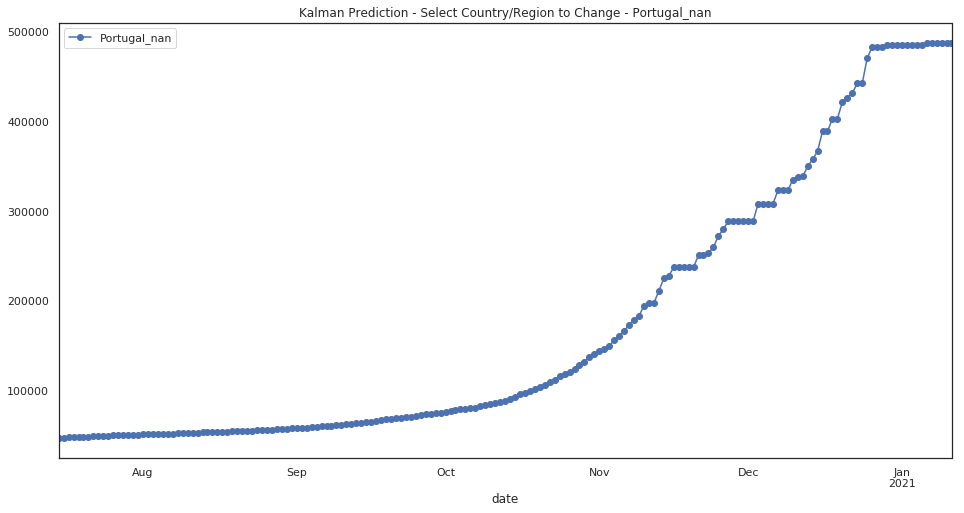

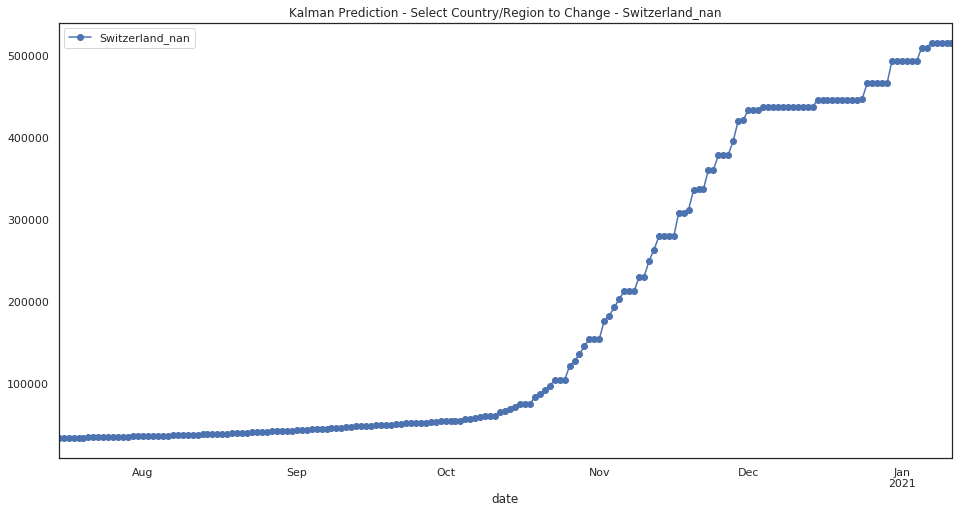

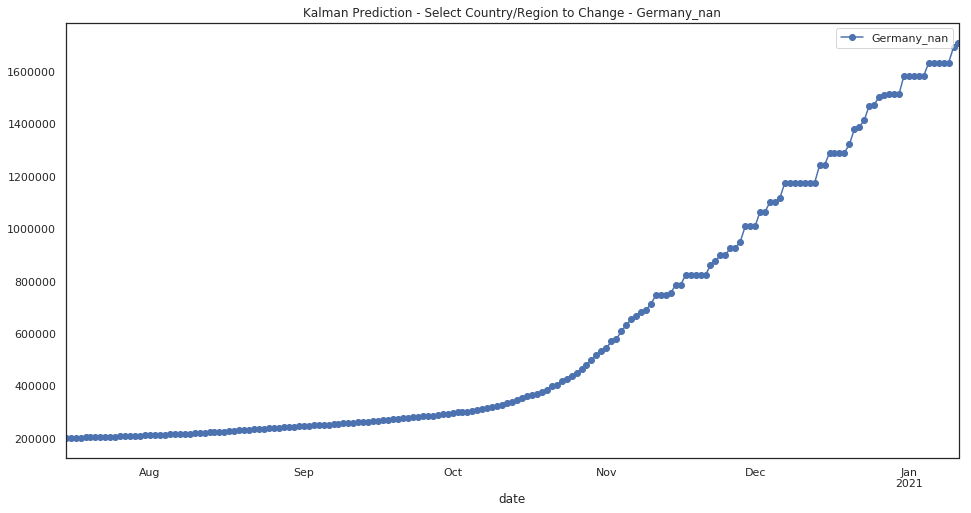

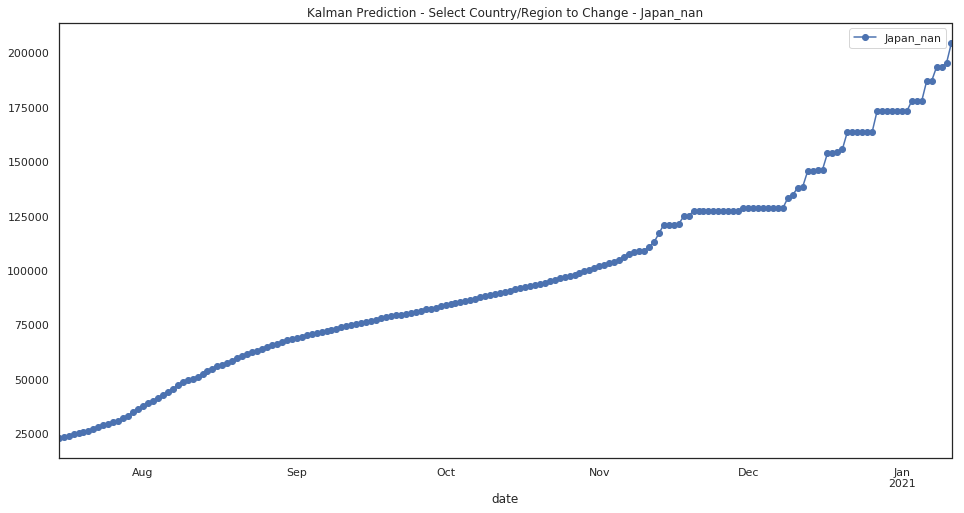

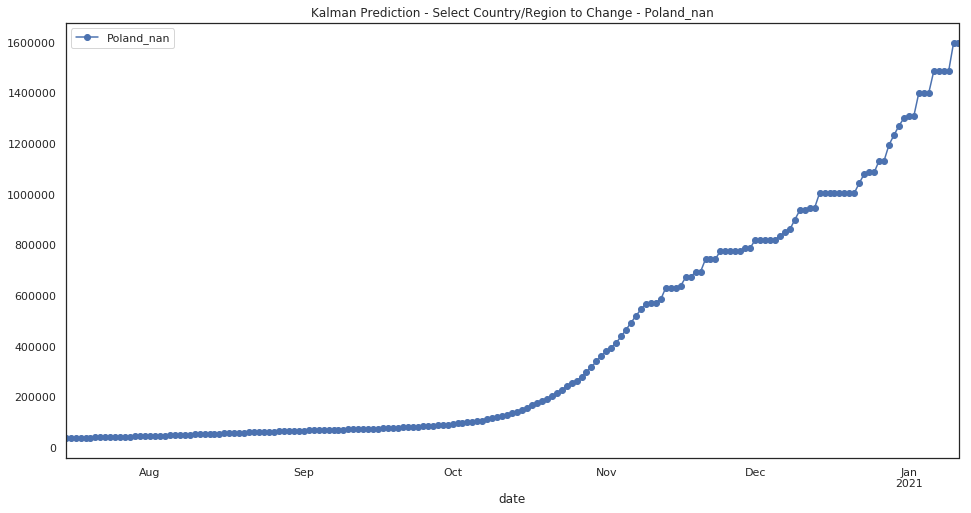

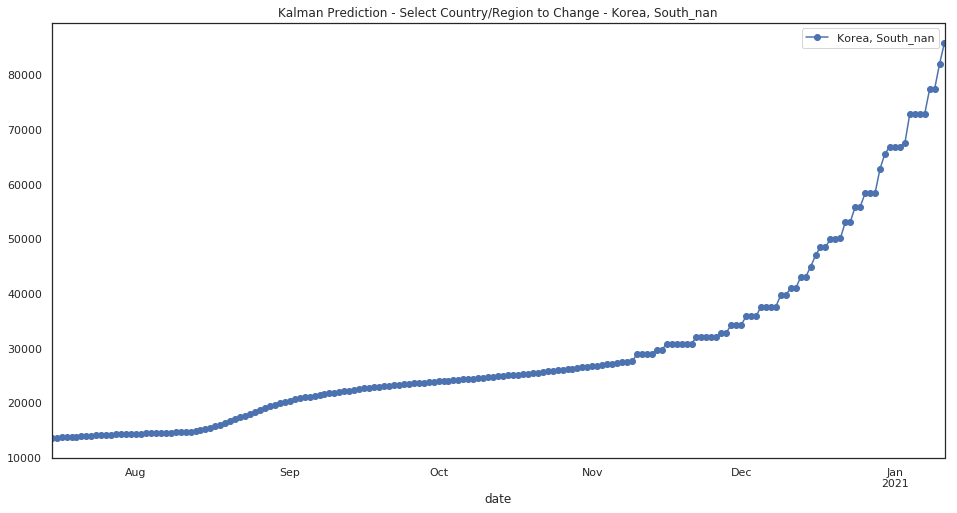

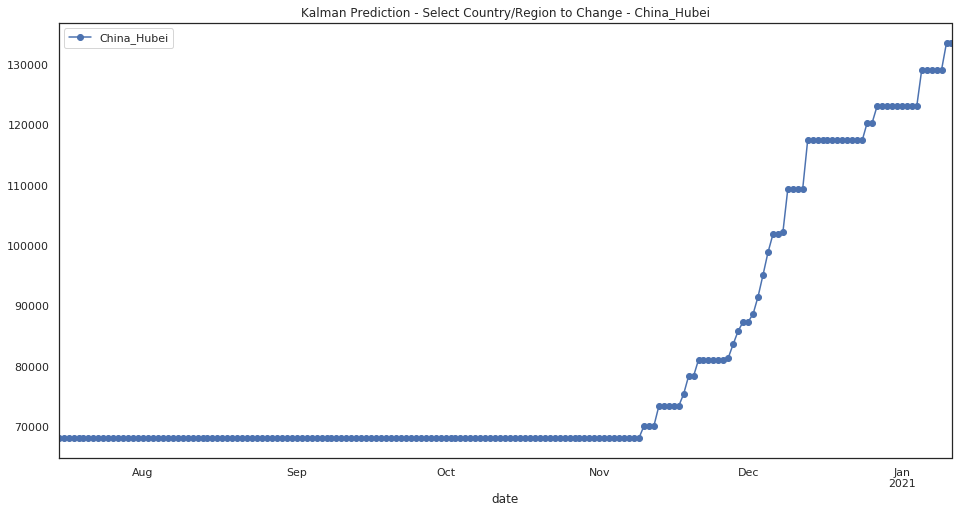

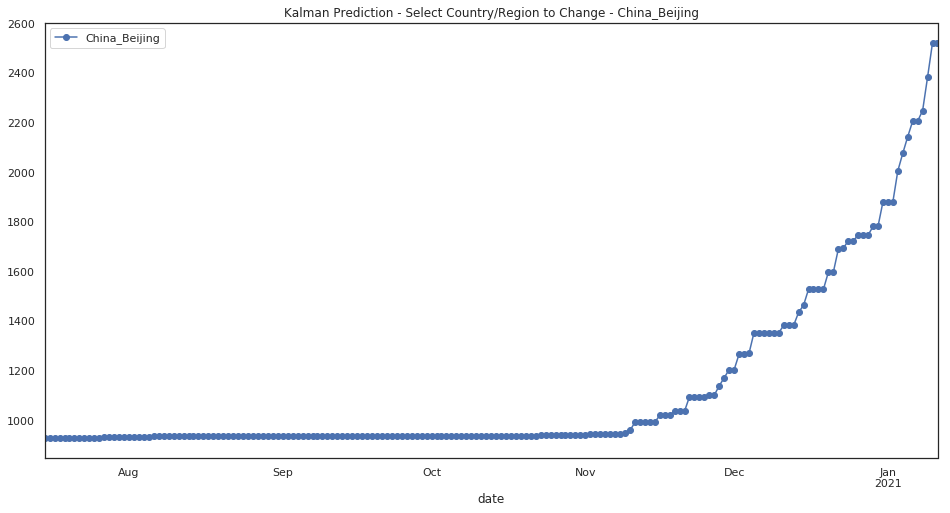

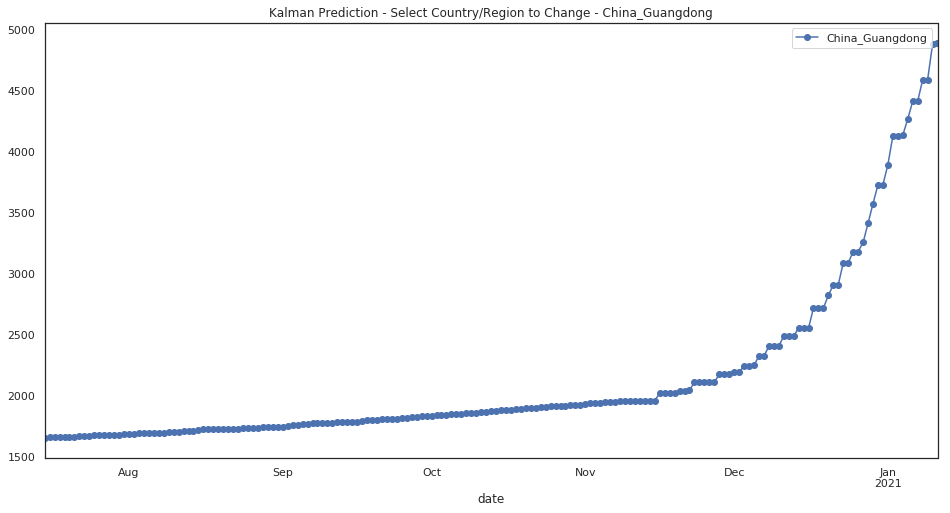

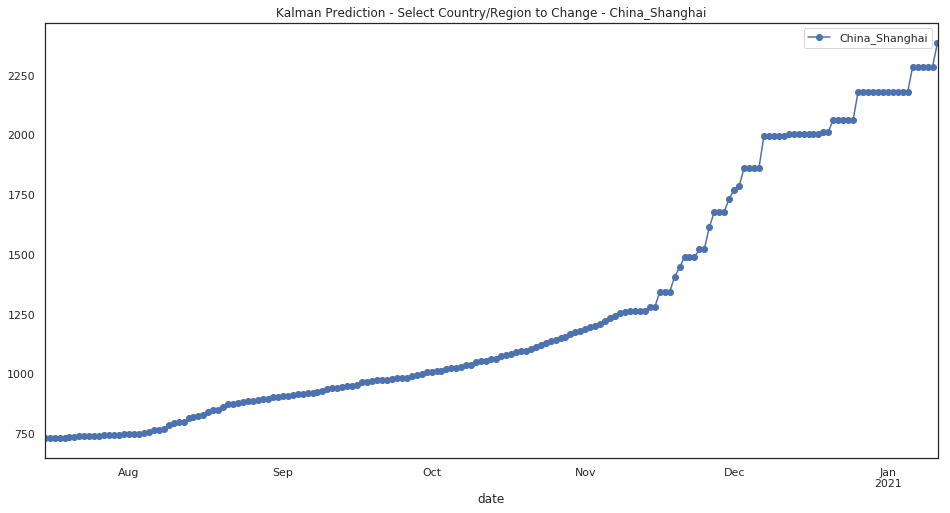

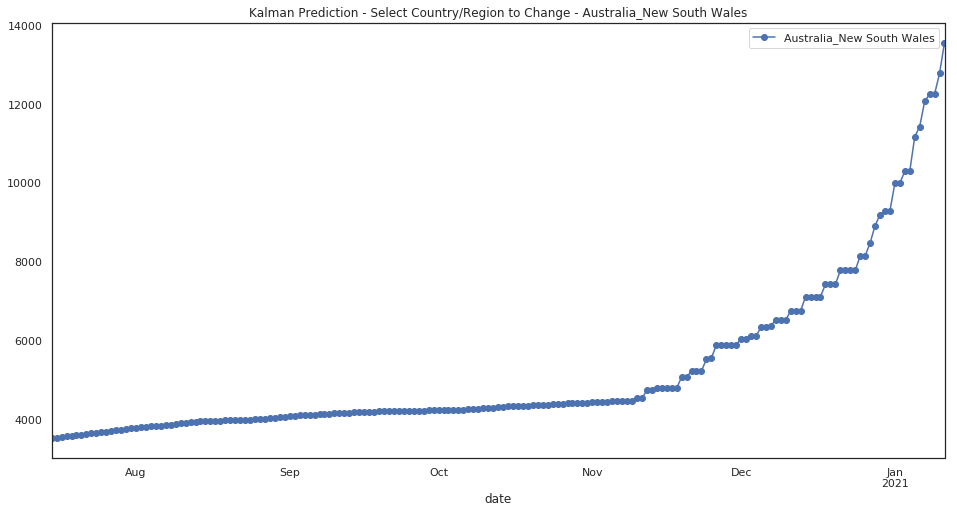

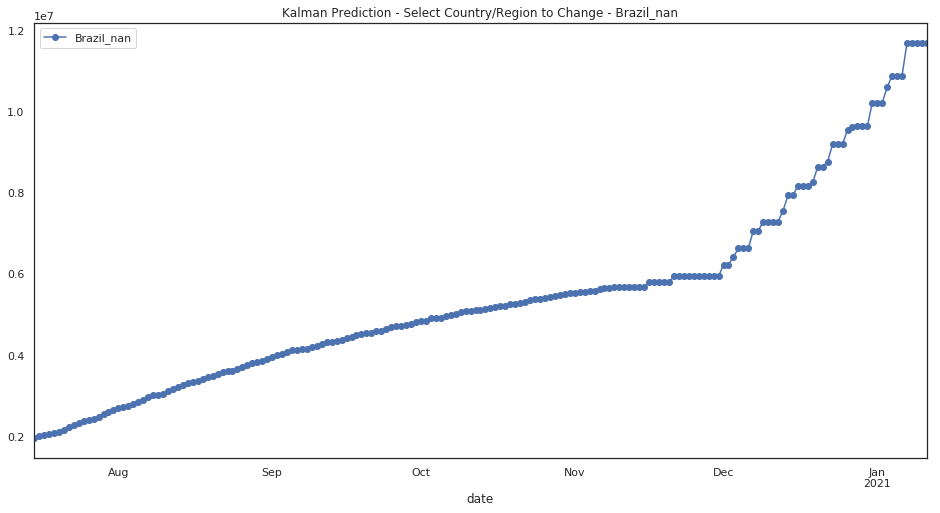

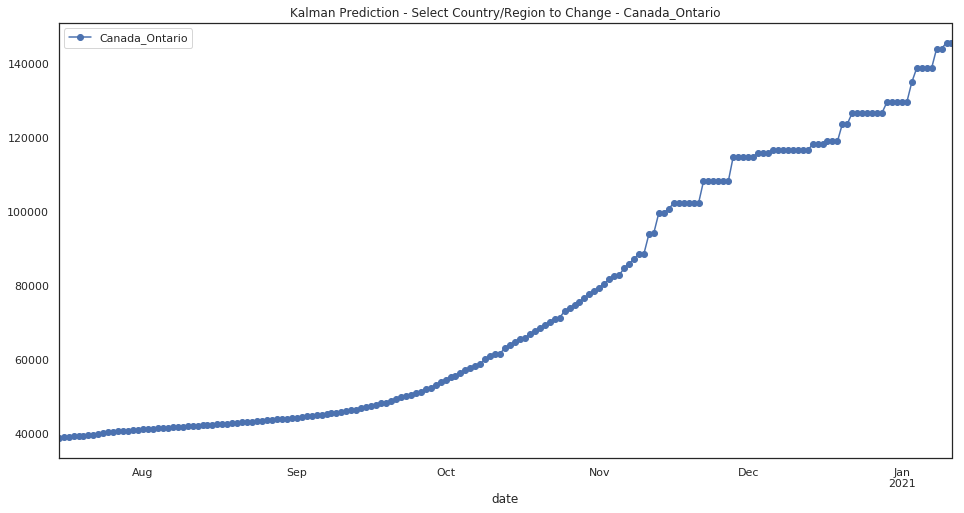

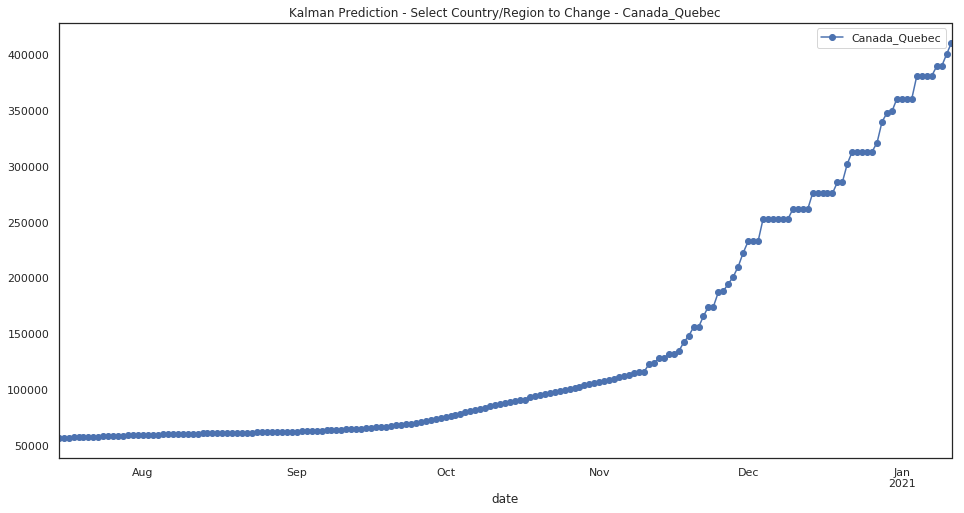

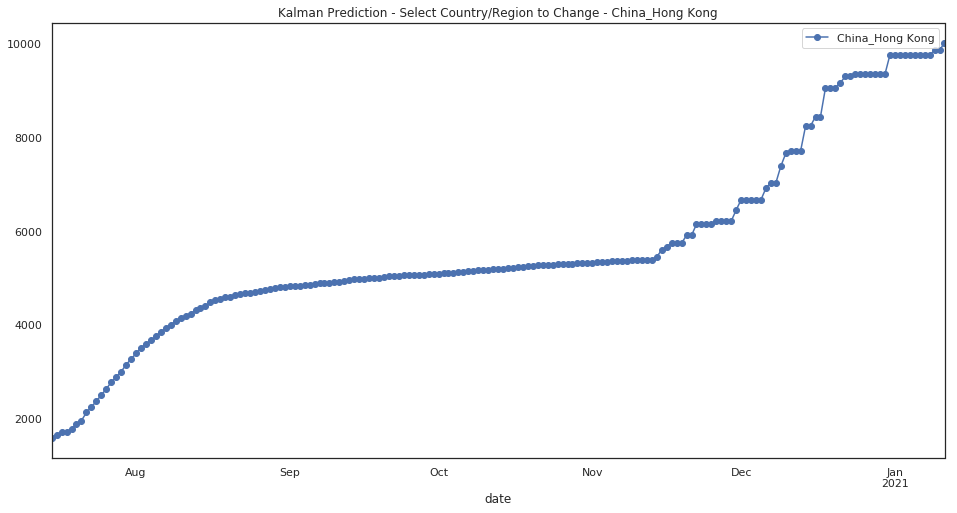

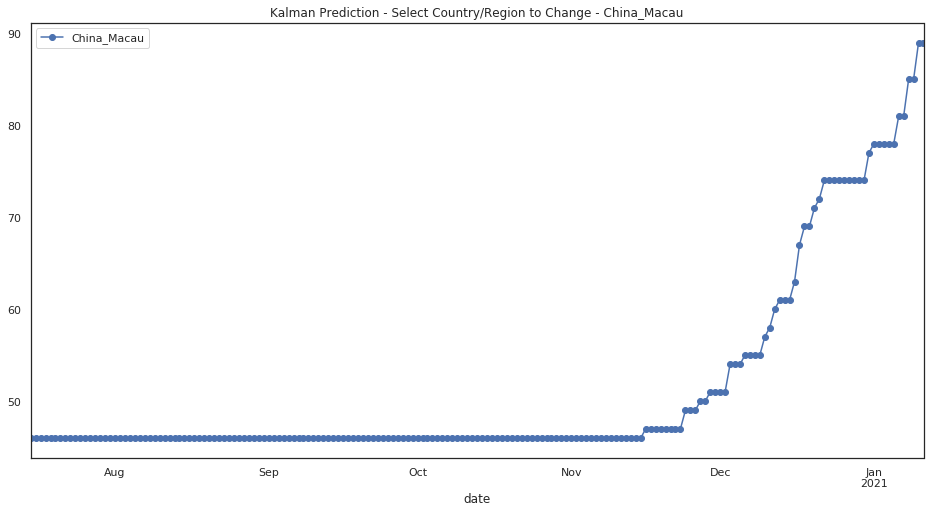

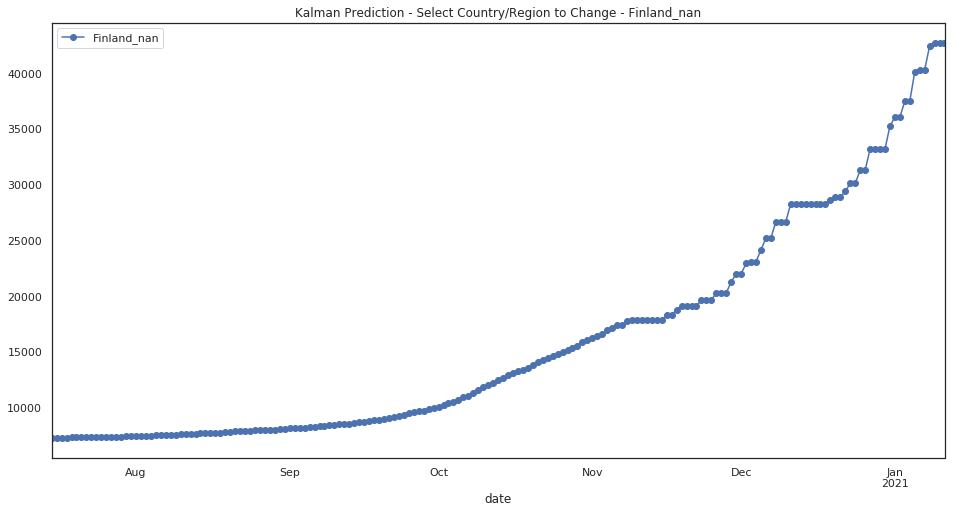

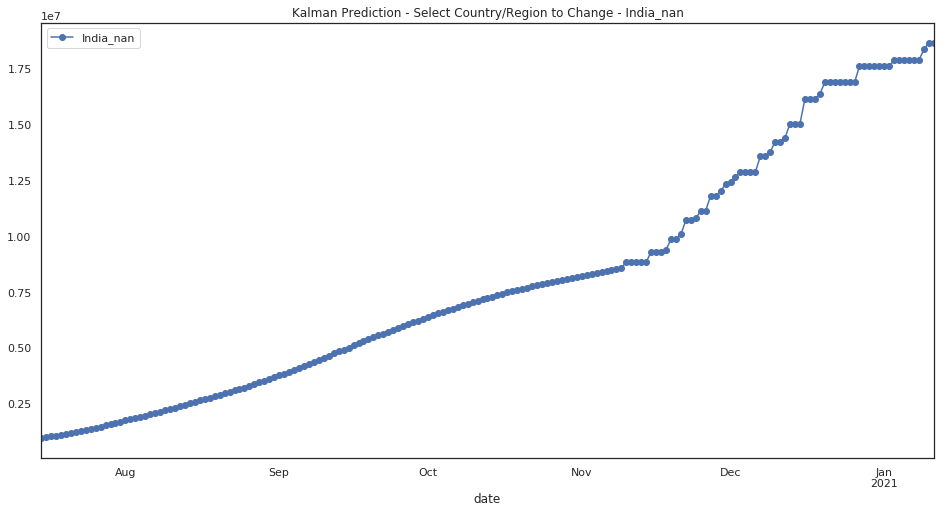

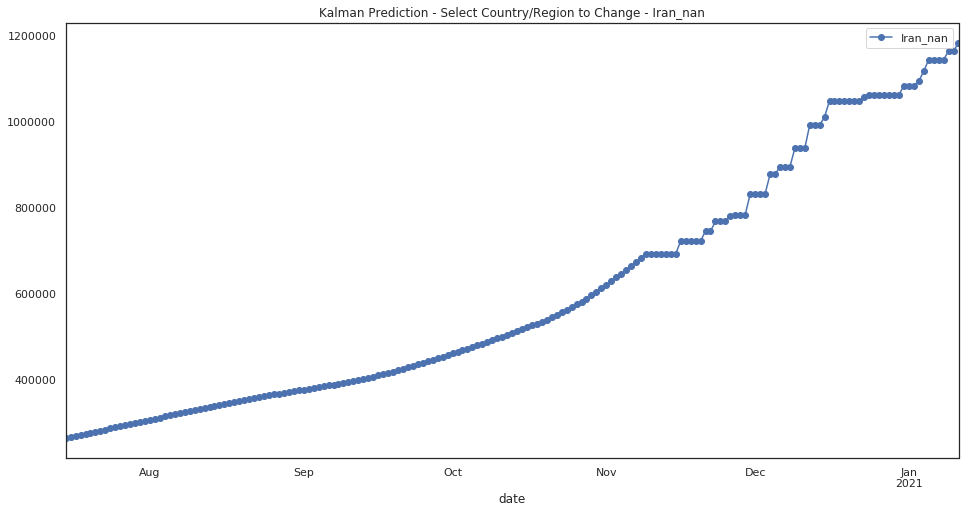

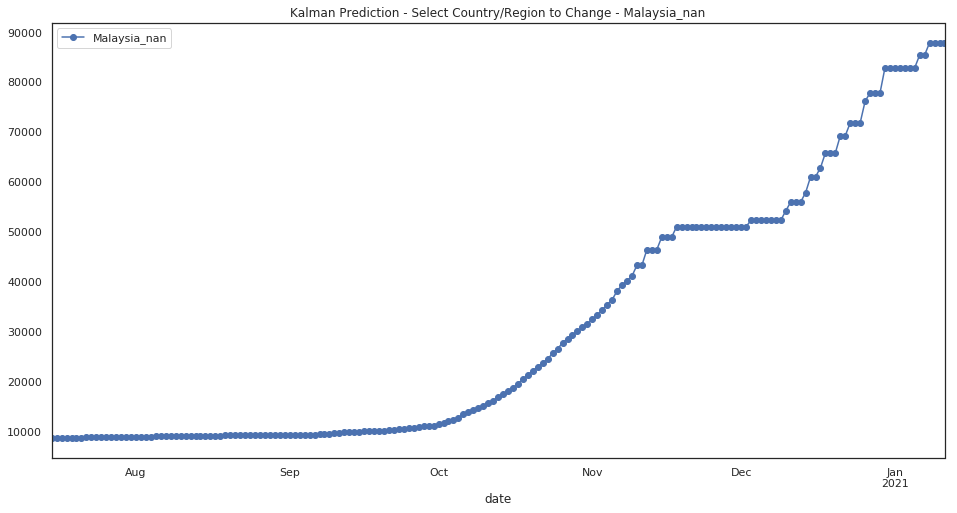

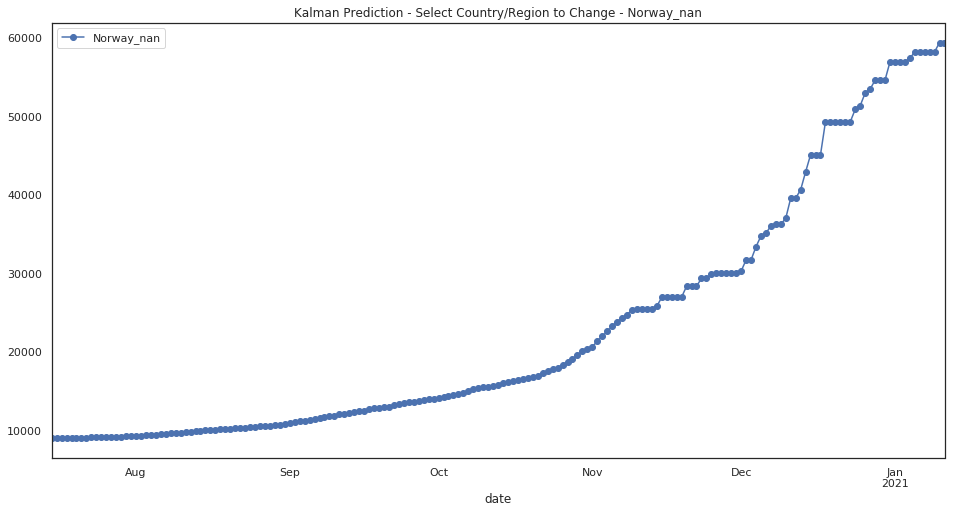

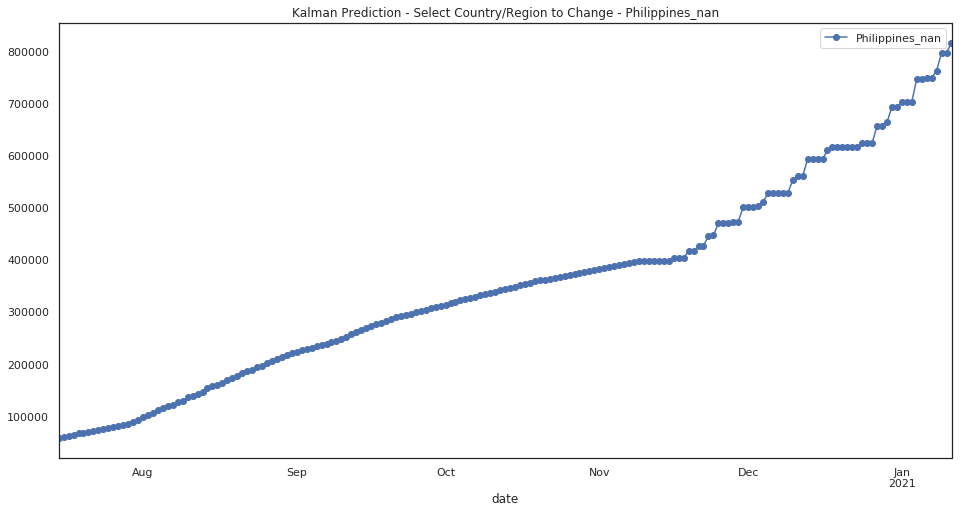

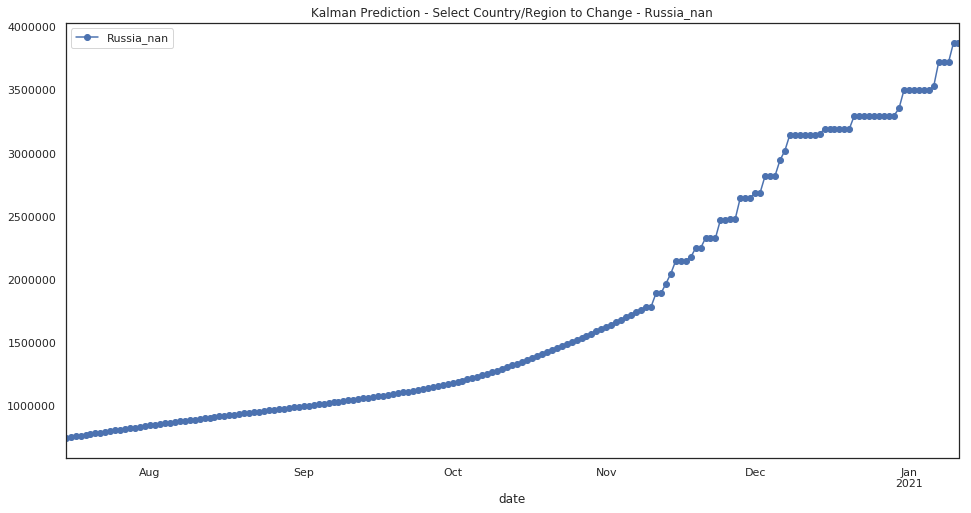

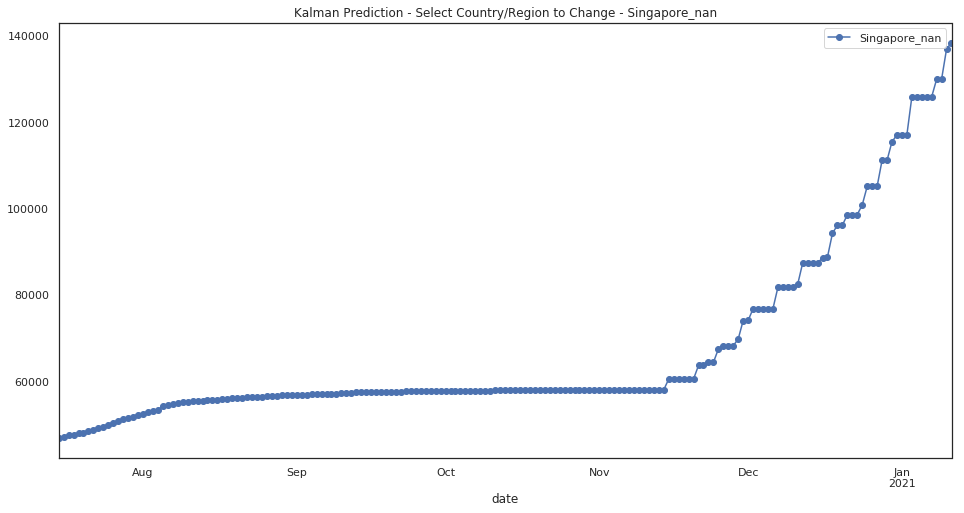

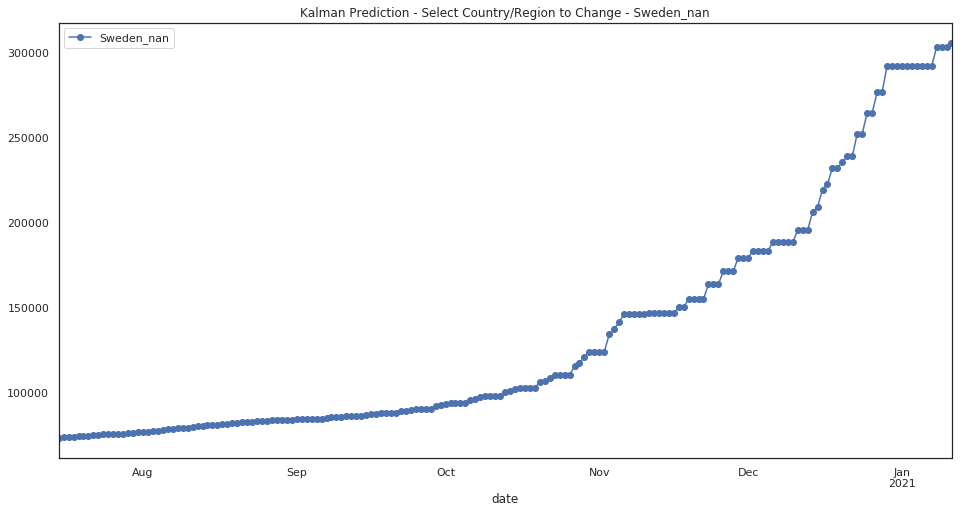

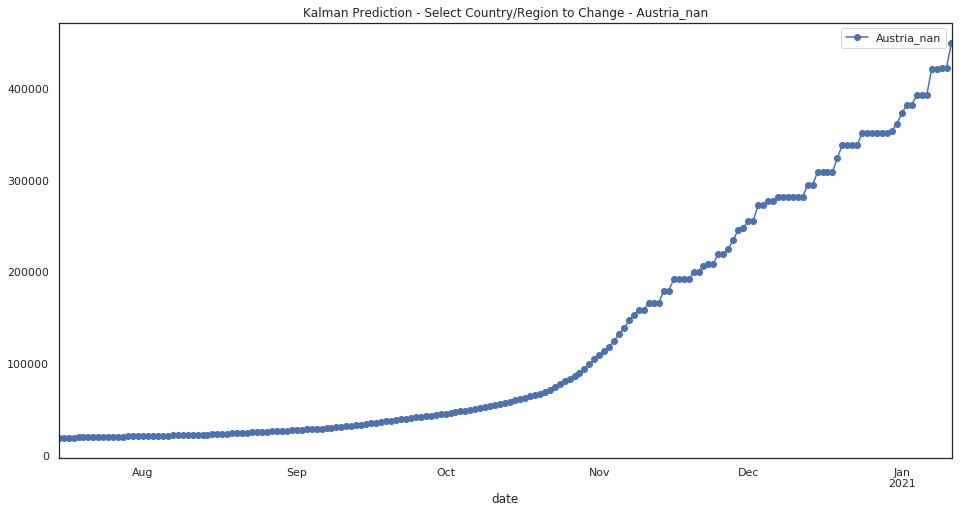

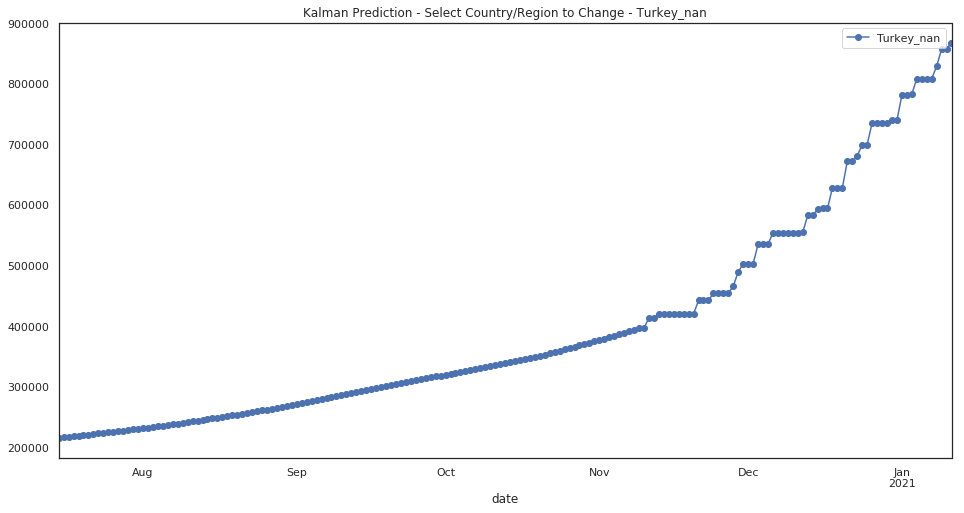

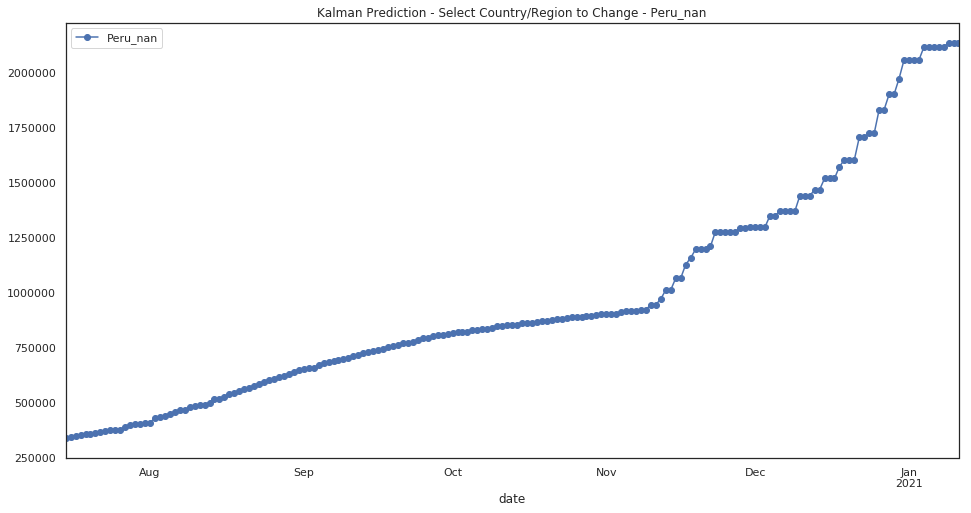

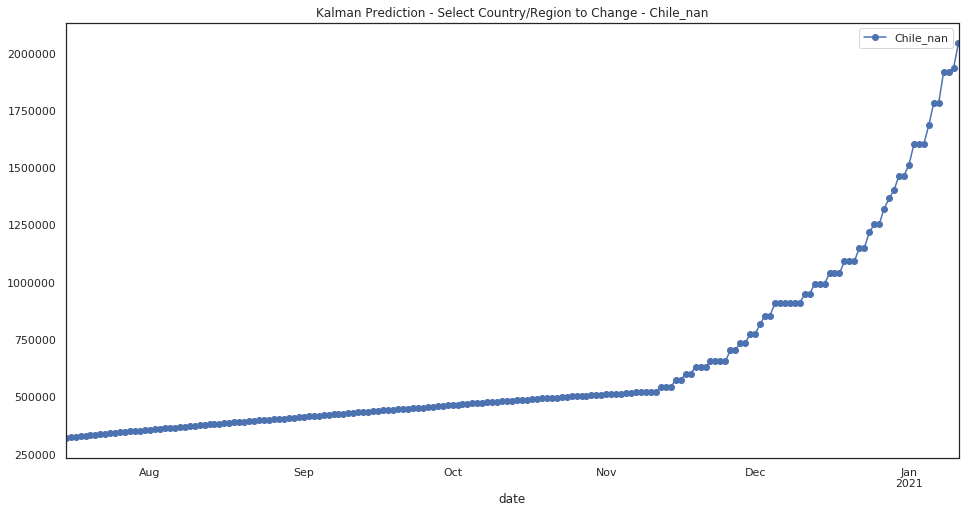

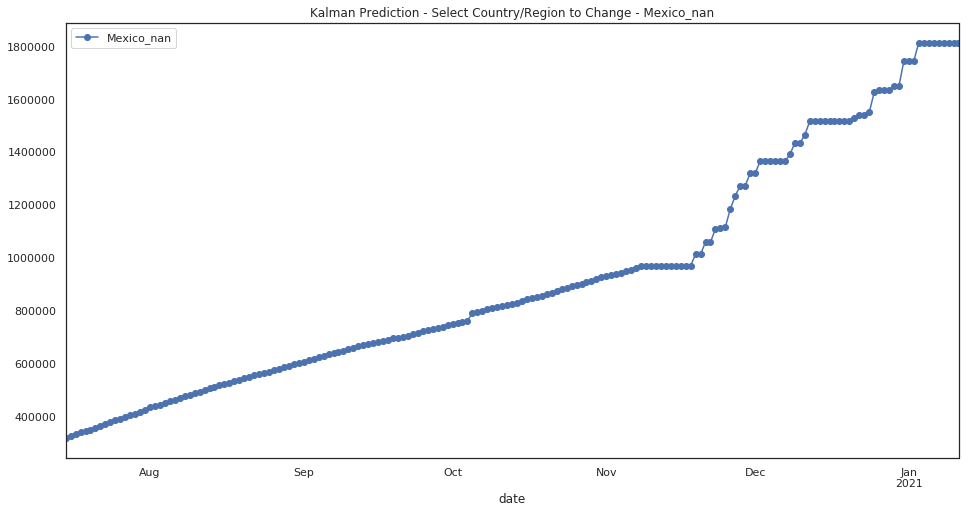

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2021-01-11 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      24271598.0
India_nan                                   NaN      18688246.0
Brazil_nan                                  NaN      11696483.0
France_nan                                  NaN       5258667.0
Russia_nan                                  NaN       3875888.0
Spain_nan                                   NaN       3239157.0
Colombia_nan                                NaN       2971979.0
Argentina_nan                               NaN       2785392.0
Italy_nan                                   NaN       2526474.0
United Kingdom_nan                          NaN       2233455.0
Peru_nan                                    NaN       2137902.0
Chile_nan                                   NaN       2046142.0
Mexico_nan                                  NaN       1813993.0
Germany_nan                                 NaN       1711486.0
Poland_nan                                  NaN       1599288.0
South Africa_nan                            NaN       1473693.0
Indonesia_nan                               NaN       1414258.0
Ukraine_nan                                 NaN       1345287.0
Iran_nan                                    NaN       1183918.0
Belgium_nan                                 NaN       1140979.0
Iraq_nan                                    NaN       1129580.0
Turkey_nan                                  NaN        867992.0
Israel_nan                                  NaN        856866.0
Philippines_nan                             NaN        816558.0
Bangladesh_nan                              NaN        800715.0
Czechia_nan                                 NaN        761641.0
Netherlands_nan                             NaN        713514.0
Romania_nan                                 NaN        677237.0
Saudi Arabia_nan                            NaN        666838.0
Morocco_nan                                 NaN        548511.0
...                                         ...             ...
France_Saint Barthelemy                     NaN           191.0
Saint Vincent and the Grenadines_nan        NaN           170.0
Canada_Prince Edward Island                 NaN           169.0
China_Ningxia                               NaN           164.0
United Kingdom_British Virgin Islands       NaN           137.0
Dominica_nan                                NaN           119.0
Australia_Northern Territory                NaN            93.0
China_Macau                                 NaN            89.0
Fiji_nan                                    NaN            76.0
Grenada_nan                                 NaN            65.0
France_New Caledonia                        NaN            64.0
Laos_nan                                    NaN            64.0
Canada_Yukon                                NaN            53.0
Timor-Leste_nan                             NaN            48.0
China_Qinghai                               NaN            46.0
Holy See_nan                                NaN            42.0
France_Saint Pierre and Miquelon            NaN            41.0
Saint Kitts and Nevis_nan                   NaN            40.0
United Kingdom_Falkland Islands (Malvinas)  NaN            39.0
Denmark_Greenland                           NaN            30.0
United Kingdom_Montserrat                   NaN            29.0
Solomon Islands_nan                         NaN            27.0
Canada_Grand Princess                       NaN            19.0
Western Sahara_nan                          NaN            10.0
Canada_Northwest Territories                NaN            10.0
MS Zaandam_nan                              NaN             9.0
United Kingdom_Anguilla                     NaN             3.0
Marshall Islands_nan                        NaN             2.0
China_Tibet                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[268 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          45860.0      18695.0      33492.0      16182.0   
2020-07-16          45926.0      18781.0      34001.0      16195.0   
2020-07-17          35070.0       3851.0      21355.0        877.0   
2020-07-18          35229.0       3906.0      21948.0        880.0   
2020-07-19          35301.0       4008.0      22549.0        880.0   
2020-07-20          35475.0       4090.0      23084.0        880.0   
2020-07-21          35526.0       4171.0      23691.0        884.0   
2020-07-22          35615.0       4290.0      24278.0        884.0   
2020-07-23          36021.0       4482.0      25443.0        914.0   
2020-07-24          36072.0       4466.0      26106.0       1000.0   
2020-07-25          36177.0       4570.0      26698.0        897.0   
2020-07-26          36285.0       4793.0      27338.0       1005.0   
2020-07-27          36363.0       4763.0      27963.0       1014.0   
2020-07-28          36478.0       4881.0      28590.0        907.0   
2020-07-29          36584.0       5003.0      29203.0       1029.0   
2020-07-30          36659.0       5135.0      29827.0        918.0   
2020-07-31          36791.0       5264.0      30404.0        974.0   
2020-08-01          36820.0       5412.0      30974.0        991.0   
2020-08-02          36855.0       5422.0      31495.0       1037.0   
2020-08-03          36893.0       5526.0      32017.0       1046.0   
2020-08-04          36908.0       5721.0      32545.0        937.0   
2020-08-05          36953.0       5783.0      33080.0       1022.0   
2020-08-06          37015.0       5898.0      33643.0       1054.0   
2020-08-07          37121.0       6078.0      34175.0        974.0   
2020-08-08          37157.0       6194.0      34730.0        955.0   
2020-08-09          37190.0       6360.0      35204.0       1070.0   
2020-08-10          37294.0       6463.0      35767.0       1075.0   
2020-08-11          37363.0       6634.0      36238.0        963.0   
2020-08-12          37449.0       6745.0      36753.0       1082.0   
2020-08-13          37544.0       6900.0      37243.0        977.0   
...                     ...          ...          ...          ...   
2020-12-14          58394.0      34151.0      84498.0       9811.0   
2020-12-15          58495.0      34557.0      86641.0       9811.0   
2020-12-16          60151.0      34899.0      86843.0       9811.0   
2020-12-17          60274.0      35962.0      87106.0       9983.0   
2020-12-18          62344.0      35835.0      87762.0       9983.0   
2020-12-19          63648.0      36041.0      91853.0      10117.0   
2020-12-20          63951.0      37944.0      92391.0      10117.0   
2020-12-21          65572.0      38051.0      92856.0      10117.0   
2020-12-22          68020.0      39112.0      92817.0      10449.0   
2020-12-23          71354.0      39015.0      92541.0      10672.0   
2020-12-24          71950.0      40473.0      96574.0      10900.0   
2020-12-25          73491.0      40486.0      97040.0      10900.0   
2020-12-26          77278.0      43004.0     100718.0      10900.0   
2020-12-27          77541.0      43110.0     101069.0      10900.0   
2020-12-28          78123.0      43683.0     102409.0      10993.0   
2020-12-29          78034.0      43787.0     102575.0      10993.0   
2020-12-30          79645.0      45527.0     102498.0      10993.0   
2020-12-31          83381.0      45661.0     108221.0      10993.0   
2021-01-01          83963.0      45920.0     108860.0      10993.0   
2021-01-02          85672.0      46281.0     113477.0      10993.0   
2021-01-03          90134.0      46078.0     118122.0      10993.0   
2021-01-04          90525.0      46184.0     118718.0      10993.0   
2021-01-05          93122.0      47274.0     118976.0      10993.0   
2021-01-06          93280.0      48811.0     123325.0      10993.0   
2021-01-07

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'Russia_nan',
 'Spain_nan',
 'Colombia_nan',
 'Argentina_nan',
 'Italy_nan',
 'United Kingdom_nan',
 'Peru_nan',
 'Chile_nan',
 'Mexico_nan',
 'Germany_nan',
 'Poland_nan',
 'South Africa_nan',
 'Indonesia_nan',
 'Ukraine_nan',
 'Iran_nan',
 'Belgium_nan',
 'Iraq_nan',
 'Turkey_nan',
 'Israel_nan',
 'Philippines_nan',
 'Bangladesh_nan',
 'Czechia_nan',
 'Netherlands_nan',
 'Romania_nan',
 'Saudi Arabia_nan',
 'Morocco_nan',
 'Pakistan_nan',
 'Switzerland_nan',
 'Portugal_nan',
 'Austria_nan',
 'Dominican Republic_nan',
 'Canada_Quebec',
 'Nepal_nan',
 'Belarus_nan',
 'United Arab Emirates_nan',
 'Ecuador_nan',
 'Sweden_nan',
 'Panama_nan',
 'Qatar_nan',
 'Kazakhstan_nan',
 'Bolivia_nan',
 'Ethiopia_nan',
 'Guatemala_nan',
 'Armenia_nan',
 'Serbia_nan',
 'Oman_nan',
 'Libya_nan',
 'Costa Rica_nan',
 'Kuwait_nan',
 'Hungary_nan',
 'Honduras_nan',
 'Bulgaria_nan',
 'Jordan_nan',
 'Moldova_nan',
 'Japan_nan',
 'Azerbaijan_n

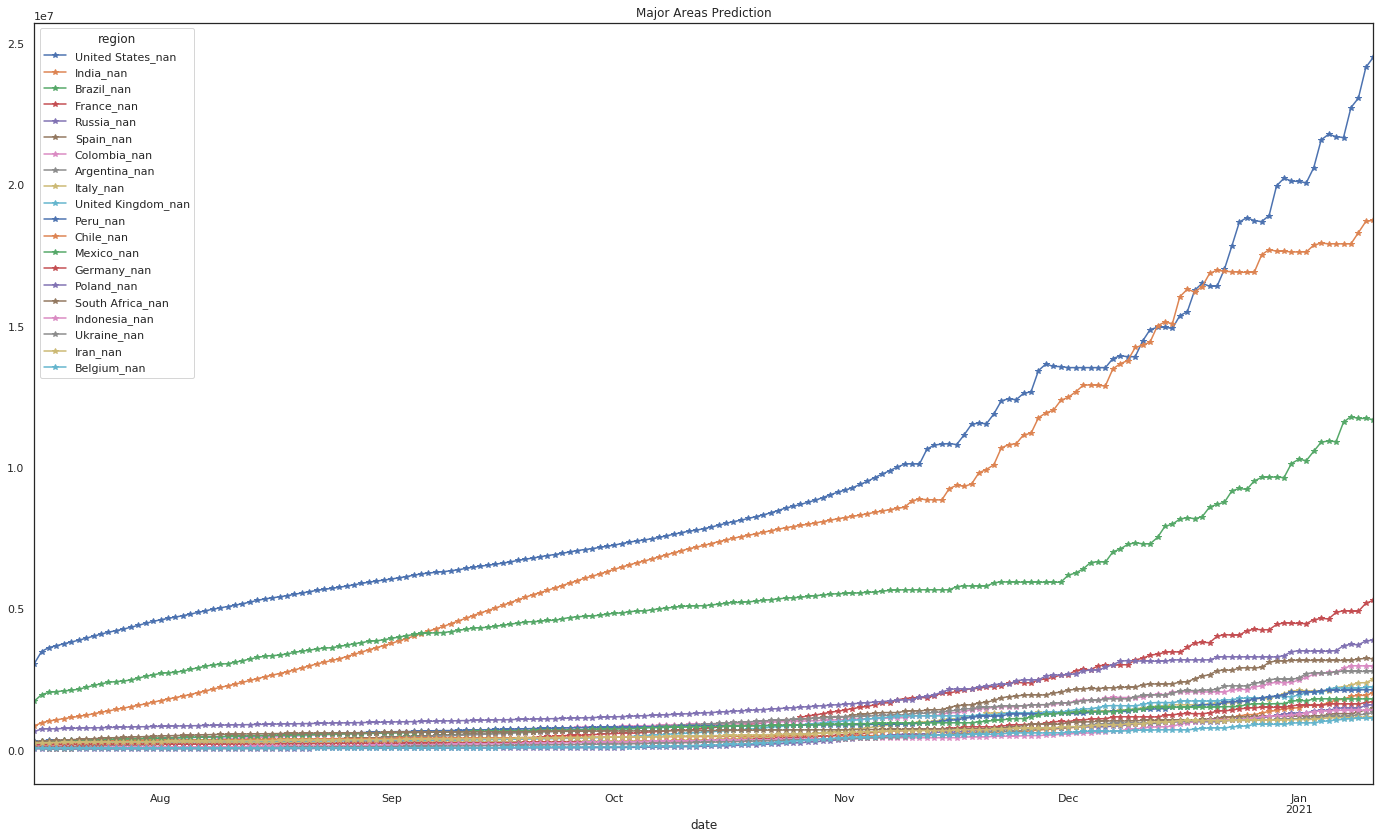

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

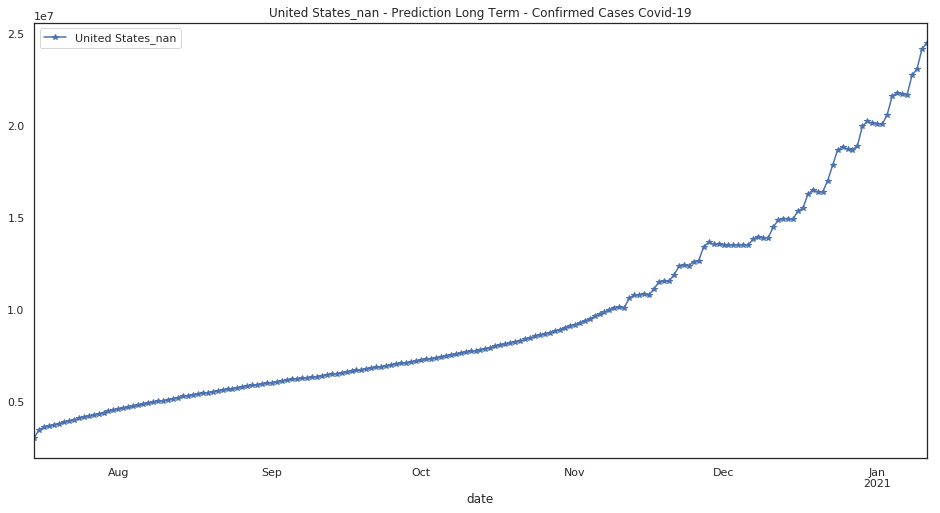

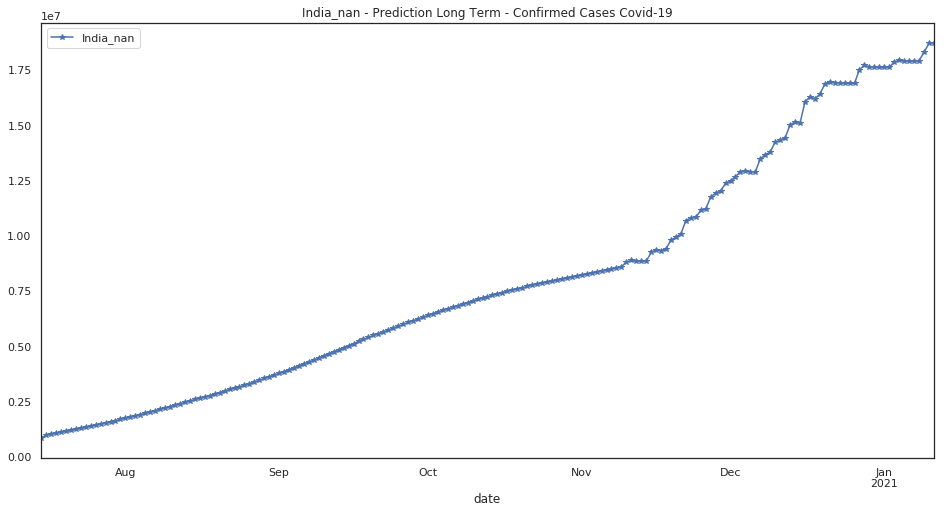

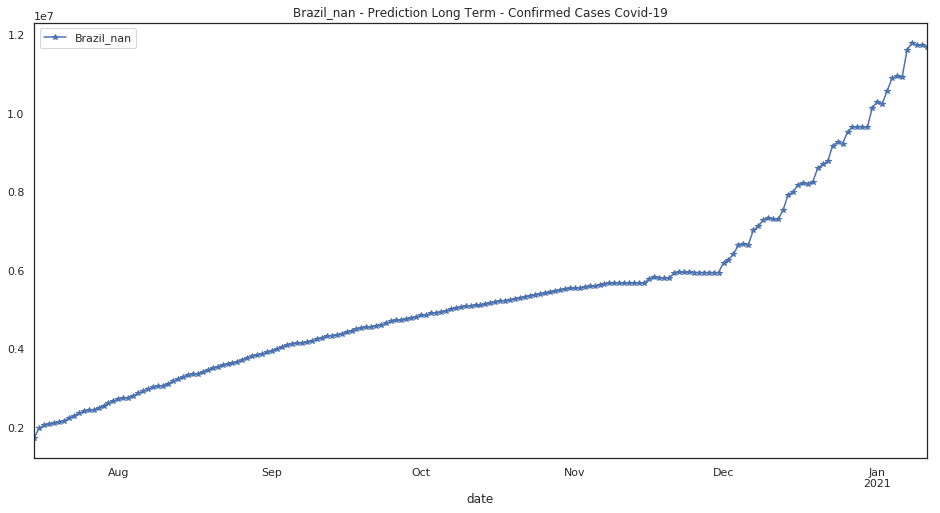

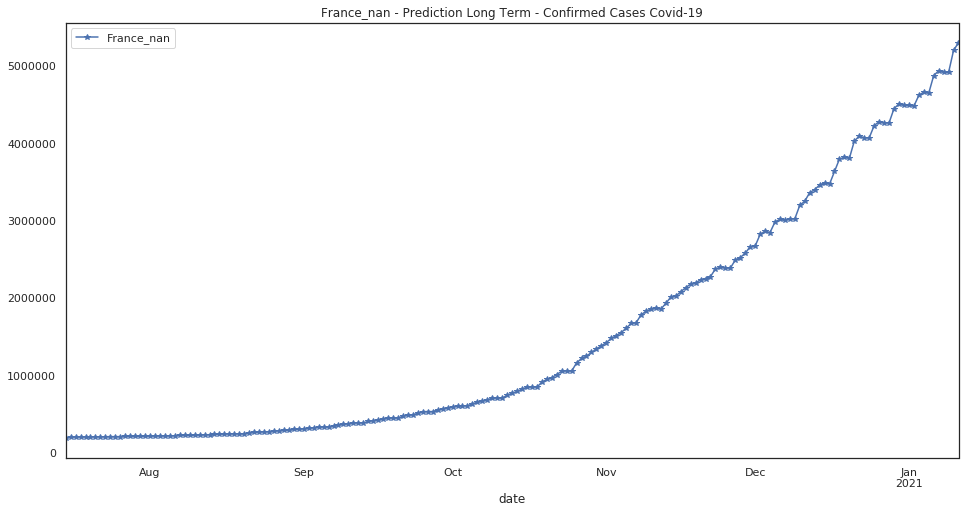

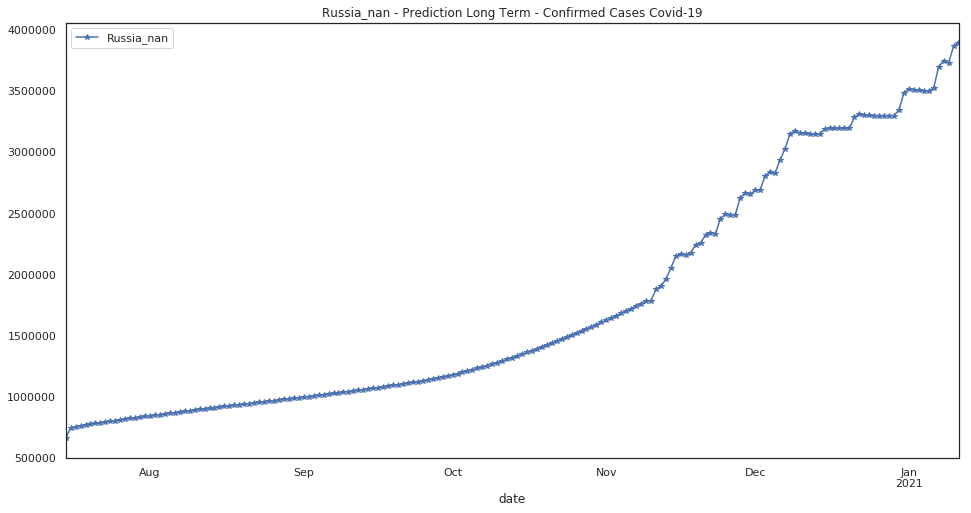

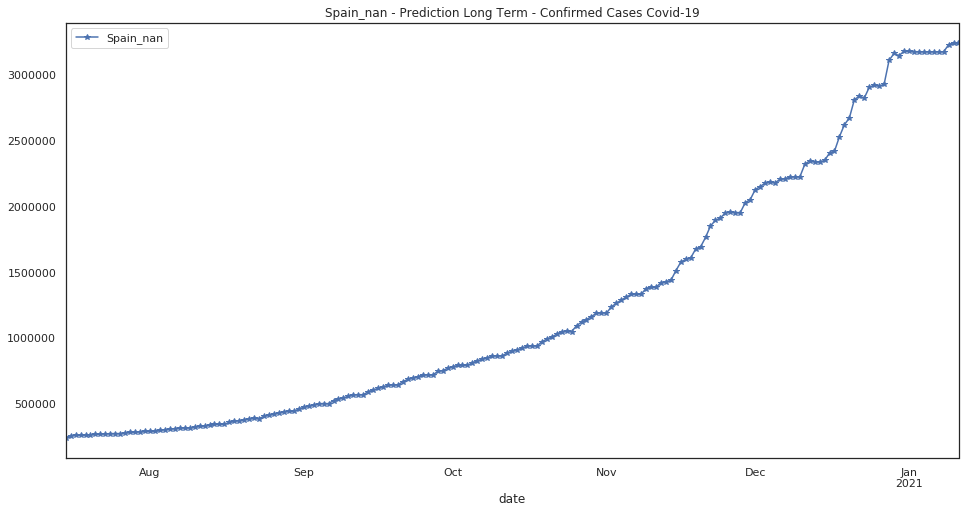

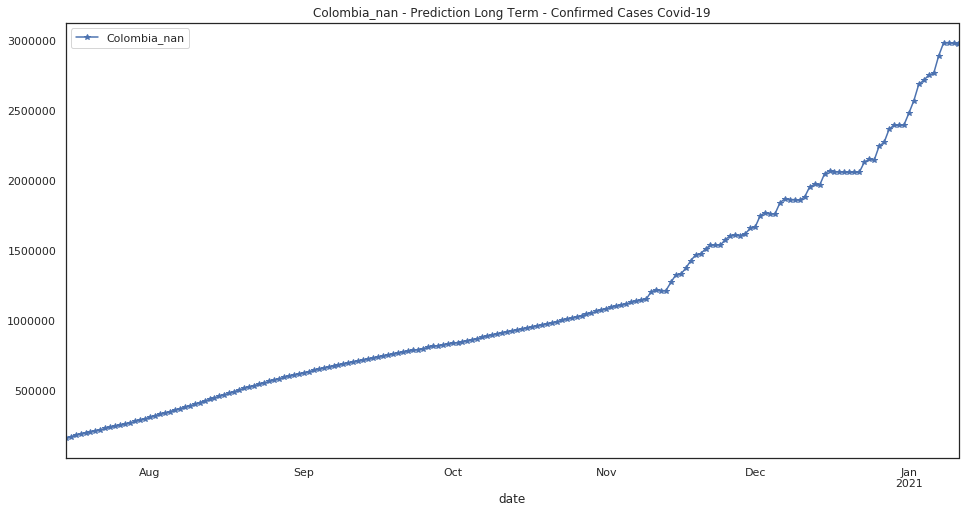

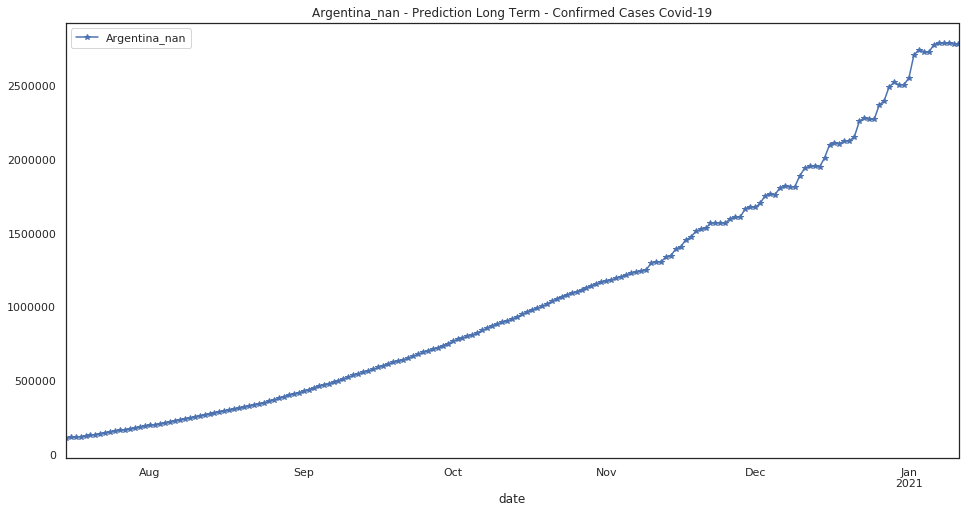

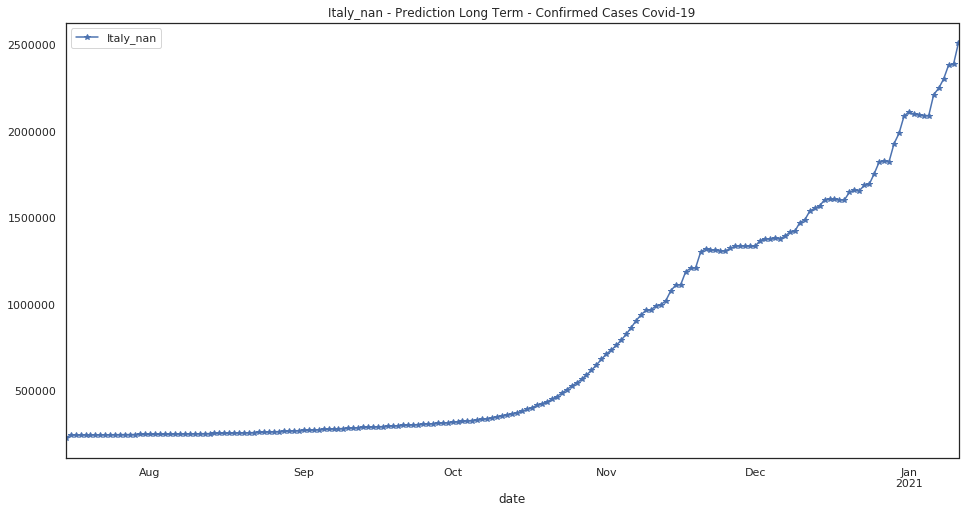

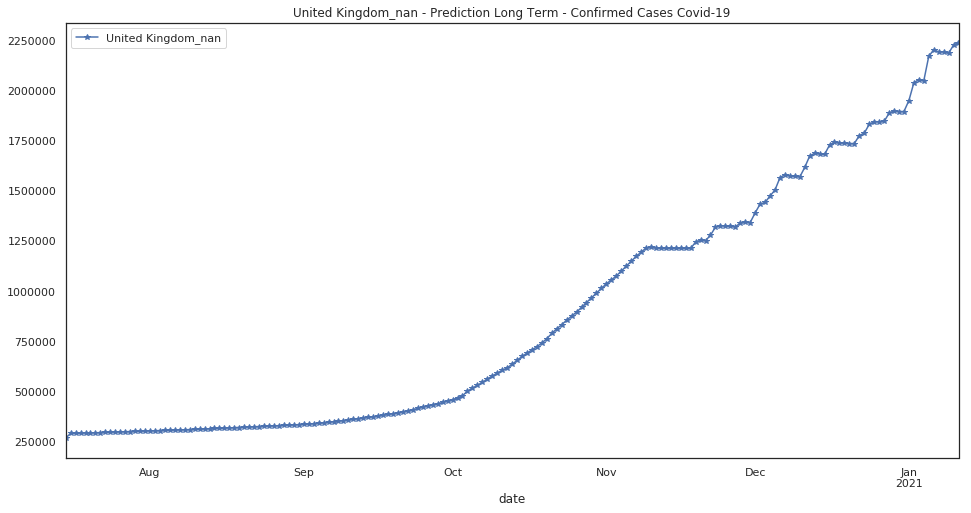

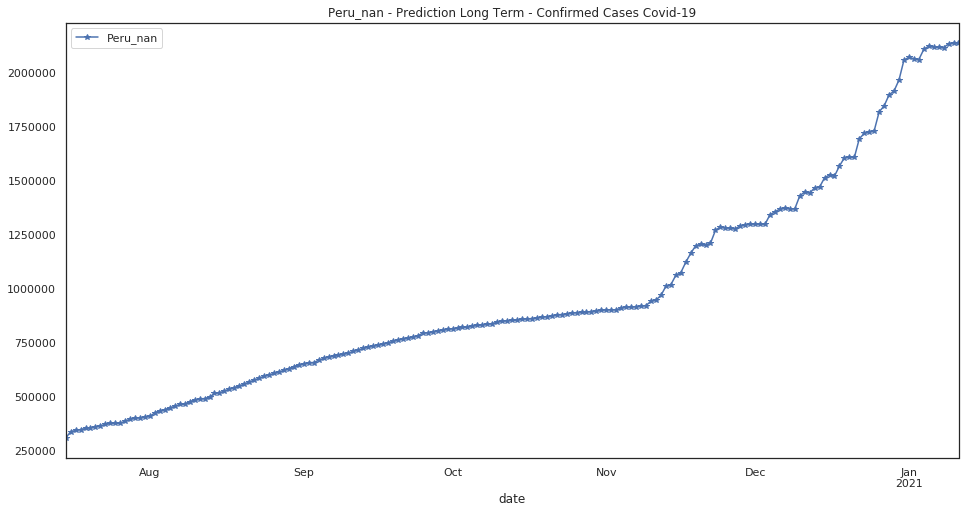

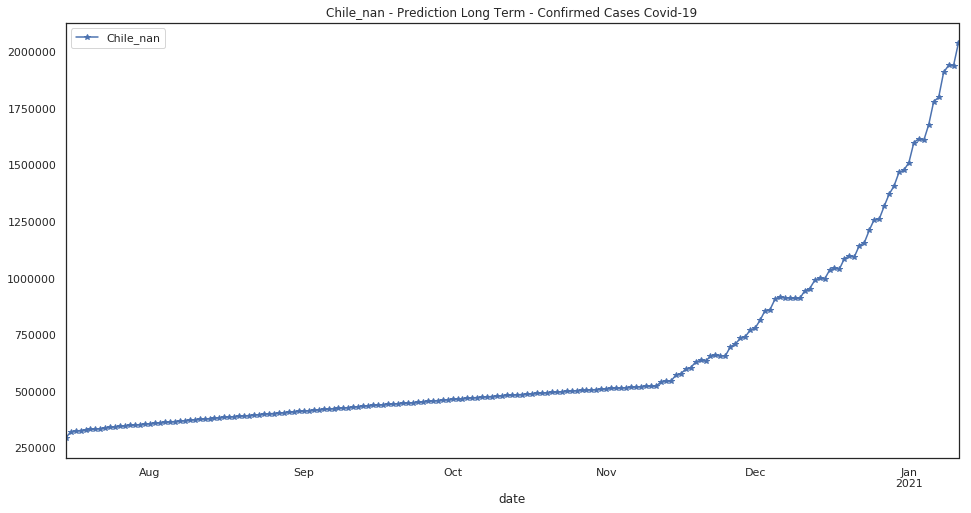

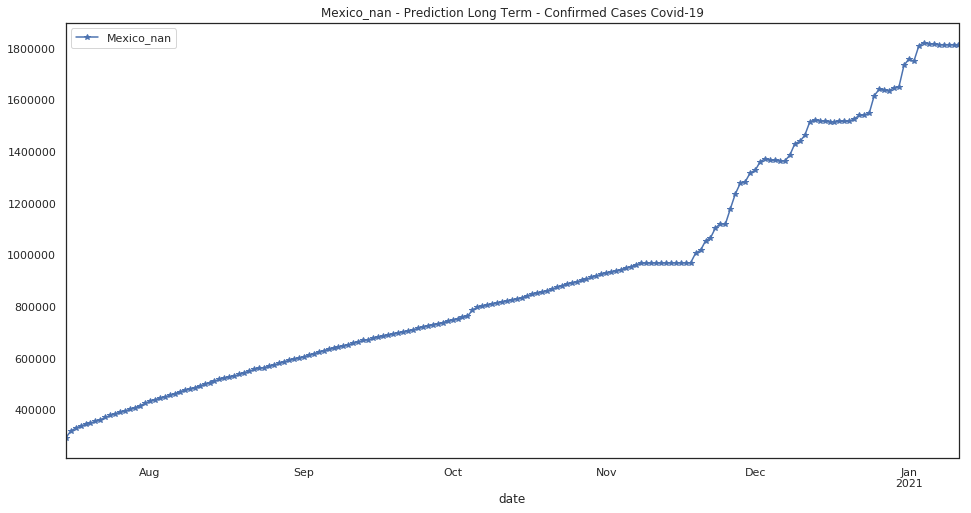

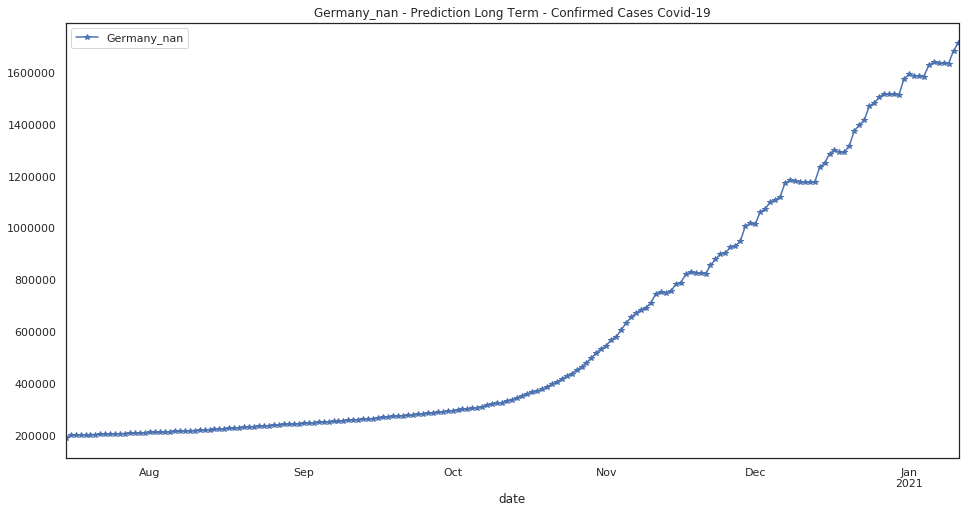

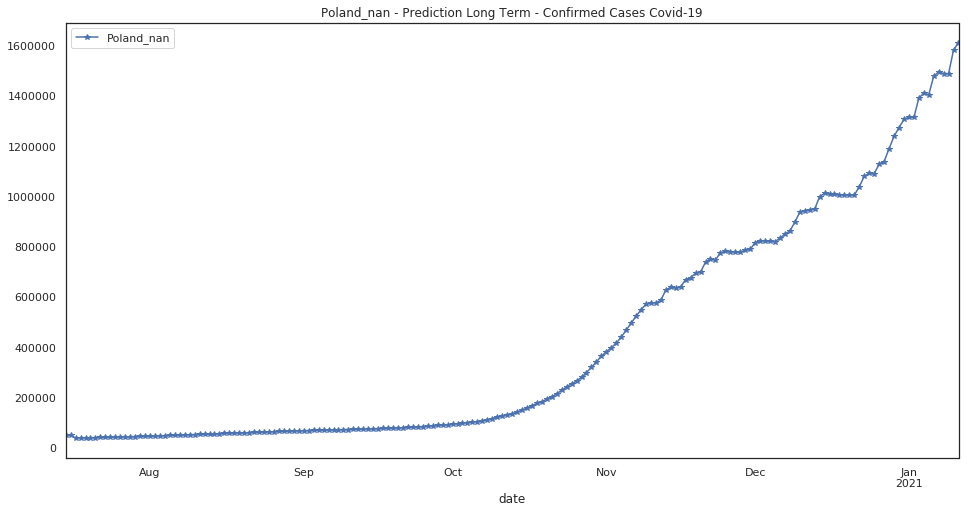

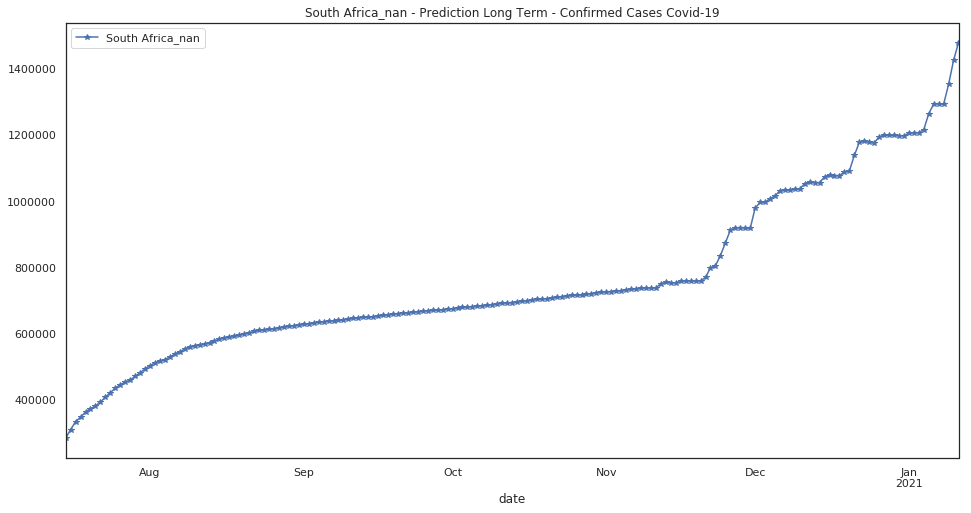

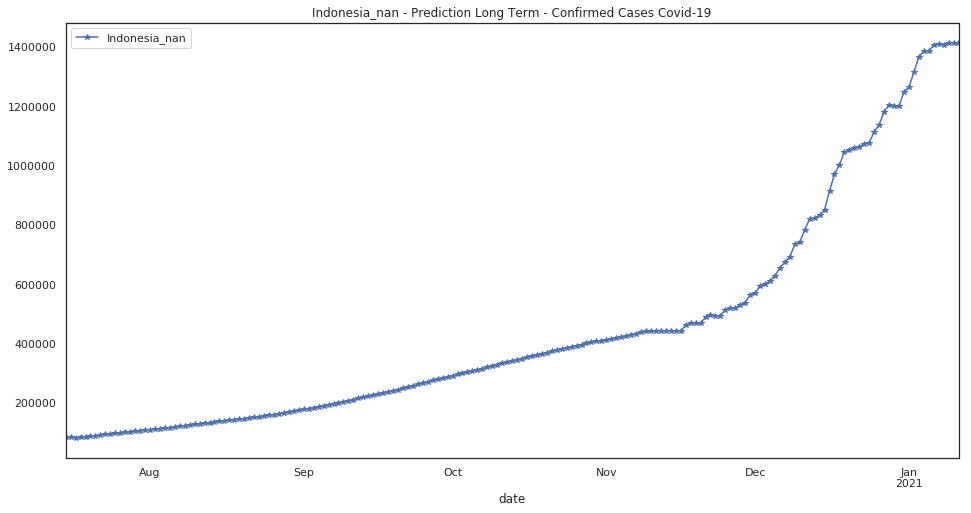

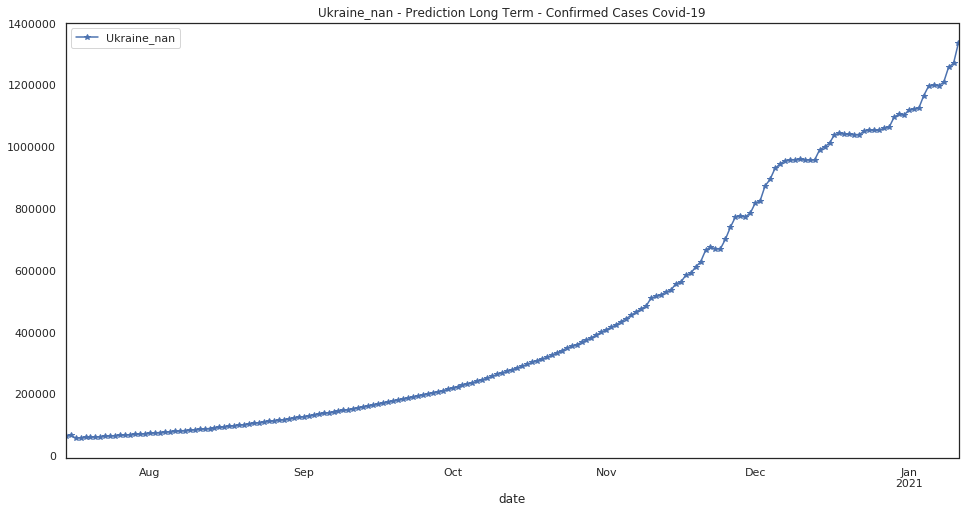

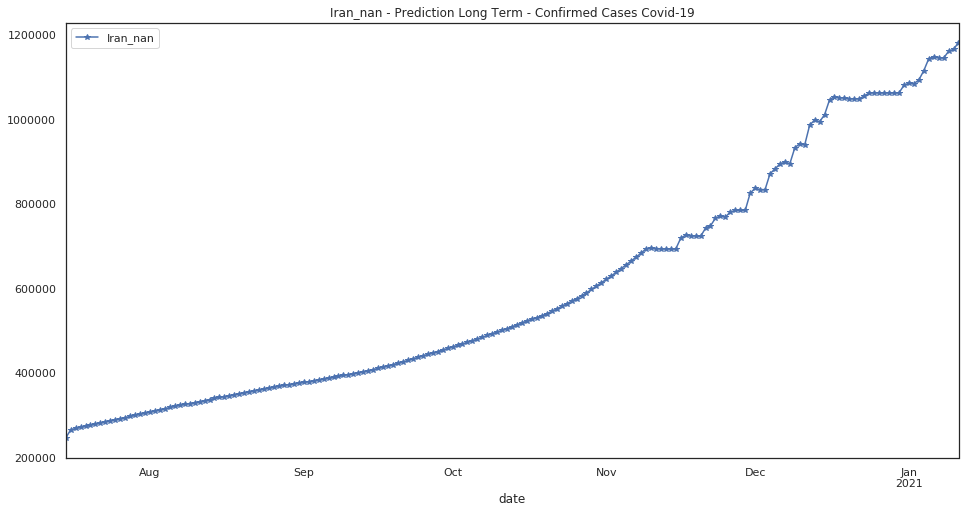

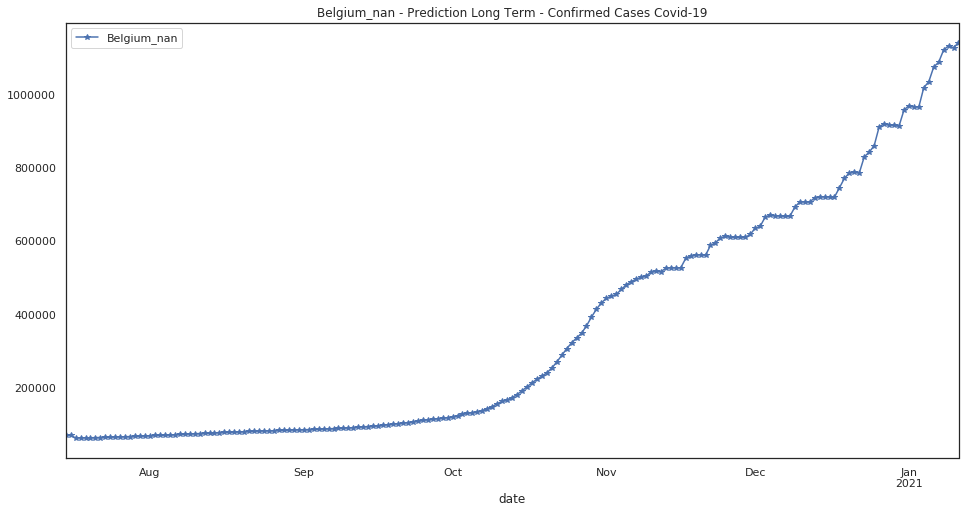

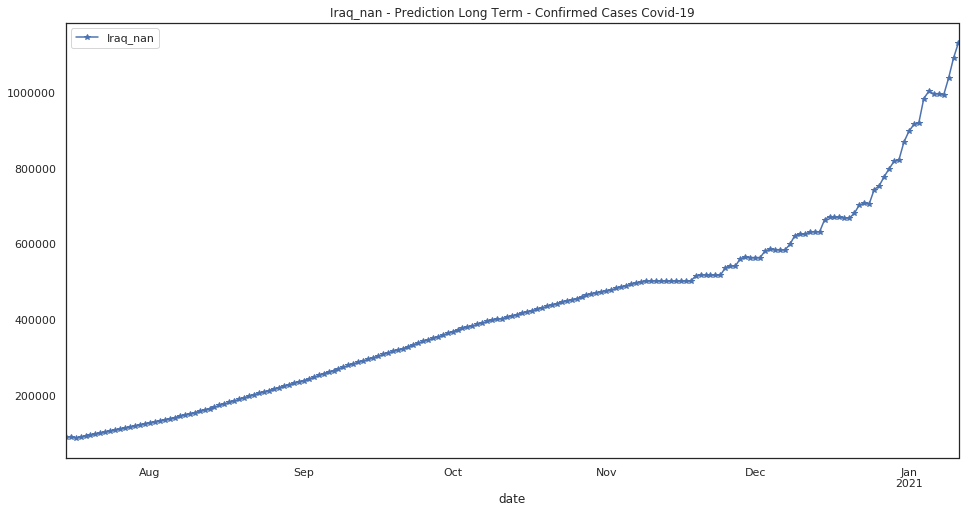

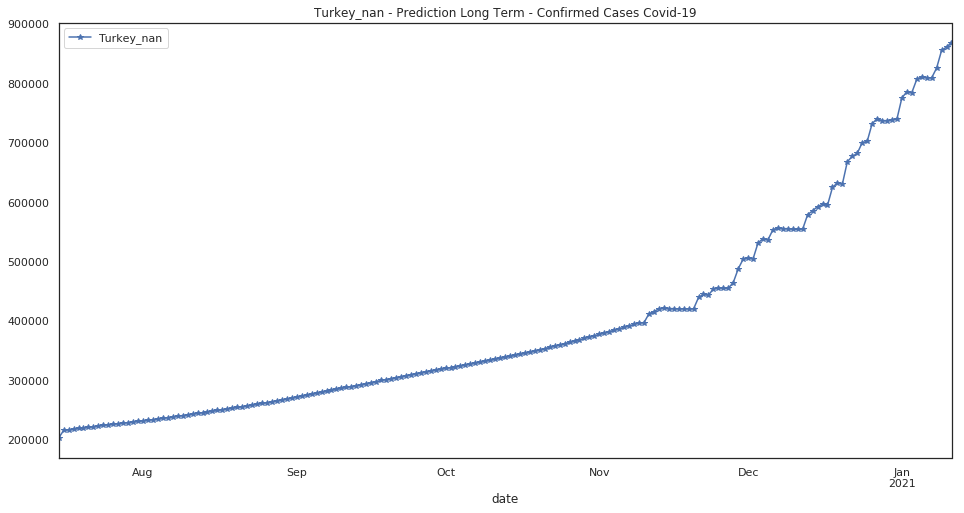

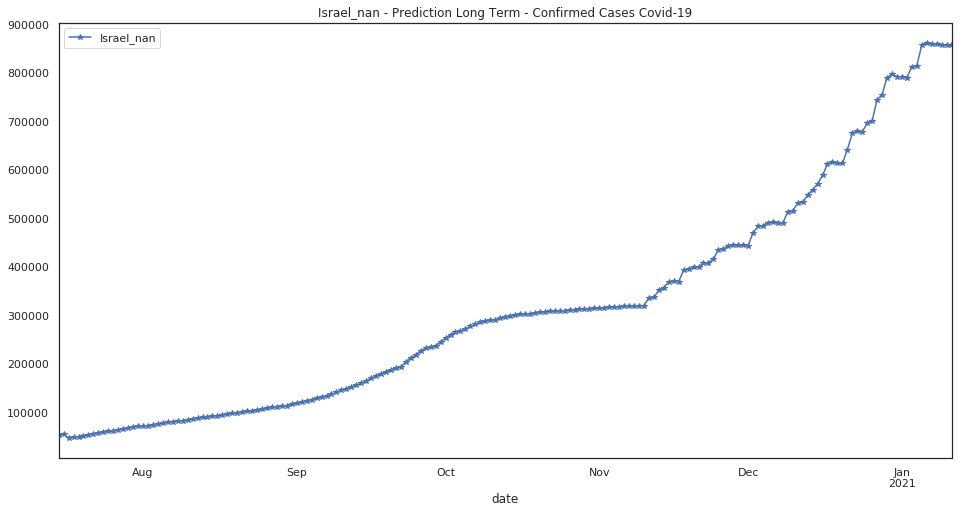

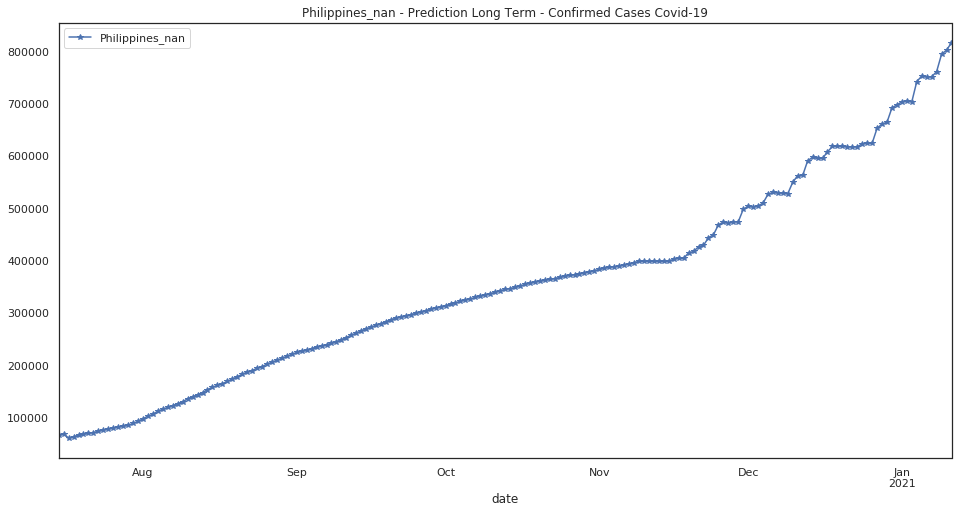

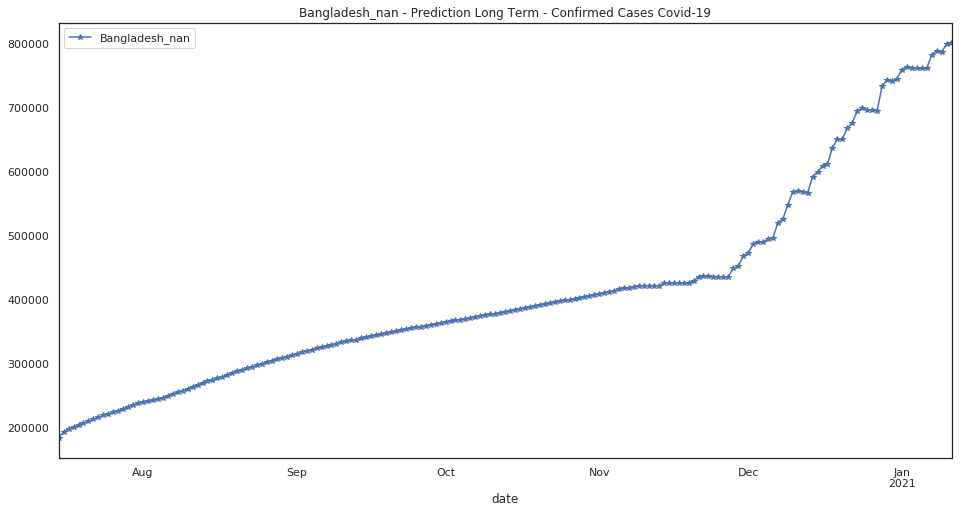

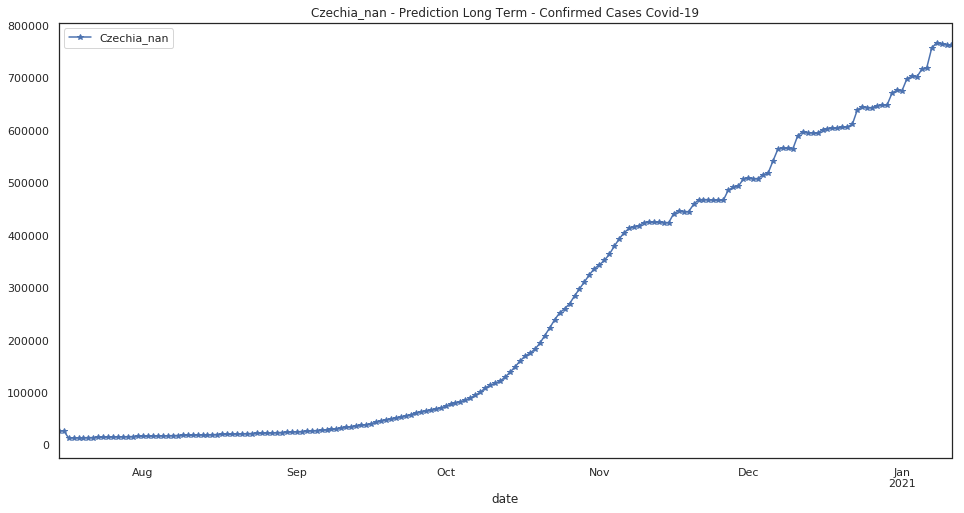

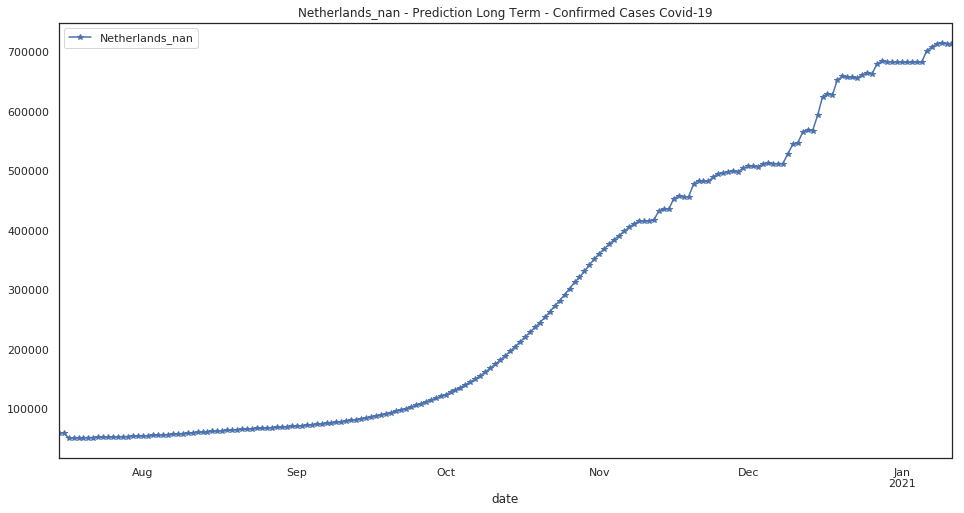

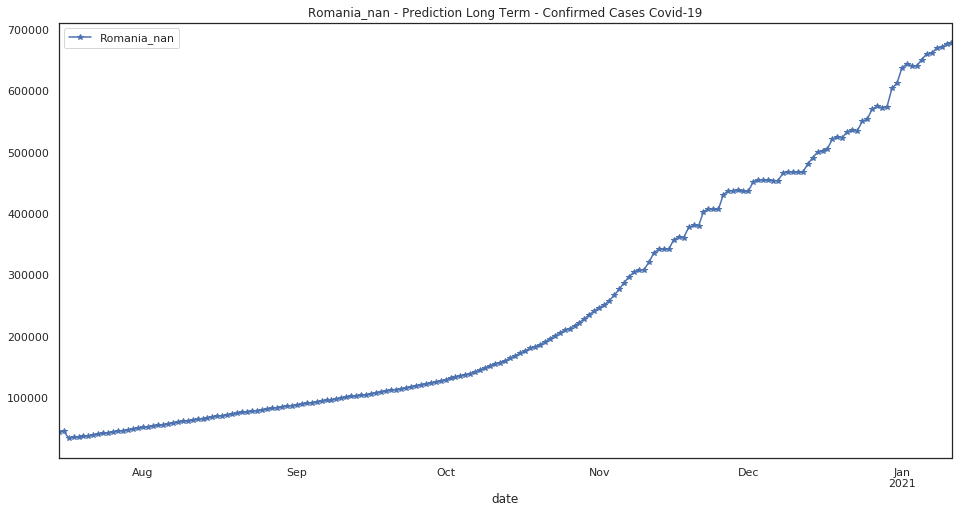

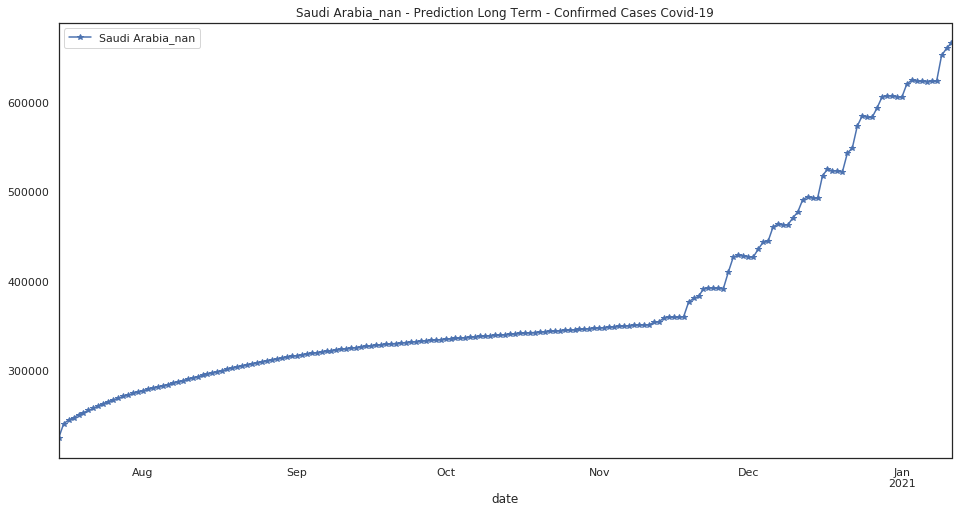

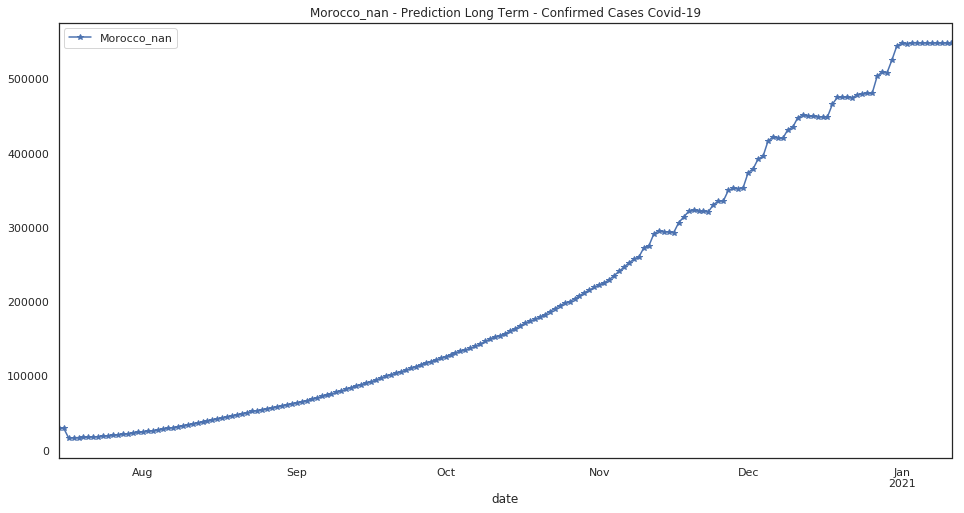

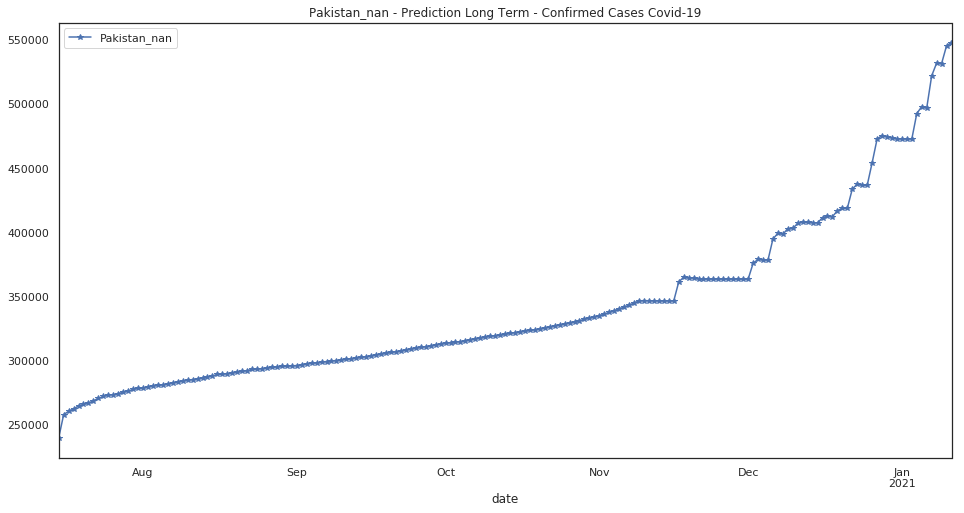

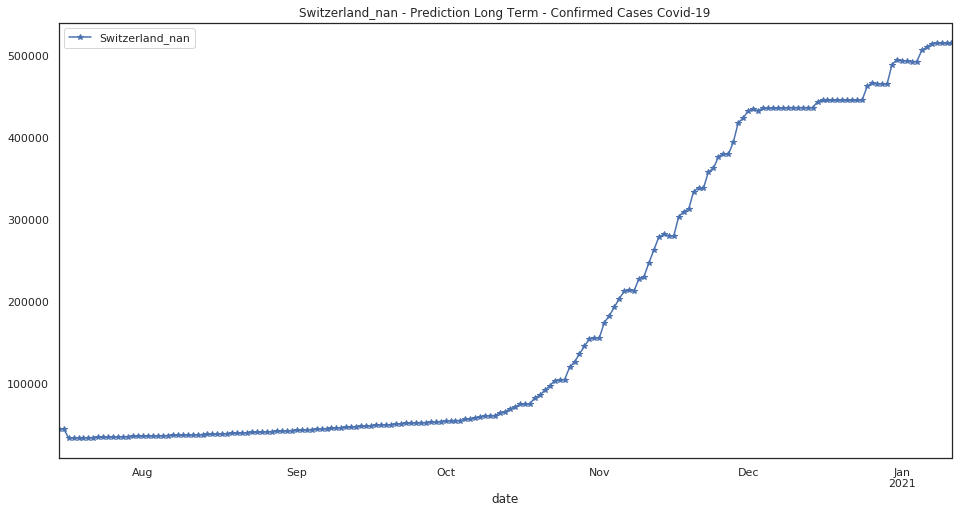

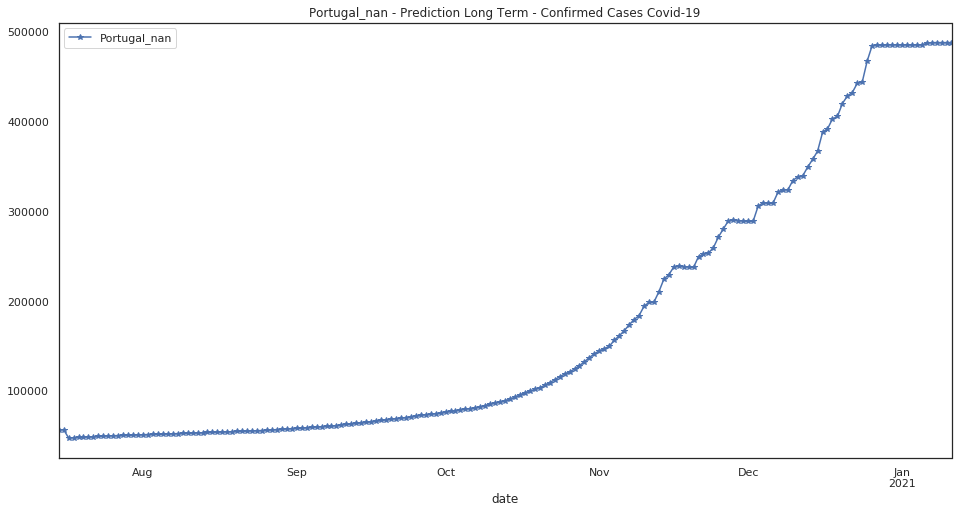

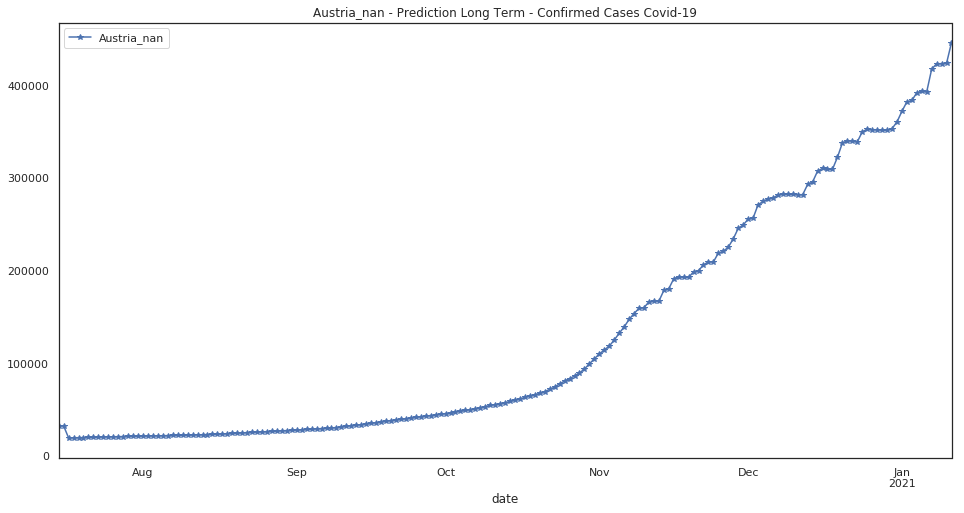

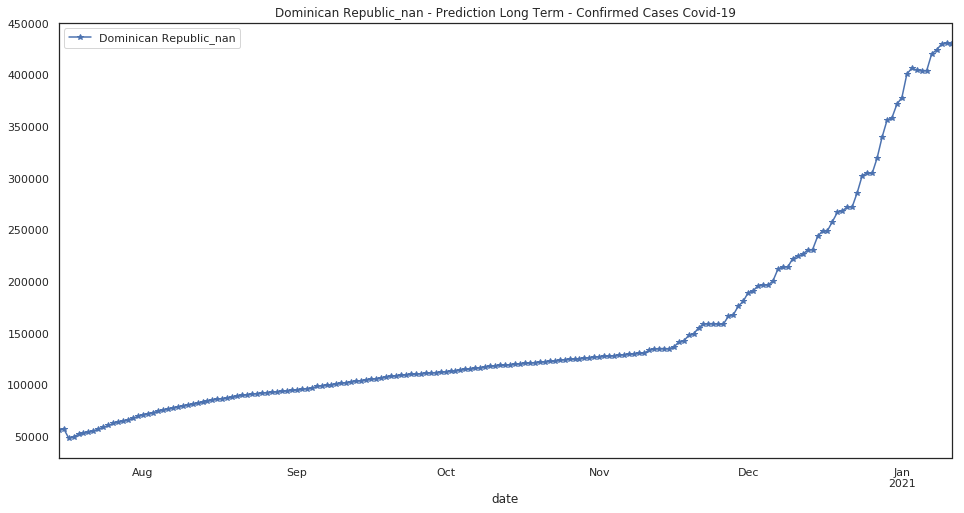

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

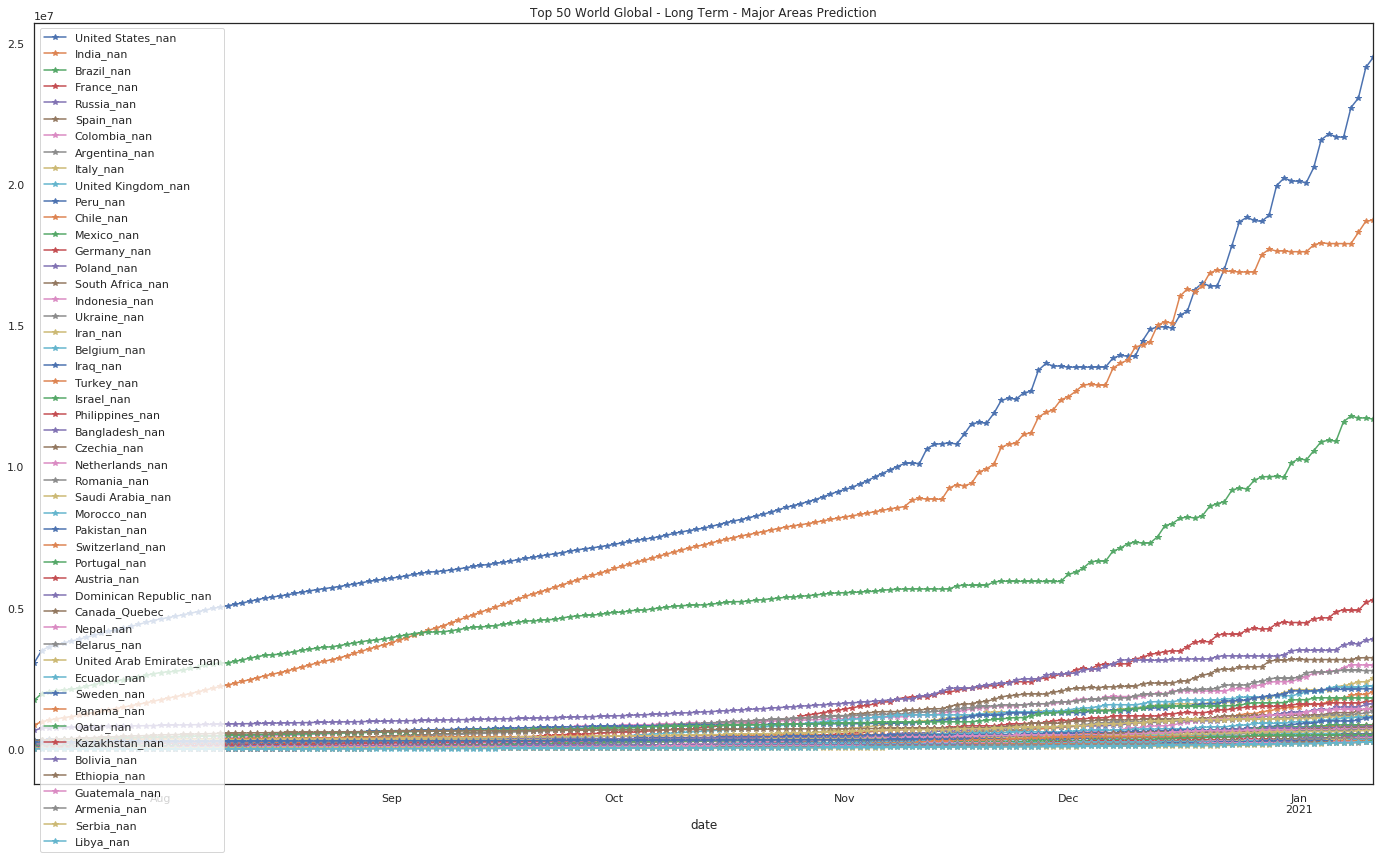

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

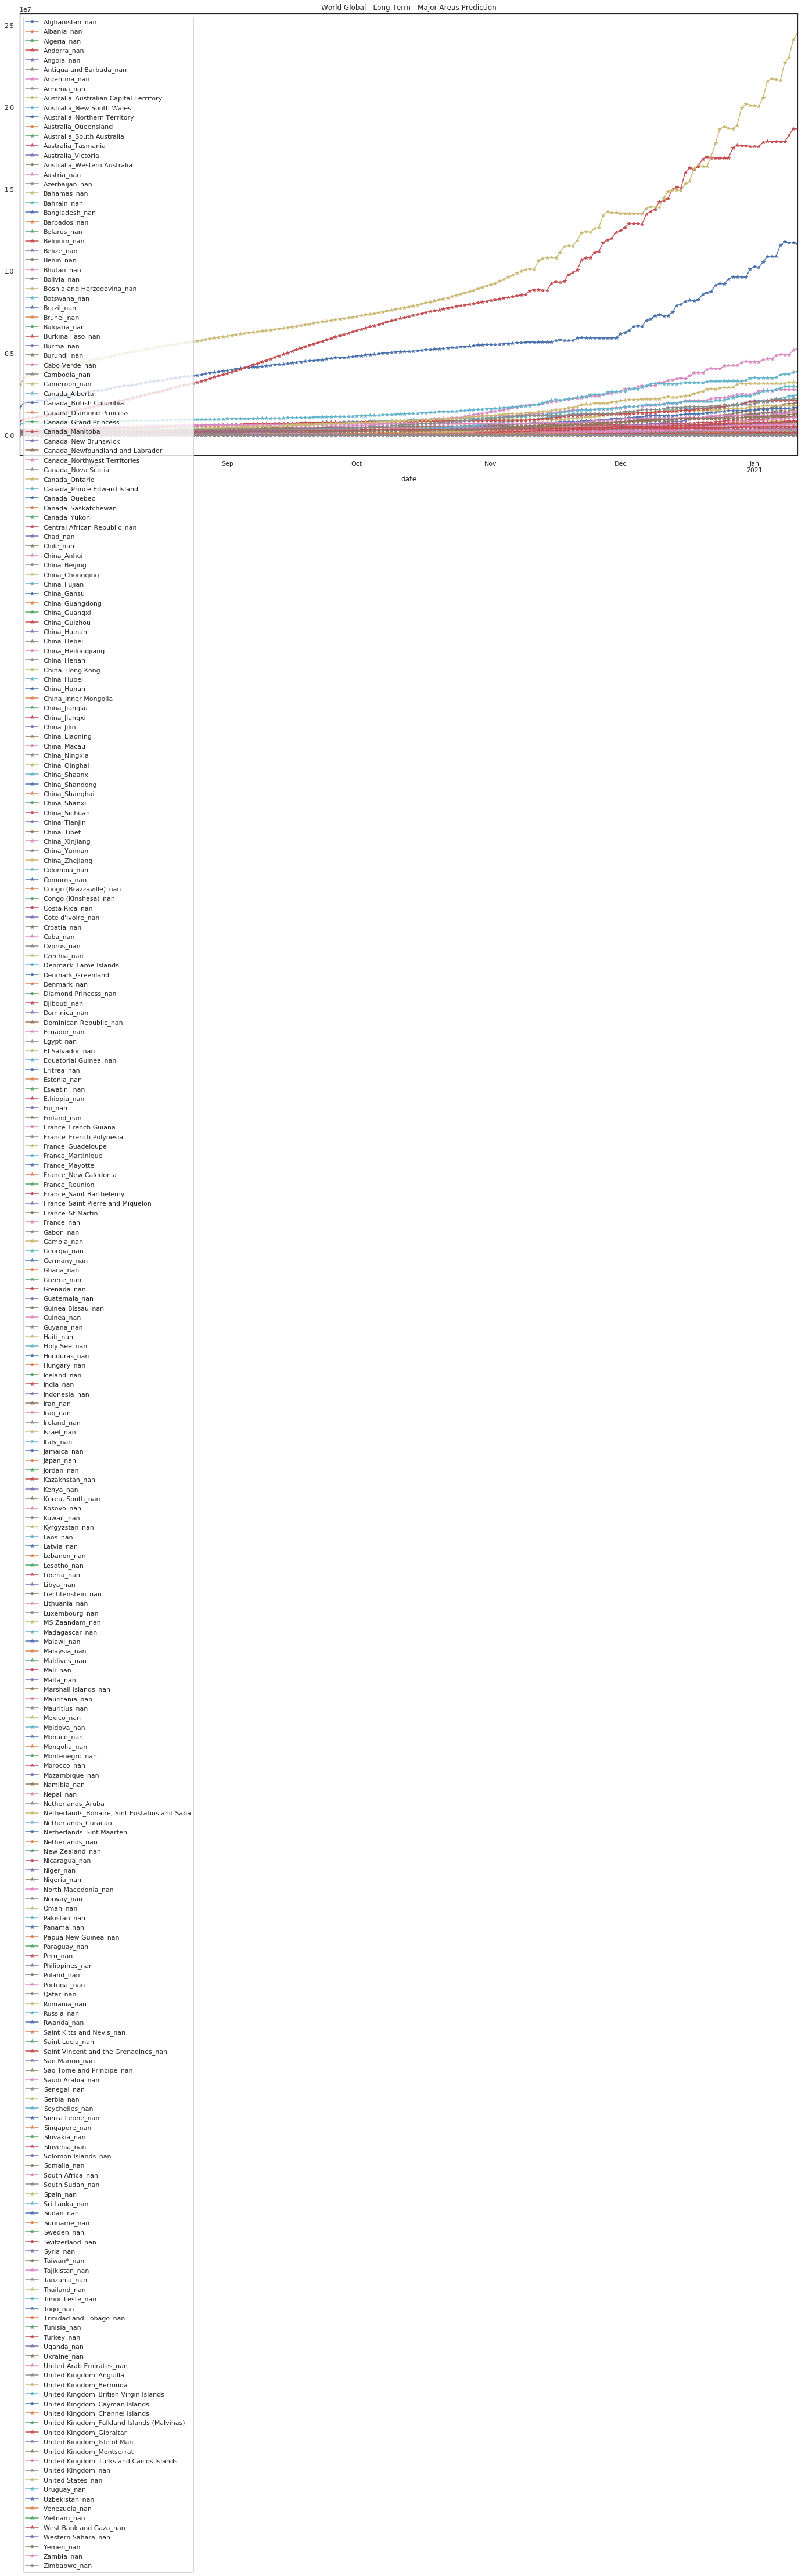

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38277.0       9333.0      43861.0       1124.0   
2020-08-30          38293.0       9467.0      44229.0       1254.0   
2020-08-31          38292.0       9558.0      44582.0       1299.0   
2020-09-01          38323.0       9602.0      44924.0       1176.0   
2020-09-02          38361.0       9784.0      45251.0       1251.0   
2020-09-03          38402.0       9853.0      45564.0       1199.0   
2020-09-04          38426.0       9982.0      45870.0       1345.0   
2020-09-05          38454.0      10109.0      46167.0       1215.0   
2020-09-06          38518.0      10247.0      46460.0       1337.0   
2020-09-07          38596.0      10379.0      46749.0       1377.0   
2020-09-08          38630.0      10536.0      47033.0       1261.0   
2020-09-09          38678.0      10699.0      47312.0       1417.0   
2020-09-10          38703.0      10852.0      47585.0       1301.0   
2020-09-11          38731.0      11010.0      47850.0       1465.0   
2020-09-12          38764.0      11172.0      48107.0       1344.0   
2020-09-13          38835.0      11340.0      48355.0       1480.0   
2020-09-14          38882.0      11506.0      48598.0       1562.0   
2020-09-15          38934.0      11664.0      48835.0       1438.0   
2020-09-16          38979.0      11831.0      49068.0       1644.0   
2020-09-17          38999.0      11974.0      49296.0       1483.0   
2020-09-18          39016.0      12112.0      49516.0       1697.0   
2020-09-19          39048.0      12266.0      49727.0       1564.0   
2020-09-20          39153.0      12390.0      49932.0       1727.0   
2020-09-21          39173.0      12537.0      50129.0       1829.0   
2020-09-22          39228.0      12684.0      50320.0       1681.0   
2020-09-23          39275.0      12827.0      50506.0       1911.0   
2020-09-24          39290.0      12968.0      50686.0       1753.0   
2020-09-25          39315.0      13077.0      50861.0       1979.0   
2020-09-26          39325.0      13199.0      51023.0       1836.0   
2020-09-27          39356.0      13321.0      51178.0       1982.0   
...                     ...          ...          ...          ...   
2020-12-13          58425.0      32900.0      84501.0       9409.0   
2020-12-14          58394.0      34151.0      84498.0       9811.0   
2020-12-15          58495.0      34557.0      86641.0       9811.0   
2020-12-16          60151.0      34899.0      86843.0       9811.0   
2020-12-17          60274.0      35962.0      87106.0       9983.0   
2020-12-18          62344.0      35835.0      87762.0       9983.0   
2020-12-19          63648.0      36041.0      91853.0      10117.0   
2020-12-20          63951.0      37944.0      92391.0      10117.0   
2020-12-21          65572.0      38051.0      92856.0      10117.0   
2020-12-22          68020.0      39112.0      92817.0      10449.0   
2020-12-23          71354.0      39015.0      92541.0      10672.0   
2020-12-24          71950.0      40473.0      96574.0      10900.0   
2020-12-25          73491.0      40486.0      97040.0      10900.0   
2020-12-26          77278.0      43004.0     100718.0      10900.0   
2020-12-27          77541.0      43110.0     101069.0      10900.0   
2020-12-28          78123.0      43683.0     102409.0      10993.0   
2020-12-29          78034.0      43787.0     102575.0      10993.0   
2020-12-30          79645.0      45527.0     102498.0      10993.0   
2020-12-31          83381.0      45661.0     108221.0      10993.0   
2021-01-01          83963.0      45920.0     108860.0      10993.0   
2021-01-02          85672.0      46281.0     113477.0      10993.0   
2021-01-03          90134.0      46078.0     118122.0      10993.0   
2021-01-04          90525.0      46184.0     118718.0      10993.0   
2021-01-05          93122.0      47274.0     118976.0      10993.0   
2021-01-06

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
244                                Thailand_nan  15.870032  100.992541   
245                             Timor-Leste_nan  -8.874217  125.727539   
246                                    Togo_nan   8.619500    0.824800   
247                     Trinidad and Tobago_nan  10.691800  -61.222500   
248                                 Tunisia_nan  33.886917    9.537499   
249                                  Turkey_nan  38.963700   35.243300   
250                           United States_nan  40.000000 -100.000000   
251                                  Uganda_nan   1.373333   32.290275   
252                                 Ukraine_nan  48.379400   31.165600   
253                    United Arab Emirates_nan  23.424076   53.847818   
254                     United Kingdom_Anguilla  18.220600  -63.068600   
255                      United Kingdom_Bermuda  32.307800  -64.750500   
256       United Kingdom_British Virgin Islands  18.420700  -64.640000   
257               United Kingdom_Cayman Islands  19.313300  -81.254600   
258              United Kingdom_Channel Islands  49.372300   -2.364400   
259  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
260                    United Kingdom_Gibraltar  36.140800   -5.353600   
261                  United Kingdom_Isle of Man  54.236100   -4.548100   
262                   United Kingdom_Montserrat  16.742498  -62.187366   
263     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
264                          United Kingdom_nan  55.378100   -3.436000   
265                                 Uruguay_nan -32.522800  -55.765800   
266                              Uzbekistan_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1       7               Armenia_nan  40.069100   45.038200   
2      16               Austria_nan  47.516200   14.550100   
3      20            Bangladesh_nan  23.685000   90.356300   
4      22               Belarus_nan  53.709800   27.953400   
5      23               Belgium_nan  50.833300    4.469936   
6      27               Bolivia_nan -16.290200  -63.588700   
7      30                Brazil_nan -14.235000  -51.925300   
8      52             Canada_Quebec  52.939900  -73.549100   
9      57                 Chile_nan -35.675100  -71.543000   
10     91              Colombia_nan   4.570900  -74.297300   
11    100               Czechia_nan  49.817500   15.473000   
12    107    Dominican Republic_nan  18.735700  -70.162700   
13    108               Ecuador_nan  -1.831200  -78.183400   
14    115              Ethiopia_nan   9.145000   40.489700   
15    128                France_nan  46.227600    2.213700   
16    133               Germany_nan  51.165691   10.451526   
17    137             Guatemala_nan  15.783500  -90.230800   
18    147                 India_nan  20.593684   78.962880   
19    148             Indonesia_nan  -0.789300  113.921300   
20    149                  Iran_nan  32.427908   53.688046   
21    150                  Iraq_nan  33.223191   43.679291   
22    152                Israel_nan  31.046051   34.851612   
23    153                Israel_nan  31.046051   34.851612   
24    154                 Italy_nan  41.871940   12.567380   
25    158            Kazakhstan_nan  48.019600   66.923700   
26    170                 Libya_nan  26.335100   17.228331   
27    184                Mexico_nan  23.634500 -102.552800   
28    189               Morocco_nan  31.791700   -7.092600   
29    192                 Nepal_nan  28.166700   84.250000   
30    197           Netherlands_nan  52.132600    5.291300   
31    204                  Oman_nan  21.512583   55.923255   
32    205              Pakistan_nan  30.375300   69.345100   
33    206                Panama_nan   8.538000  -80.782100   
34    209                  Peru_nan  -9.190000  -75.015200   
35    210           Philippines_nan  12.879721  121.774017   
36    211                Poland_nan  51.919400   19.145100   
37    212              Portugal_nan  39.399900   -8.224500   
38    213                 Qatar_nan  25.354800   51.183900   
39    214               Romania_nan  45.943200   24.966800   
40    215                Russia_nan  61.524010  105.318756   
41    222          Saudi Arabia_nan  23.885942   45.079162   
42    224                Serbia_nan  44.016500   21.005900   
43    232          South Africa_nan -30.559500   22.937500   
44    234                 Spain_nan  40.463667   -3.749220   
45    238                Sweden_nan  60.128161   18.643501   
46    239           Switzerland_nan  46.818200    8.227500   
47    249                Turkey_nan  38.963700   35.243300   
48    250         United States_nan  40.000000 -100.000000   
49    252               Ukraine_nan  48.379400   31.165600   
50    253  United Arab Emirates_nan  23.424076   53.847818   
51    264        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              112075.0             115237.0             117569.0   
1               44130.0              44612.0              33559.0   
2               32087.0              32188.0              19270.0   
3              183761.0             193590.0             197998.0   
4               72336.0              72492.0              65623.0   
5               70100.0              70418.0              63238.0   
6               60836.0              62521.0              54519.0   
7             1725542.0            1966748.0            2043124.0   
8               64872.0              64995.0              57001.0   
9              294724.0    

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()